In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import math
import geopandas as gpd
import cartopy.crs as ccrs
from datetime import datetime
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import random
from skimage.transform import resize
import torchvision.transforms.functional as TF
import cv2
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from IPython.display import FileLink
from sklearn.metrics import precision_recall_fscore_support
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_curve, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
rainfall_images_set = "/kaggle/input/rainfall-images"
flood_images_set = "/kaggle/input/flood-images"

In [3]:
# Function to get the first image file in a directory
def get_first_image(directory):
    image_files = sorted(os.listdir(directory))
    first_image_file = image_files[0]
    first_image_path = os.path.join(directory, first_image_file)
    return first_image_path

In [4]:
# Get the path of the first image
first_image_path = get_first_image(rainfall_images_set)

# Open the image using PIL and convert to grayscale
first_image = Image.open(first_image_path).convert("L")

# Convert the image to a NumPy array
image_array = np.array(first_image)

# Print the shape of the image array
print("Image shape:", image_array.shape)

# Find the maximum value in the whole image
max_pixel_value = np.max(image_array)
print("Maximum pixel value in the image:", max_pixel_value)

# Find the minimum value in the whole image
min_pixel_value = np.min(image_array)
print("Minimum pixel value in the image:", min_pixel_value)

Image shape: (400, 1440)
Maximum pixel value in the image: 255
Minimum pixel value in the image: 158


In [5]:
# Get the path of the first image
first_image_path = get_first_image(flood_images_set)

# Open the image using PIL
first_image = Image.open(first_image_path).convert("L")

# Convert the image to a NumPy array
image_array = np.array(first_image)

# Print the shape of the image array
print("Image shape:", image_array.shape)

# Find the maximum value in the whole image
max_pixel_value = np.max(image_array)
print("Maximum pixel value in the image:", max_pixel_value)

# Find the minimum value in the whole image
min_pixel_value = np.min(image_array)
print("Minimum pixel value in the image:", min_pixel_value)

Image shape: (400, 1440)
Maximum pixel value in the image: 255
Minimum pixel value in the image: 0


In [6]:
# Function to downscale an image
def downscale_image(image, target_size):
    downscaled_image = image.resize(target_size, resample=Image.LANCZOS)
    return downscaled_image

In [7]:
def downscale_image_with_black_pixels(image, target_size):
    # Create a new image with the target size and fill it with white pixels
    downscaled_image = Image.new("L", target_size, color=255)
    
    # Calculate the scaling factor for downscaling
    scale_factor = (image.size[0] // target_size[0], image.size[1] // target_size[1])
    
    # Iterate over each pixel in the downscaled image
    for y in range(target_size[1]):
        for x in range(target_size[0]):
            # Calculate the corresponding region in the original image
            region = (x * scale_factor[0], y * scale_factor[1], (x + 1) * scale_factor[0], (y + 1) * scale_factor[1])
            
            # Get the pixel values of the region in the original image
            region_pixels = image.crop(region).getdata()
            
            # Check if any pixel in the region is black (representing flood)
            if any(pixel == 0 for pixel in region_pixels):
                # Set the corresponding pixel in the downscaled image to black
                downscaled_image.putpixel((x, y), 0)
    
    return downscaled_image

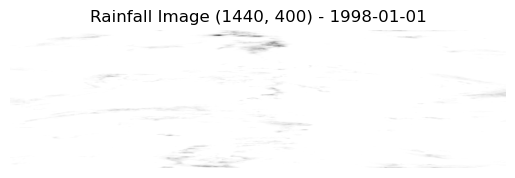

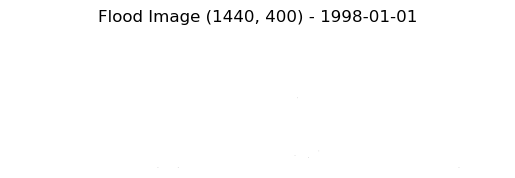

Number of floods: 7


In [8]:
# Function to extract the date from the image file name
def extract_date_from_filename(filename):
    date_string = os.path.splitext(filename)[0]  # Remove the file extension
    date = datetime.strptime(date_string, "%Y-%m-%d").date()
    return date

# Display the first rainfall image
rainfall_image_path = get_first_image(rainfall_images_set)
rainfall_image = Image.open(rainfall_image_path).convert("L")  # Open as grayscale
rainfall_date = extract_date_from_filename(os.path.basename(rainfall_image_path))
rainfall_title = f"Rainfall Image (1440, 400) - {rainfall_date}"
plt.imshow(rainfall_image, cmap='gray')
plt.axis('off')
plt.title(rainfall_title)
plt.savefig("rainfall_image.png")
plt.show()

# Display the first flood image
flood_image_path = get_first_image(flood_images_set)
flood_image = Image.open(flood_image_path).convert("L")  # Open as grayscale
flood_date = extract_date_from_filename(os.path.basename(flood_image_path))
flood_title = f"Flood Image (1440, 400) - {flood_date}"
plt.imshow(flood_image, cmap='gray')
plt.axis('off')
plt.title(flood_title)
plt.savefig("flood_image.png")
plt.show()

# Convert the downscaled flood image to a NumPy array
flood_array = np.array(flood_image)

# Count the number of black pixels (pixels with intensity 0)
num_black_pixels = np.count_nonzero(flood_array == 0)

# Print the count of black pixels (representing floods)
print(f"Number of floods: {num_black_pixels}")

/tmp/ipykernel_29/1589114512.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


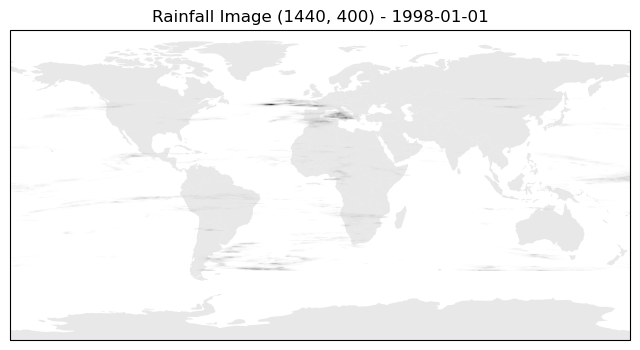

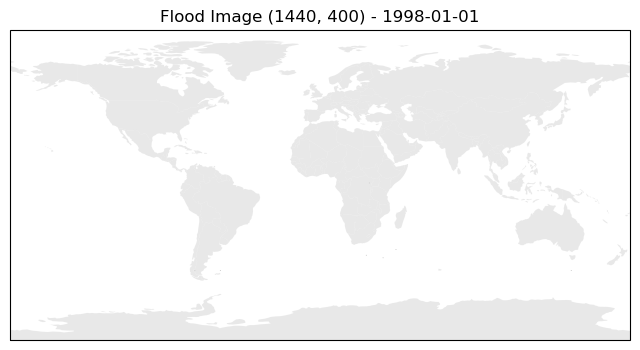

In [9]:
# Load the first rainfall image
rainfall_image_path = get_first_image(rainfall_images_set)
rainfall_image = Image.open(rainfall_image_path).convert("L")  # Open as grayscale
rainfall_date = extract_date_from_filename(os.path.basename(rainfall_image_path))

# Create a new figure with Cartopy projection
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the rainfall image
ax.imshow(rainfall_image, cmap='gray', extent=[-180, 180, -50, 50], transform=ccrs.PlateCarree())

# Read the shapefile for the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map as the overlay
world.plot(ax=ax, color='lightgray', alpha=0.5)

# Set the title and axis labels
rainfall_title = f"Rainfall Image (1440, 400) - {rainfall_date}"
plt.title(rainfall_title)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.savefig("rainfall_image_map.png")
plt.show()

# Load the first flood image
flood_image_path = get_first_image(flood_images_set)
flood_image = Image.open(flood_image_path).convert("L")  # Open as grayscale
flood_date = extract_date_from_filename(os.path.basename(flood_image_path))

# Create a new figure with Cartopy projection
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the flood image
ax.imshow(flood_image, cmap='gray', extent=[-180, 180, -50, 50], transform=ccrs.PlateCarree())

# Plot the world map as the overlay
world.plot(ax=ax, color='lightgray', alpha=0.5)

# Set the title and axis labels
flood_title = f"Flood Image (1440, 400) - {flood_date}"
plt.title(flood_title)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.savefig("flood_image_map.png")
plt.show()

In [10]:
# Constants for pixel size and Earth's radius
pixel_size_deg = 0.25
earth_radius_km = 6371  # Mean radius of the Earth in kilometers

# Calculate the pixel size in km²
pixel_size_km2 = math.pi * (pixel_size_deg * earth_radius_km / 180) ** 2

# Display the pixel size in km²
print(f"Pixel size: {pixel_size_km2:.2f} km²")

Pixel size: 245.98 km²


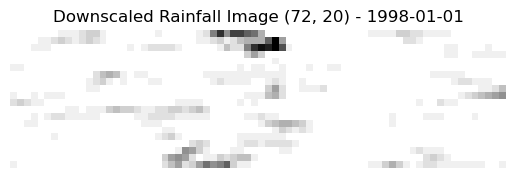

(20, 72)
Minimum pixel value in the rainfall image: 239
Maximum pixel value in the rainfall image: 255
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 254 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [254 255 255 ... 255 255 254]]


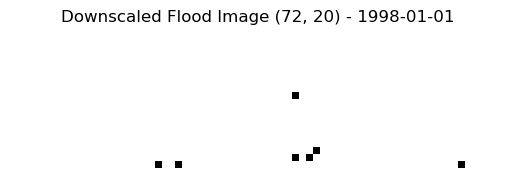

(20, 72)
Minimum pixel value in the flood image: 0
Maximum pixel value in the flood image: 255
Number of floods: 7
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [11]:
# Define the target size for downscaled images
downscaled_resolution = (72, 20)

# Load the first rainfall image
rainfall_image_path = get_first_image(rainfall_images_set)
rainfall_image = Image.open(rainfall_image_path).convert("L")  # Open as grayscale
rainfall_date = extract_date_from_filename(os.path.basename(rainfall_image_path))

# Downscale the rainfall image
downscaled_rainfall_image = downscale_image(rainfall_image, downscaled_resolution)

# Display the downscaled rainfall image
plt.imshow(downscaled_rainfall_image, cmap='gray')
plt.axis('off')
rainfall_title = f"Downscaled Rainfall Image {downscaled_resolution} - {rainfall_date}"
plt.title(rainfall_title)
plt.savefig("rainfall_image_downscaled.png")
plt.show()

# Convert the downscaled rainfall image to a NumPy array
rainfall_array = np.array(downscaled_rainfall_image)
print(rainfall_array.shape)

# Print the minimum and maximum values in the rainfall image
print("Minimum pixel value in the rainfall image:", np.min(rainfall_array))
print("Maximum pixel value in the rainfall image:", np.max(rainfall_array))

print(rainfall_array)

# Load the first flood image
flood_image_path = get_first_image(flood_images_set)
flood_image = Image.open(flood_image_path).convert("L")  # Open as grayscale
flood_date = extract_date_from_filename(os.path.basename(flood_image_path))

# Downscale the flood image while preserving black pixels
downscaled_flood_image = downscale_image_with_black_pixels(flood_image, downscaled_resolution)

# Display the downscaled flood image
plt.imshow(downscaled_flood_image, cmap='gray')
plt.axis('off')
flood_title = f"Downscaled Flood Image {downscaled_resolution} - {flood_date}"
plt.title(flood_title)
plt.savefig("flood_image_downscaled.png")
plt.show()

# Convert the downscaled flood image to a NumPy array
flood_array = np.array(downscaled_flood_image)
print(flood_array.shape)

# Print the minimum and maximum values in the flood image
print("Minimum pixel value in the flood image:", np.min(flood_array))
print("Maximum pixel value in the flood image:", np.max(flood_array))

# Count the number of black pixels (pixels with intensity 0)
num_black_pixels = np.count_nonzero(flood_array == 0)

# Print the count of black pixels
print(f"Number of floods: {num_black_pixels}")

print(flood_array)

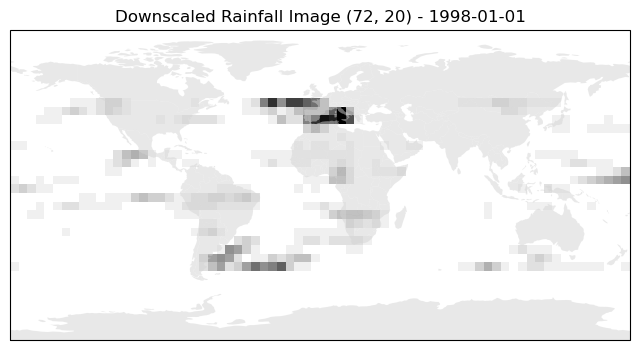

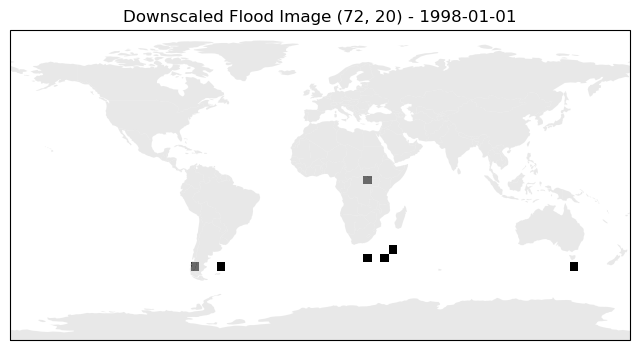

In [12]:
# Create a new figure with Cartopy projection for the downscaled rainfall image
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the downscaled rainfall image
ax.imshow(downscaled_rainfall_image, cmap='gray', extent=[-180, 180, -50, 50], transform=ccrs.PlateCarree())

# Plot the world map as the overlay
world.plot(ax=ax, color='lightgray', alpha=0.5)

# Set the title and axis labels
rainfall_title = f"Downscaled Rainfall Image {downscaled_resolution} - {rainfall_date}"
plt.title(rainfall_title)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.savefig("rainfall_image_downscaled_map.png")
plt.show()

# Create a new figure with Cartopy projection for the downscaled flood image
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the downscaled flood image
ax.imshow(downscaled_flood_image, cmap='gray', extent=[-180, 180, -50, 50], transform=ccrs.PlateCarree())

# Plot the world map as the overlay
world.plot(ax=ax, color='lightgray', alpha=0.5)

# Set the title and axis labels
flood_title = f"Downscaled Flood Image {downscaled_resolution} - {flood_date}"
plt.title(flood_title)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.savefig("flood_image_downscaled_map.png")
plt.show()

In [13]:
# Constants for pixel size and Earth's radius
original_pixel_size_deg = 0.25
resized_image_size = downscaled_resolution

# Calculate the pixel size in degrees for the resized image
resized_pixel_size_deg = original_pixel_size_deg * (1440 / resized_image_size[0])

# Calculate the pixel size in km² for the resized image
earth_radius_km = 6371  # Mean radius of the Earth in kilometers
resized_pixel_size_km2 = math.pi * (resized_pixel_size_deg * earth_radius_km / 180) ** 2

# Display the pixel size in km² for the resized image
print(f"Pixel size for resized image: {resized_pixel_size_km2:.2f} km²")

Pixel size for resized image: 98392.07 km²


In [14]:
print(torch.__version__)
print(torch.cuda.is_available())

2.0.0
True


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [16]:
# Check GPU availability and perform a simple computation on it
if torch.cuda.is_available():
    device = torch.device("cuda")
    tensor = torch.rand(3, 3).to(device)
    print("Computation result on GPU:", tensor.sum())
else:
    print("GPU is not available.")

Computation result on GPU: tensor(5.1520, device='cuda:0')


In [17]:
def load_rainfall_image(filename, target_resolution=downscaled_resolution):
    #print("Loading rainfall image:", filename)
    image = Image.open(filename).convert("L")  # Convert to grayscale
    #print("Original rainfall image shape:", image.size)

    # Downscale the image to the target resolution
    downscaled_image = downscale_image(image, target_resolution)
    #print("Downscaled rainfall image shape:", downscaled_image.size)

    array = np.array(downscaled_image, dtype=np.float32)
    normalized_array = 1.0 - array / 255.0  # Normalize and invert pixel values
    #print("Normalized and inverted rainfall image shape:", normalized_array.shape)

    return normalized_array

def load_flood_image(filename, target_resolution=downscaled_resolution):
    #print("Loading flood image:", filename)
    image = Image.open(filename).convert("L")  # Convert to grayscale
    #print("Original flood image shape:", image.size)

    # Downscale the image to the target resolution
    downscaled_image = downscale_image_with_black_pixels(image, target_resolution)
    #print("Downscaled flood image shape:", downscaled_image.size)

    array = np.array(downscaled_image, dtype=np.float32)
    normalized_array = 1.0 - array / 255.0  # Normalize and invert pixel values
    #print("Normalized and inverted flood image shape:", normalized_array.shape)

    return normalized_array

In [18]:
# Get a list of filenames for the rainfall and flood images
rainfall_filenames = [os.path.join(rainfall_images_set, filename) for filename in os.listdir(rainfall_images_set)]
flood_filenames = [os.path.join(flood_images_set, filename) for filename in os.listdir(flood_images_set)]

# Sort the lists based on the filenames
rainfall_filenames.sort()
flood_filenames.sort()

print(rainfall_filenames[:5])
print(flood_filenames[:5])

['/kaggle/input/rainfall-images/1998-01-01.png', '/kaggle/input/rainfall-images/1998-01-02.png', '/kaggle/input/rainfall-images/1998-01-03.png', '/kaggle/input/rainfall-images/1998-01-04.png', '/kaggle/input/rainfall-images/1998-01-05.png']
['/kaggle/input/flood-images/1998-01-01.png', '/kaggle/input/flood-images/1998-01-02.png', '/kaggle/input/flood-images/1998-01-03.png', '/kaggle/input/flood-images/1998-01-04.png', '/kaggle/input/flood-images/1998-01-05.png']


In [19]:
# Load and preprocess the images into NumPy arrays and extract dates
rainfall_images = []
flood_images = []
dates = []

for idx, (rainfall_filename, flood_filename) in enumerate(zip(rainfall_filenames, flood_filenames), start=1):
    # Load and preprocess the rainfall image
    rainfall_image = load_rainfall_image(rainfall_filename, downscaled_resolution)
    rainfall_images.append(rainfall_image)

    # Load and preprocess the flood image
    flood_image = load_flood_image(flood_filename, downscaled_resolution)
    flood_images.append(flood_image)

    # Extract date from rainfall image filename
    filename_without_extension = os.path.splitext(os.path.basename(rainfall_filename))[0]
    date_str = filename_without_extension[:10]  # Extract the first 10 characters as the date
    dates.append(date_str)

    # Print progress every 100 images processed
    if idx % 100 == 0:
        print(f"Processed {idx}/{len(rainfall_filenames)} images")

# Convert the lists of arrays to NumPy arrays
rainfall_images = np.array(rainfall_images)
flood_images = np.array(flood_images)
dates = np.array(dates)

Processed 100/8034 images
Processed 200/8034 images
Processed 300/8034 images
Processed 400/8034 images
Processed 500/8034 images
Processed 600/8034 images
Processed 700/8034 images
Processed 800/8034 images
Processed 900/8034 images
Processed 1000/8034 images
Processed 1100/8034 images
Processed 1200/8034 images
Processed 1300/8034 images
Processed 1400/8034 images
Processed 1500/8034 images
Processed 1600/8034 images
Processed 1700/8034 images
Processed 1800/8034 images
Processed 1900/8034 images
Processed 2000/8034 images
Processed 2100/8034 images
Processed 2200/8034 images
Processed 2300/8034 images
Processed 2400/8034 images
Processed 2500/8034 images
Processed 2600/8034 images
Processed 2700/8034 images
Processed 2800/8034 images
Processed 2900/8034 images
Processed 3000/8034 images
Processed 3100/8034 images
Processed 3200/8034 images
Processed 3300/8034 images
Processed 3400/8034 images
Processed 3500/8034 images
Processed 3600/8034 images
Processed 3700/8034 images
Processed 

In [20]:
# Now you have the downscaled rainfall and flood images as NumPy arrays stored in memory, along with dates
print("Downscaled Rainfall images shape:", rainfall_images.shape, rainfall_images.dtype)
print("Downscaled Flood images shape:", flood_images.shape, rainfall_images.dtype)
print("Dates shape:", dates.shape, rainfall_images.dtype)

Downscaled Rainfall images shape: (8034, 20, 72) float32
Downscaled Flood images shape: (8034, 20, 72) float32
Dates shape: (8034,) float32


In [21]:
# Print the first elements of the arrays and the corresponding date
print("First downscaled rainfall image:\n", rainfall_images[0])
print("First downscaled flood image:\n", flood_images[0])
print("Corresponding date:", dates[0])

First downscaled rainfall image:
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00392157 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00392157 0.         0.         ... 0.         0.         0.00392157]]
First downscaled flood image:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Corresponding date: 1998-01-01


In [22]:
class CustomMobileNetV2(models.MobileNetV2):
    def __init__(self, *args, **kwargs):
        super(CustomMobileNetV2, self).__init__(*args, **kwargs)
        self.classifier = nn.Identity()  # Replace the classifier with an identity layer

        # Modify the first layer to handle single-channel input
        weight = self.features[0][0].weight
        self.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.features[0][0].weight = torch.nn.Parameter(weight[:, 0:1, :, :])  # Use only the first channel

    def forward(self, x):
        # Pass the input through the MobileNet layers
        features = self.features(x)

        # Use AdaptiveAvgPool2d to obtain a 1x1 feature map
        feature_map = F.adaptive_avg_pool2d(features, 1)

        # Flatten the feature map to obtain the feature vector
        feature_vector = feature_map.view(features.size(0), -1)

        # Add a fully connected layer with two output neurons (weight and bias)
        classifier_output = self.classifier(feature_vector)

        return classifier_output

In [23]:
class RainfallMobileNet(nn.Module):
    def __init__(self, pretrained=True, downscaled_resolution=downscaled_resolution, dropout_prob=0.5):
        super(RainfallMobileNet, self).__init__()
        self.downscaled_resolution = (downscaled_resolution[1], downscaled_resolution[0])
        self.num_input_channels = 1  # For grayscale images

        # Create an instance of the MobileNetV2 model
        self.mobilenet = models.mobilenet_v2(pretrained=pretrained)
        
        # Modify the first layer to handle single-channel input
        self.mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Add a fully connected layer to transform the feature vector to the desired resolution
        self.fc = nn.Linear(1000, self.downscaled_resolution[0] * self.downscaled_resolution[1])

        # Initialize batch normalization layers with the correct dimensions
        self.bn1 = nn.BatchNorm2d(1)  # Change 32 to the actual number of output channels from your first Conv2d layer
        self.bn2 = nn.BatchNorm1d(1000)  # Use the number of features from your model
        
        # Add dropout layers
        self.dropout1 = nn.Dropout2d(dropout_prob)  # Apply dropout to the input image
        self.dropout2 = nn.Dropout(dropout_prob)    # Apply dropout to the feature vector
        
        # Add Multihead Attention layer
        self.attention = nn.MultiheadAttention(embed_dim=1000, num_heads=4)
        
    def forward(self, x):
        # Apply batch normalization to the input image
        x = self.bn1(x)

        # Apply dropout to the input image
        x = self.dropout1(x)

        # Pass the input (rainfall image) through the MobileNet layers
        feature_vector = self.mobilenet(x)

        # Reshape the feature vector to 2D tensor (batch_size, num_features)
        feature_vector = feature_vector.view(feature_vector.size(0), -1)
        
        # Apply Multihead Attention to the feature vector
        feature_vector = feature_vector.unsqueeze(0)  # Add sequence length dimension
        attention_output, _ = self.attention(feature_vector, feature_vector, feature_vector)
        feature_vector = attention_output.squeeze(0)  # Remove sequence length dimension
        
        # Transform the feature vector to the desired resolution
        feature_map = feature_vector

        # Apply batch normalization to the feature vector
        feature_vector = self.bn2(feature_vector)

        # Apply dropout to the feature vector
        feature_vector = self.dropout2(feature_vector)

        # Reshape feature_map to match the desired output shape (batch_size, 1, 20, 72)
        feature_map_reshape = self.fc(feature_vector)
        predicted_images = feature_map_reshape.view(feature_vector.size(0), 1, *self.downscaled_resolution)
        
        #predicted_images = torch.round(torch.sigmoid(predicted_images))
        #predicted_images = F.silu(predicted_images)
        #predicted_images = F.gelu(predicted_images)

        return feature_map, predicted_images

In [24]:
class RainfallDataset(Dataset):
    def __init__(self, rainfall_images, flood_images, dates):
        self.rainfall_images = rainfall_images
        self.flood_images = flood_images
        self.dates = dates

    def __len__(self):
        return len(self.rainfall_images)

    def normalize_rainfall(self, image):
        min_value = np.min(image)
        max_value = np.max(image)
        normalized_image = (image - min_value) / (max_value - min_value)
        return normalized_image

    def __getitem__(self, idx):
        # Get the corresponding images and date
        rainfall_image = self.rainfall_images[idx]
        flood_image = self.flood_images[idx]
        date = self.dates[idx] 

        # Normalize rainfall image
        normalized_rainfall = self.normalize_rainfall(rainfall_image)

        # Convert images to tensors
        rainfall_tensor = torch.tensor(normalized_rainfall, dtype=torch.float32).unsqueeze(0)
        flood_tensor = torch.tensor(flood_image, dtype=torch.float32).unsqueeze(0)

        return rainfall_tensor, flood_tensor, date

In [25]:
def split_data_cnn(rainfall_images, flood_images, dates, train_start_year, valid_start_year, test_start_year):
    # Create dictionaries to store the arrays for each set
    all_data = {'rainfall': [], 'flood': [], 'dates': []}
    train_data = {'rainfall': [], 'flood': [], 'dates': []}
    valid_data = {'rainfall': [], 'flood': [], 'dates': []}
    test_data = {'rainfall': [], 'flood': [], 'dates': []}
    
    # Function to check if the filename year is within a specific range
    def is_within_range(date, start_year, end_year):
        year = int(date[:4])
        return start_year <= year <= end_year
    
    # Split the data into training, validation, and test sets
    for i in range(len(dates)):
        date = dates[i]
        rainfall_image = rainfall_images[i]
        flood_image = flood_images[i]

        if is_within_range(date, train_start_year, valid_start_year - 1):
            train_data['rainfall'].append(rainfall_image)
            train_data['flood'].append(flood_image)
            train_data['dates'].append(date)
        elif is_within_range(date, valid_start_year, test_start_year - 1):
            valid_data['rainfall'].append(rainfall_image)
            valid_data['flood'].append(flood_image)
            valid_data['dates'].append(date)
        else:
            test_data['rainfall'].append(rainfall_image)
            test_data['flood'].append(flood_image)
            test_data['dates'].append(date)
            
        all_data['rainfall'].append(rainfall_image)
        all_data['flood'].append(flood_image)
        all_data['dates'].append(date)
    
    return all_data, train_data, valid_data, test_data

In [26]:
# Define batch size for data loaders
batch_size = 32

# Suggested split based on a 70-15-15 ratio for training, validation, and test sets
train_start_year = 1998
valid_start_year = 2012
test_start_year = 2016

# Split the data into datasets
all_cnn, train_cnn, valid_cnn, test_cnn = split_data_cnn(rainfall_images, flood_images, dates, train_start_year, valid_start_year, test_start_year)

# Create datasets and data loaders for train, valid, and test sets
all_dataset = RainfallDataset(all_cnn['rainfall'], all_cnn['flood'], all_cnn['dates'])
train_dataset = RainfallDataset(train_cnn['rainfall'], train_cnn['flood'], train_cnn['dates'])
valid_dataset = RainfallDataset(valid_cnn['rainfall'], valid_cnn['flood'], valid_cnn['dates'])
test_dataset = RainfallDataset(test_cnn['rainfall'], test_cnn['flood'], test_cnn['dates'])

def custom_collate(batch):
    # Transpose the list of samples to get a list of individual elements for each batch item
    transposed = list(zip(*batch))
    
    # Convert datetime.date objects to numerical values
    dates = [sample for sample in transposed[2]]
    
    # Construct batch tensors for rainfall and flood images
    rainfall_tensors = torch.stack(transposed[0])
    flood_tensors = torch.stack(transposed[1])
    
    return rainfall_tensors, flood_tensors, dates

# Create data loaders using the custom collate function
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)

# Check the number of samples in each dataset
print("Number of samples in all_loader dataset:", len(all_loader.dataset))
print("Number of samples in train_loader dataset:", len(train_loader.dataset))
print("Number of samples in valid_loader dataset:", len(valid_loader.dataset))
print("Number of samples in test_loader dataset:", len(test_loader.dataset))

Number of samples in all_loader dataset: 8034
Number of samples in train_loader dataset: 5113
Number of samples in valid_loader dataset: 1461
Number of samples in test_loader dataset: 1460


All Loader - Shape of the batch tensor:
torch.Size([32, 1, 20, 72])
torch.Size([32, 1, 20, 72])

All Loader - First few values of the first rainfall image:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625,
        0.0625, 0.1250, 0.1875, 0.1875, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0625, 0.1250, 0.5000, 0.8125, 0.4375, 0.7500, 0.7500, 0.6250, 0.5625,
        0.3125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625,
        0.0625, 0.0625, 0.1875, 0.1875, 0.1250, 0.1250, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625, 0.1250, 0.1875, 0.1250,
        0.0625, 0.1250, 0.1875, 0.1250, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.00

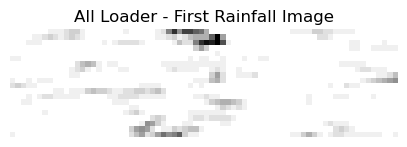

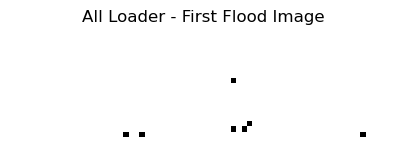

Train Loader - Shape of the batch tensor:
torch.Size([32, 1, 20, 72])
torch.Size([32, 1, 20, 72])

Train Loader - First few values of the first rainfall image:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625,
        0.0625, 0.1250, 0.1875, 0.1875, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0625, 0.1250, 0.5000, 0.8125, 0.4375, 0.7500, 0.7500, 0.6250, 0.5625,
        0.3125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625,
        0.0625, 0.0625, 0.1875, 0.1875, 0.1250, 0.1250, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625, 0.1250, 0.1875, 0.1250,
        0.0625, 0.1250, 0.1875, 0.1250, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

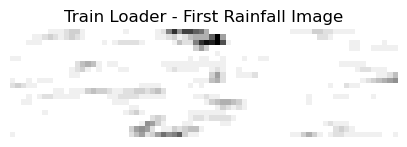

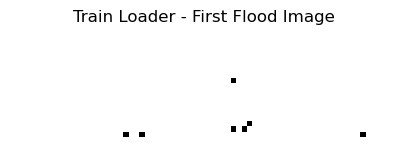

Valid Loader - Shape of the batch tensor:
torch.Size([32, 1, 20, 72])
torch.Size([32, 1, 20, 72])

Valid Loader - First few values of the first rainfall image:
tensor([0.2000, 0.2000, 0.2000, 0.1000, 0.1000, 0.1000, 0.2000, 0.2000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000,
        0.4000, 0.9000, 0.9000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000, 0.3000, 0.3000,
        0.3000, 0.4000, 0.4000, 0.4000, 0.4000, 0.2000, 0.1000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.1000, 0.1000, 0.2000, 

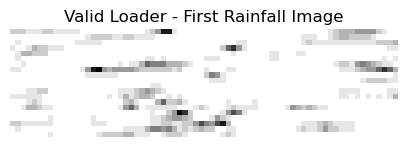

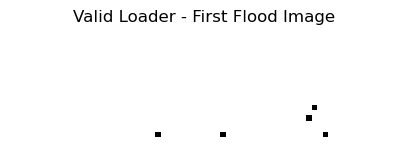

Test Loader - Shape of the batch tensor:
torch.Size([32, 1, 20, 72])
torch.Size([32, 1, 20, 72])

Test Loader - First few values of the first rainfall image:
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.1538, 0.3846, 0.3077, 0.0769, 0.0769, 0.2308,
        0.1538, 0.0769, 0.2308, 0.3846, 0.2308, 0.1538, 0.0769, 0.0769, 0.0769,
        0.1538, 0.4615, 0.6154, 0.6154, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.

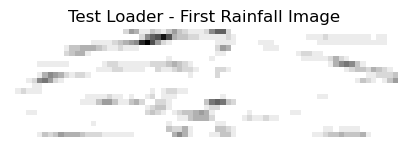

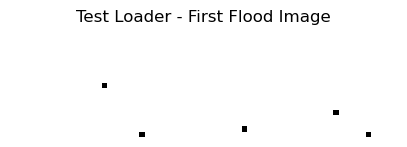

In [27]:
def get_first_few_values(tensor, num_values=100):
    return tensor.view(-1)[:num_values]

# Iterate through the data loaders and print the shape of the batch tensor and the first few values of the first image in each loader
for loader_name, data_loader in [('All Loader', all_loader), ('Train Loader', train_loader), ('Valid Loader', valid_loader), ('Test Loader', test_loader)]:
    # Get the first batch from the data loader
    batch = next(iter(data_loader))
    # Extract the rainfall tensor from the batch
    rainfall_tensor = batch[0]
    # Extract the flood tensor from the batch
    flood_tensor = batch[1]
    
    # Print the shape of the batch tensor
    print(f"{loader_name} - Shape of the batch tensor:")
    print(rainfall_tensor.shape)
    print(flood_tensor.shape)
    print()
    
    # Print the first few values of the rainfall tensor
    print(f"{loader_name} - First few values of the first rainfall image:")
    print(get_first_few_values(rainfall_tensor))
    print()
    
    # Print the first few values of the flood tensor
    print(f"{loader_name} - First few values of the first flood image:")
    print(get_first_few_values(flood_tensor))
    print()
    
    # Display the first rainfall image
    first_rainfall_image = TF.to_pil_image(rainfall_tensor[0].squeeze())
    plt.figure(figsize=(5, 5))
    plt.imshow(first_rainfall_image, cmap='binary')
    plt.title(f"{loader_name} - First Rainfall Image")
    plt.axis('off')
    plt.show()
    
    # Display the first flood image
    first_flood_image = TF.to_pil_image(flood_tensor[0].squeeze())
    plt.figure(figsize=(5, 5))
    plt.imshow(first_flood_image, cmap='binary')
    plt.title(f"{loader_name} - First Flood Image")
    plt.axis('off')
    plt.show()

In [28]:
def date_string_to_tensor(date_str):
    # Convert the date string into a Python datetime object
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')

    # Extract year, month, and day components
    year = date_obj.year
    month = date_obj.month
    day = date_obj.day

    # Create one-hot encoded tensors for year, month, and day
    year_tensor = torch.zeros(22, dtype=torch.float32)
    year_tensor[year - 1998] = 1.0

    month_tensor = torch.zeros(12, dtype=torch.float32)
    month_tensor[month - 1] = 1.0

    day_tensor = torch.zeros(31, dtype=torch.float32)
    day_tensor[day - 1] = 1.0

    # Concatenate the three one-hot tensors to create the final tensor
    date_tensor = torch.cat([year_tensor, month_tensor, day_tensor], dim=0)

    return date_tensor

# Example usage:
date_str = '1998-01-01'
date_tensor = date_string_to_tensor(date_str)
print(date_tensor.shape)  # Should be torch.Size([65])

torch.Size([65])


In [29]:
# Calculate the class distribution within each image for the positive class
positive_class_counts = torch.zeros(1)
for batch in train_loader:
    _, flood_batch, _ = batch
    positive_class_counts += (flood_batch == 1).sum()  # Assuming 1 represents the positive class (flooded pixels)
positive_class_weight = 1 / (positive_class_counts + 1e-7)  # Adding epsilon to avoid division by zero

In [30]:
# Convert the list of lists to a NumPy array
flood_array = np.array(all_cnn["flood"])

# Calculate the total number of pixels in the entire dataset
total_pixels = flood_array.size

print(total_pixels)

# Calculate the total number of positive class pixels (flooded pixels) in the entire dataset
total_positive_pixels = np.sum(flood_array)

total_negative_pixels = total_pixels - total_positive_pixels

print(total_positive_pixels)
print(total_negative_pixels)

# Calculate the weights for both positive and negative classes
positive_class_weight = total_negative_pixels / total_positive_pixels

# Use the positive and negative class weights in your BCEWithLogitsLoss for both CNN and RNN
class_weight = torch.tensor([positive_class_weight], dtype=torch.float).to(device)

print(class_weight)

11568960
39278.0
11529682.0
tensor([293.5405], device='cuda:0')


In [31]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Weighting factor for positive class
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none')
        pt = torch.exp(-ce_loss)  # Probability of true class
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [32]:
# Initialize the RainfallMobileNet model with specified weights and biases
model = RainfallMobileNet(pretrained=True)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
#criterion = nn.MSELoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0))
#criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
#criterion = FocalLoss(alpha=1, gamma=1, reduction='mean')
# Create the optimizer with L2 regularization
learning_rate = 0.001
weight_decay = 1e-5  # Adjust the weight decay value as needed
# Gradient clipping
max_grad_norm = 1.0  # Adjust as needed
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
output_size = downscaled_resolution[0]*downscaled_resolution[1]

# Set the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 77.1MB/s]


In [33]:
new_cnn = 1

100%|██████████| 46/46 [00:00<00:00, 46.22batch/s, loss=0.0496]


Epoch [1/100], Train Loss: 0.3778, Valid Loss: 0.0484
Best model state saved at epoch 1


100%|██████████| 46/46 [00:00<00:00, 58.51batch/s, loss=0.0211]


Epoch [2/100], Train Loss: 0.0380, Valid Loss: 0.0193
Best model state saved at epoch 2


100%|██████████| 46/46 [00:00<00:00, 59.24batch/s, loss=0.019] 


Epoch [3/100], Train Loss: 0.0241, Valid Loss: 0.0164
Best model state saved at epoch 3


100%|██████████| 46/46 [00:00<00:00, 58.68batch/s, loss=0.0171] 


Epoch [4/100], Train Loss: 0.0225, Valid Loss: 0.0157
Best model state saved at epoch 4


100%|██████████| 46/46 [00:00<00:00, 58.57batch/s, loss=0.0163] 


Epoch [5/100], Train Loss: 0.0210, Valid Loss: 0.0152
Best model state saved at epoch 5


100%|██████████| 46/46 [00:00<00:00, 60.15batch/s, loss=0.0161] 


Epoch [6/100], Train Loss: 0.0206, Valid Loss: 0.0147
Best model state saved at epoch 6


100%|██████████| 46/46 [00:00<00:00, 60.03batch/s, loss=0.0167] 


Epoch [7/100], Train Loss: 0.0210, Valid Loss: 0.0151


100%|██████████| 46/46 [00:00<00:00, 58.61batch/s, loss=0.0163] 


Epoch [8/100], Train Loss: 0.0206, Valid Loss: 0.0148


100%|██████████| 46/46 [00:00<00:00, 60.24batch/s, loss=0.0238] 


Epoch [9/100], Train Loss: 0.0215, Valid Loss: 0.0176


100%|██████████| 46/46 [00:01<00:00, 40.52batch/s, loss=0.0158] 


Epoch [10/100], Train Loss: 0.0210, Valid Loss: 0.0146
Best model state saved at epoch 10


100%|██████████| 46/46 [00:00<00:00, 59.99batch/s, loss=0.0163] 


Epoch [11/100], Train Loss: 0.0207, Valid Loss: 0.0148


100%|██████████| 46/46 [00:00<00:00, 59.46batch/s, loss=0.0168] 


Epoch [12/100], Train Loss: 0.0207, Valid Loss: 0.0151


100%|██████████| 46/46 [00:00<00:00, 60.29batch/s, loss=0.0174] 


Epoch [13/100], Train Loss: 0.0213, Valid Loss: 0.0157


100%|██████████| 46/46 [00:00<00:00, 60.23batch/s, loss=0.0162] 


Epoch [14/100], Train Loss: 0.0208, Valid Loss: 0.0149
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 46/46 [00:00<00:00, 58.76batch/s, loss=0.0154] 


Epoch [15/100], Train Loss: 0.0200, Valid Loss: 0.0143
Best model state saved at epoch 15


100%|██████████| 46/46 [00:00<00:00, 59.54batch/s, loss=0.0158] 


Epoch [16/100], Train Loss: 0.0197, Valid Loss: 0.0144


100%|██████████| 46/46 [00:00<00:00, 58.74batch/s, loss=0.0155] 


Epoch [17/100], Train Loss: 0.0205, Valid Loss: 0.0144


100%|██████████| 46/46 [00:00<00:00, 59.35batch/s, loss=0.0159] 


Epoch [18/100], Train Loss: 0.0198, Valid Loss: 0.0144


100%|██████████| 46/46 [00:00<00:00, 50.11batch/s, loss=0.0158] 


Epoch [19/100], Train Loss: 0.0198, Valid Loss: 0.0144
Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 46/46 [00:00<00:00, 58.78batch/s, loss=0.0153] 


Epoch [20/100], Train Loss: 0.0193, Valid Loss: 0.0141
Best model state saved at epoch 20


100%|██████████| 46/46 [00:00<00:00, 60.21batch/s, loss=0.0153] 


Epoch [21/100], Train Loss: 0.0192, Valid Loss: 0.0141


100%|██████████| 46/46 [00:00<00:00, 58.50batch/s, loss=0.0153] 


Epoch [22/100], Train Loss: 0.0194, Valid Loss: 0.0141


100%|██████████| 46/46 [00:00<00:00, 56.48batch/s, loss=0.0155] 


Epoch [23/100], Train Loss: 0.0195, Valid Loss: 0.0144


100%|██████████| 46/46 [00:00<00:00, 58.73batch/s, loss=0.0153] 


Epoch [24/100], Train Loss: 0.0193, Valid Loss: 0.0141
Best model state saved at epoch 24


100%|██████████| 46/46 [00:00<00:00, 58.91batch/s, loss=0.0152] 


Epoch [25/100], Train Loss: 0.0191, Valid Loss: 0.0141
Best model state saved at epoch 25


100%|██████████| 46/46 [00:00<00:00, 51.19batch/s, loss=0.0152] 


Epoch [26/100], Train Loss: 0.0191, Valid Loss: 0.0140
Best model state saved at epoch 26


100%|██████████| 46/46 [00:00<00:00, 55.07batch/s, loss=0.0154] 


Epoch [27/100], Train Loss: 0.0192, Valid Loss: 0.0142


100%|██████████| 46/46 [00:01<00:00, 38.96batch/s, loss=0.0153] 


Epoch [28/100], Train Loss: 0.0191, Valid Loss: 0.0141


100%|██████████| 46/46 [00:00<00:00, 59.23batch/s, loss=0.0152] 


Epoch [29/100], Train Loss: 0.0191, Valid Loss: 0.0141


100%|██████████| 46/46 [00:00<00:00, 57.78batch/s, loss=0.0153] 


Epoch [30/100], Train Loss: 0.0191, Valid Loss: 0.0142
Epoch 00030: reducing learning rate of group 0 to 1.2500e-04.


100%|██████████| 46/46 [00:00<00:00, 57.76batch/s, loss=0.015]  


Epoch [31/100], Train Loss: 0.0188, Valid Loss: 0.0139
Best model state saved at epoch 31


100%|██████████| 46/46 [00:00<00:00, 59.31batch/s, loss=0.0151] 


Epoch [32/100], Train Loss: 0.0188, Valid Loss: 0.0140


100%|██████████| 46/46 [00:00<00:00, 53.55batch/s, loss=0.015]  


Epoch [33/100], Train Loss: 0.0187, Valid Loss: 0.0139
Best model state saved at epoch 33


100%|██████████| 46/46 [00:00<00:00, 57.51batch/s, loss=0.0149] 


Epoch [34/100], Train Loss: 0.0188, Valid Loss: 0.0138
Best model state saved at epoch 34


100%|██████████| 46/46 [00:00<00:00, 57.02batch/s, loss=0.015]  


Epoch [35/100], Train Loss: 0.0188, Valid Loss: 0.0140


100%|██████████| 46/46 [00:00<00:00, 58.40batch/s, loss=0.015]  


Epoch [36/100], Train Loss: 0.0188, Valid Loss: 0.0140


100%|██████████| 46/46 [00:00<00:00, 54.65batch/s, loss=0.0149] 


Epoch [37/100], Train Loss: 0.0189, Valid Loss: 0.0137
Best model state saved at epoch 37


100%|██████████| 46/46 [00:00<00:00, 57.39batch/s, loss=0.0152] 


Epoch [38/100], Train Loss: 0.0187, Valid Loss: 0.0146


100%|██████████| 46/46 [00:00<00:00, 58.38batch/s, loss=0.0152] 


Epoch [39/100], Train Loss: 0.0187, Valid Loss: 0.0141


100%|██████████| 46/46 [00:00<00:00, 47.71batch/s, loss=0.0149] 


Epoch [40/100], Train Loss: 0.0187, Valid Loss: 0.0138


100%|██████████| 46/46 [00:00<00:00, 59.00batch/s, loss=0.0151] 


Epoch [41/100], Train Loss: 0.0187, Valid Loss: 0.0140
Epoch 00041: reducing learning rate of group 0 to 6.2500e-05.


100%|██████████| 46/46 [00:00<00:00, 58.59batch/s, loss=0.015]  


Epoch [42/100], Train Loss: 0.0184, Valid Loss: 0.0140


100%|██████████| 46/46 [00:00<00:00, 59.22batch/s, loss=0.015]  


Epoch [43/100], Train Loss: 0.0184, Valid Loss: 0.0140


100%|██████████| 46/46 [00:00<00:00, 58.90batch/s, loss=0.0148] 


Epoch [44/100], Train Loss: 0.0183, Valid Loss: 0.0137


100%|██████████| 46/46 [00:00<00:00, 59.30batch/s, loss=0.0148] 


Epoch [45/100], Train Loss: 0.0182, Valid Loss: 0.0138
Epoch 00045: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 46/46 [00:01<00:00, 35.23batch/s, loss=0.0148] 


Epoch [46/100], Train Loss: 0.0180, Valid Loss: 0.0137


100%|██████████| 46/46 [00:00<00:00, 60.24batch/s, loss=0.0148] 


Epoch [47/100], Train Loss: 0.0180, Valid Loss: 0.0138
Stopping early as validation loss has not improved or stagnated for 10 consecutive epochs.


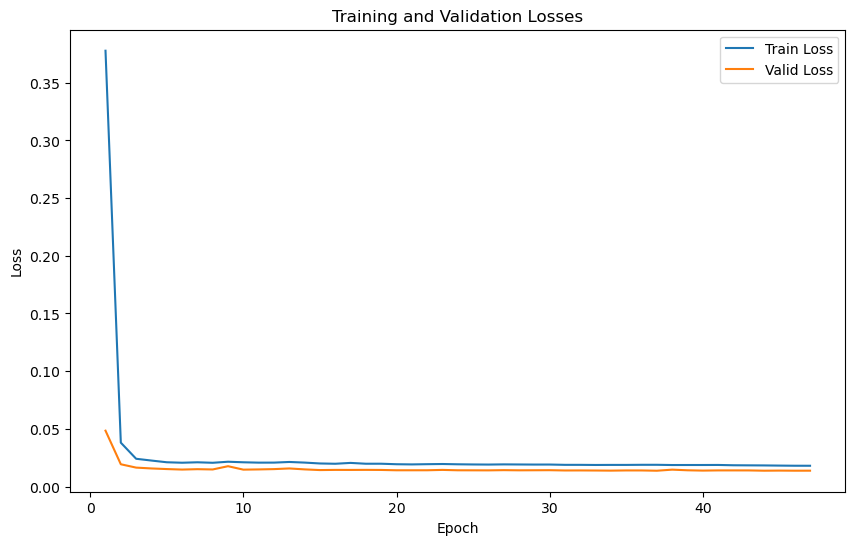

In [34]:
if new_cnn == 1:
    # Training loop
    num_epochs = 100
    train_losses = []
    valid_losses = []

    # Set the directory where you want to save the model state
    save_dir = "/kaggle/working/CNN_models"
    os.makedirs(save_dir, exist_ok=True)

    # Set the maximum number of epochs to wait for both lack of improvement and stagnation
    patience = 10

    # Keep track of the best validation loss and the corresponding epoch
    best_valid_loss = float('inf')
    best_epoch = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # Use tqdm to monitor progress in the training loop
        with tqdm(train_loader, unit="batch") as tepoch:
            for rainfall_batch, flood_batch, _ in tepoch:
                rainfall_batch, flood_batch = rainfall_batch.to(device), flood_batch.to(device)

                optimizer.zero_grad()

                # Pass the input (rainfall image) through the model
                _, predicted_images = model(rainfall_batch)

                # Calculate the loss
                loss = criterion(predicted_images, flood_batch)

                # Backpropagation and optimization
                loss.backward()

                # Clip gradients using nn.utils.clip_grad_norm_
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                optimizer.step()

                total_train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        # Calculate and store average training loss for this epoch
        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loop (assuming you have a validation set)
        model.eval()
        total_valid_loss = 0

        # Use tqdm to monitor progress in the validation loop
        with tqdm(valid_loader, unit="batch") as tepoch:
            with torch.no_grad():
                for rainfall_batch, flood_batch, _ in tepoch:
                    rainfall_batch, flood_batch = rainfall_batch.to(device), flood_batch.to(device)

                    # Pass the input (rainfall image) through the model
                    _, predicted_images = model(rainfall_batch)

                    # Calculate the loss
                    loss = criterion(predicted_images, flood_batch)

                    total_valid_loss += loss.item()
                    tepoch.set_postfix(loss=loss.item())

        # Calculate and store average validation loss for this epoch
        valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)

        # Print epoch-wise losses
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

        # Update the learning rate scheduler based on the validation loss
        scheduler.step(valid_loss)

        # Save the model state if the validation loss has improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0  # Reset the counter for lack of improvement
            model_path = os.path.join(save_dir, f"rainfall_mobilenet_best.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'valid_losses': valid_losses,
            }, model_path)
            print(f"Best model state saved at epoch {epoch + 1}")

        else:
            epochs_without_improvement += 1

        # Early stopping: If both lack of improvement and stagnation occur for the specified patience, stop training
        if epochs_without_improvement >= patience:
            print("Stopping early as validation loss has not improved or stagnated for {} consecutive epochs.".format(patience))
            break

    # Plot the losses over time
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.savefig("cnn_losses.png")
    plt.show()

In [35]:
 if new_cnn == 1:
    # Generate a file link for the best model
    best_cnn_link = FileLink(model_path)
    print("Download the best model:", best_cnn_link)

Download the best model: /kaggle/working/CNN_models/rainfall_mobilenet_best.pth


In [36]:
if new_cnn == 1:
    best_model_path = os.path.join(save_dir, f"rainfall_mobilenet_best.pth")
else:
    best_model_path = "/kaggle/input/cnn-model-1/rainfall_mobilenet_best.pth"
checkpoint = torch.load(best_model_path)

# Load the best model state
model_state_dict = checkpoint['model_state_dict']
model_dict = model.state_dict()

# Filter out the missing keys and load only the matching keys
model_state_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model_dict.update(model_state_dict)
model.load_state_dict(model_dict)

model.eval()

# Test the model on the test set and calculate the accuracy score
input_images = []
real_images = []
predicted_images = []

with torch.no_grad(), tqdm(test_loader, unit="batch") as ttest:
    for rainfall_batch, flood_batch, _, in ttest:
        rainfall_batch, flood_batch = rainfall_batch.to(device), flood_batch.to(device)
        
        # Pass the rainfall images to the model and get the predicted feature maps and images
        _, predicted_image = model(rainfall_batch)
        
        current_batch_size, sequence_length, _, _ = predicted_image.size()
        predicted_image = predicted_image.view(current_batch_size, sequence_length, downscaled_resolution[0]*downscaled_resolution[1])
        rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, downscaled_resolution[0]*downscaled_resolution[1])
        flood_batch = flood_batch.view(current_batch_size, sequence_length, downscaled_resolution[0]*downscaled_resolution[1])
        
        predicted_image = torch.round(torch.sigmoid(predicted_image))
        #predicted_image = torch.clamp(predicted_image, 0, 1)

        # Append the real and predicted flood images to their respective lists
        input_images.extend(rainfall_batch.cpu().numpy())
        real_images.extend(flood_batch.cpu().numpy())
        predicted_images.extend(predicted_image.cpu().numpy())

# Convert the lists to numpy arrays
input_images = np.array(input_images)
real_images = np.array(real_images)
predicted_images = np.array(predicted_images)

#messy_predicted_images = predicted_images

# Round the predicted images
#predicted_images = np.round(1 / (1 + np.exp(-predicted_images)))
#predicted_images = np.clip(predicted_images, 0, 1)  # Clipping

100%|██████████| 46/46 [00:00<00:00, 51.54batch/s]


In [37]:
print(input_images.shape)
print(real_images.shape)
print(predicted_images.shape)

# Print the first values in the first image for each set
print("First values in the first image for each set:")
print("Input Images:")
print(input_images[0, 0])
print("Real Images:")
print(real_images[0, 0])
print("Predicted Images:")
print(predicted_images[0, 0])
#print("Unnormalized Predicted Images:")
#print(messy_predicted_images[0, 0, 0])

(1460, 1, 1440)
(1460, 1, 1440)
(1460, 1, 1440)
First values in the first image for each set:
Input Images:
[0. 0. 0. ... 0. 0. 0.]
Real Images:
[0. 0. 0. ... 0. 0. 0.]
Predicted Images:
[0. 0. 0. ... 0. 0. 0.]


In [38]:
def calculate_metrics(real_img, pred_img):
    # Flatten the images and calculate precision, recall, F1-score, and support
    precision, recall, f1, support = precision_recall_fscore_support(
        real_img.flatten(), pred_img.flatten(), average='binary', zero_division=1
    )
    
    return precision, recall, f1, support

Best Prediction:


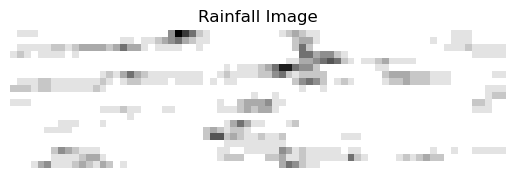

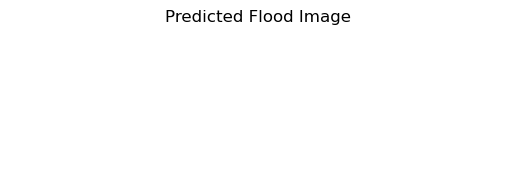

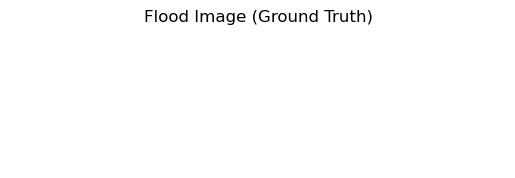

Best Image
F1-Score: 1.0000
Middle Prediction:


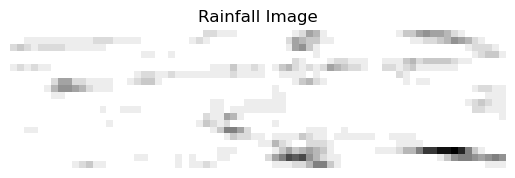

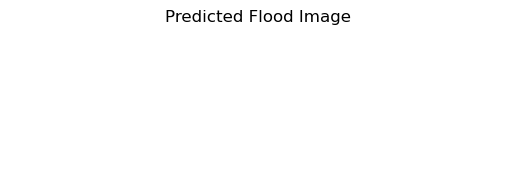

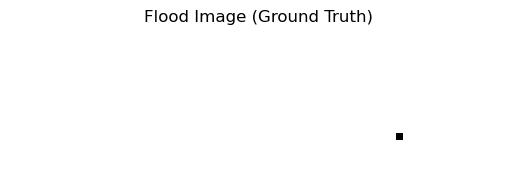

Middle Image
F1-Score: 0.0000
Worst Prediction:


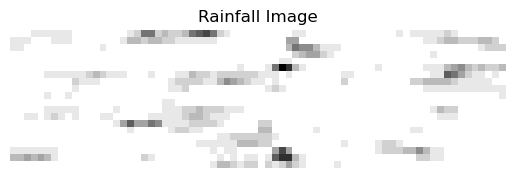

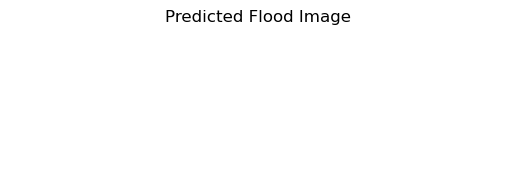

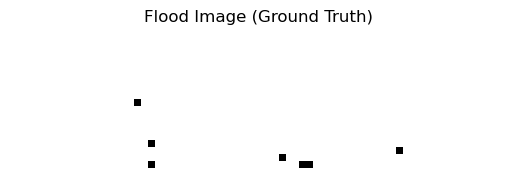

Worst Image
F1-Score: 0.0000
Average Precision: 1.0000, Average Recall: 0.0692, Average F1-Score: 0.0692


In [39]:
# Calculate metrics for all predicted flood images
metrics = [calculate_metrics(real_images[i, 0], predicted_images[i, 0]) for i in range(len(predicted_images))]

# Sort the images based on their F1-scores in descending order
sorted_indices = sorted(range(len(metrics)), key=lambda k: metrics[k][2], reverse=True)

# Display the best, middle, and worst predictions
best_n = 1
middle_n = 1
worst_n = 1

# Display the best prediction
print("Best Prediction:")
index = sorted_indices[0]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("best_rainfall_cnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("best_predicted_cnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("best_real_cnn.png")
plt.show()

print(f"Best Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the middle prediction
print("Middle Prediction:")
index = sorted_indices[len(sorted_indices) // 2]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("middle_rainfall_cnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("middle_predicted_cnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("middle_real_cnn.png")
plt.show()

print(f"Middle Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the worst prediction
print("Worst Prediction:")
index = sorted_indices[-1]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("worst_rainfall_cnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("worst_predicted_cnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("worst_real_cnn.png")
plt.show()

print(f"Worst Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Calculate the average metrics for all predicted flood images
precision_scores = [m[0] for m in metrics]
recall_scores = [m[1] for m in metrics]
f1_scores = [m[2] for m in metrics]
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)
print(f"Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-Score: {average_f1:.4f}")

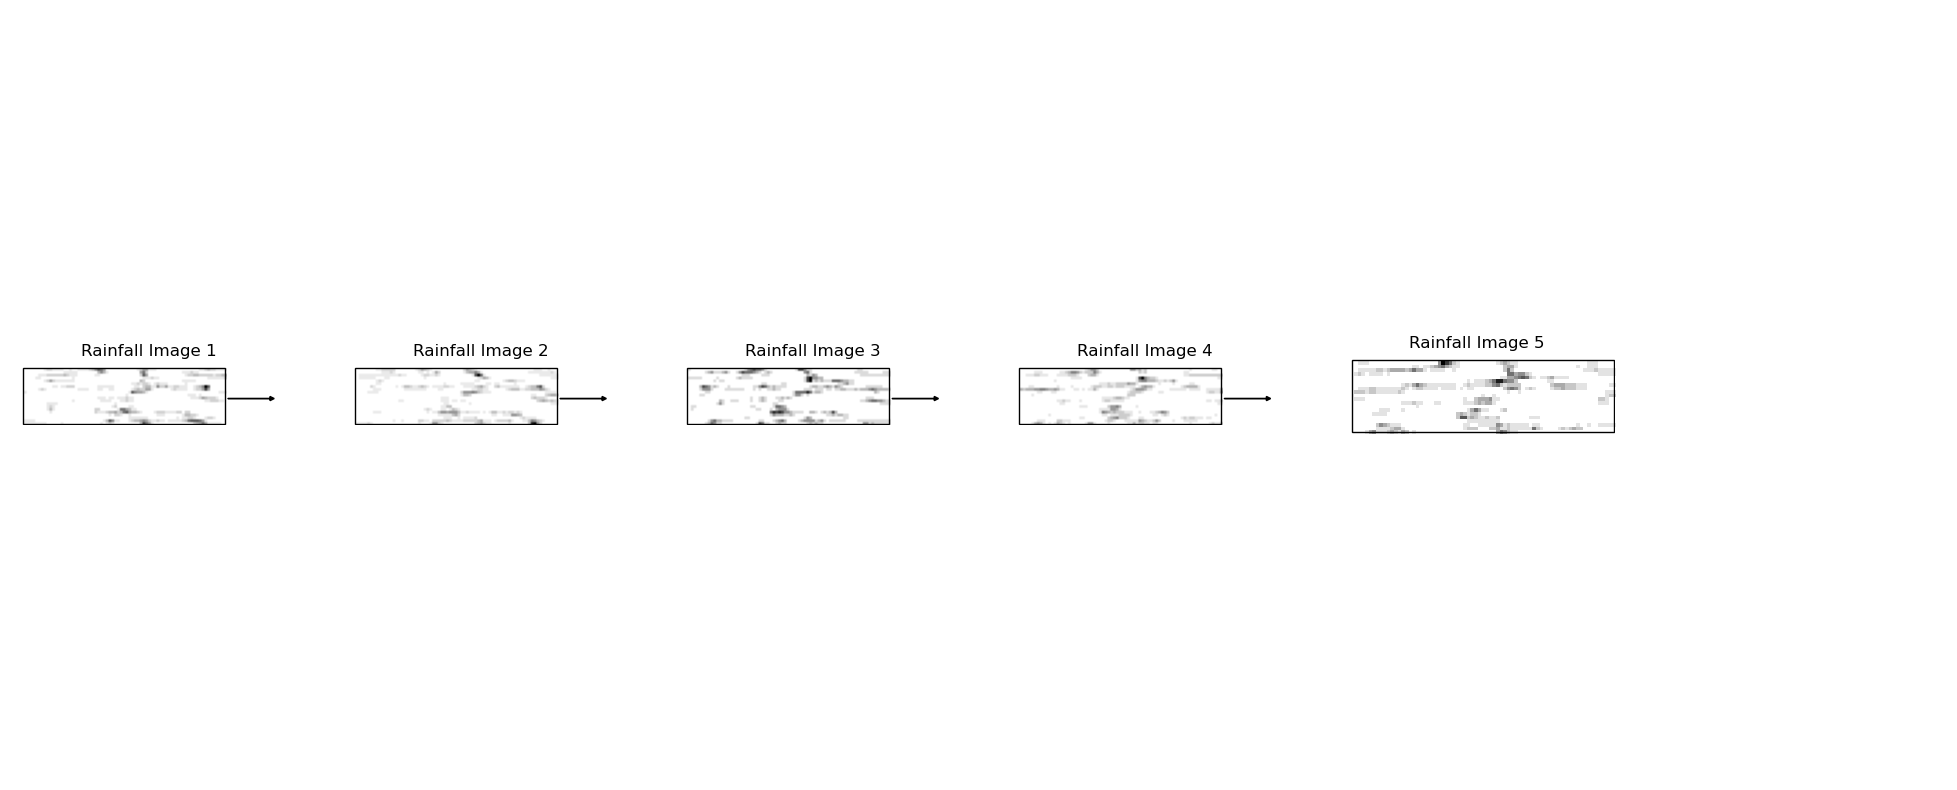

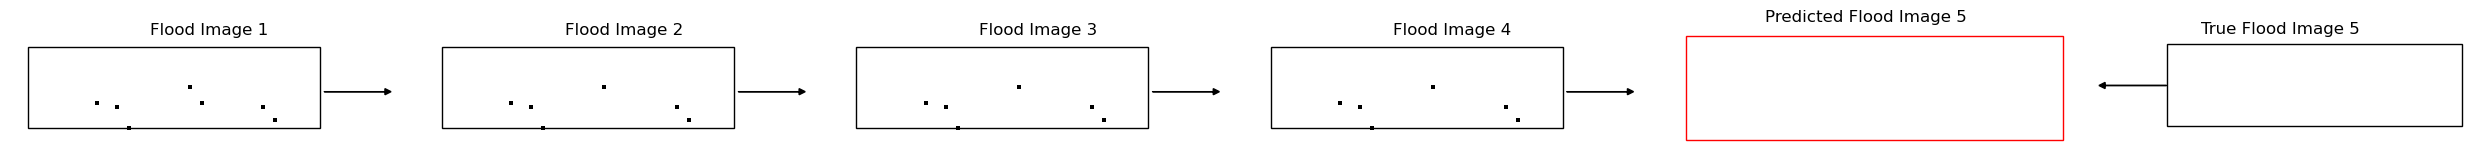

Example 316
F1-Score: 1.0000


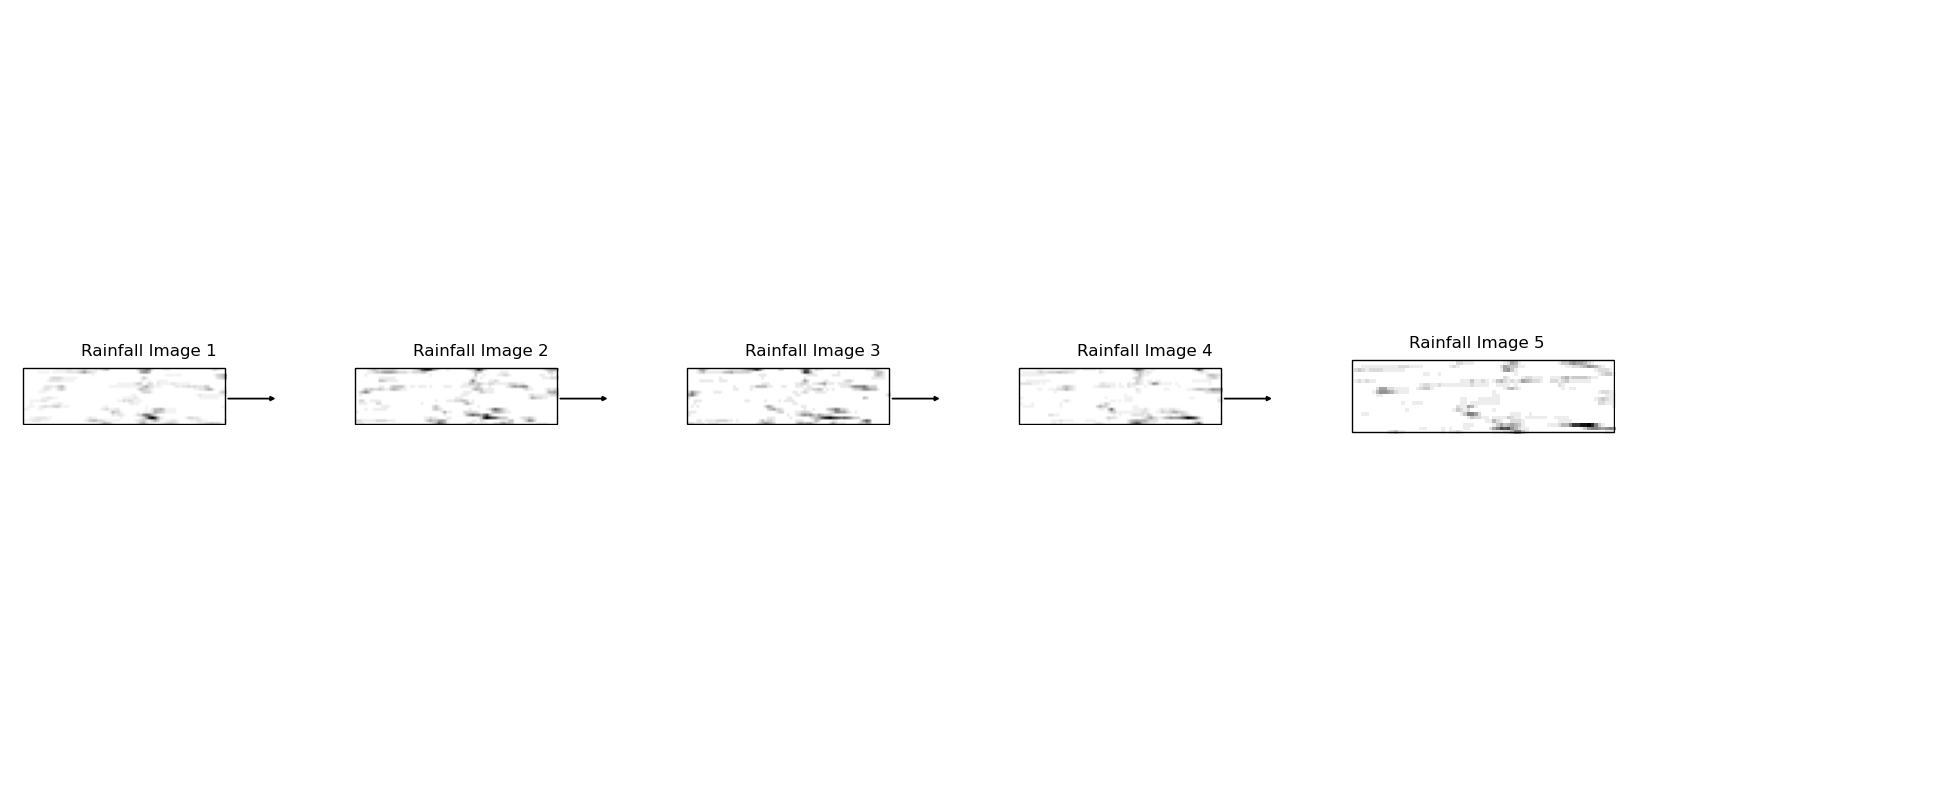

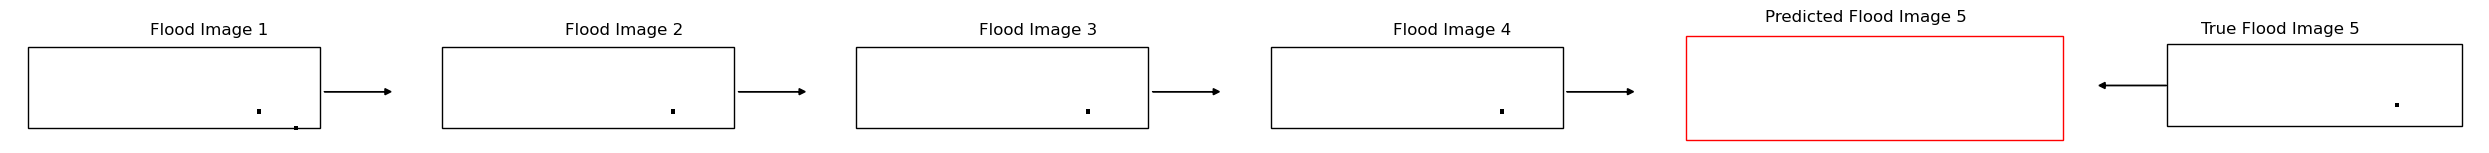

Example 661
F1-Score: 0.0000


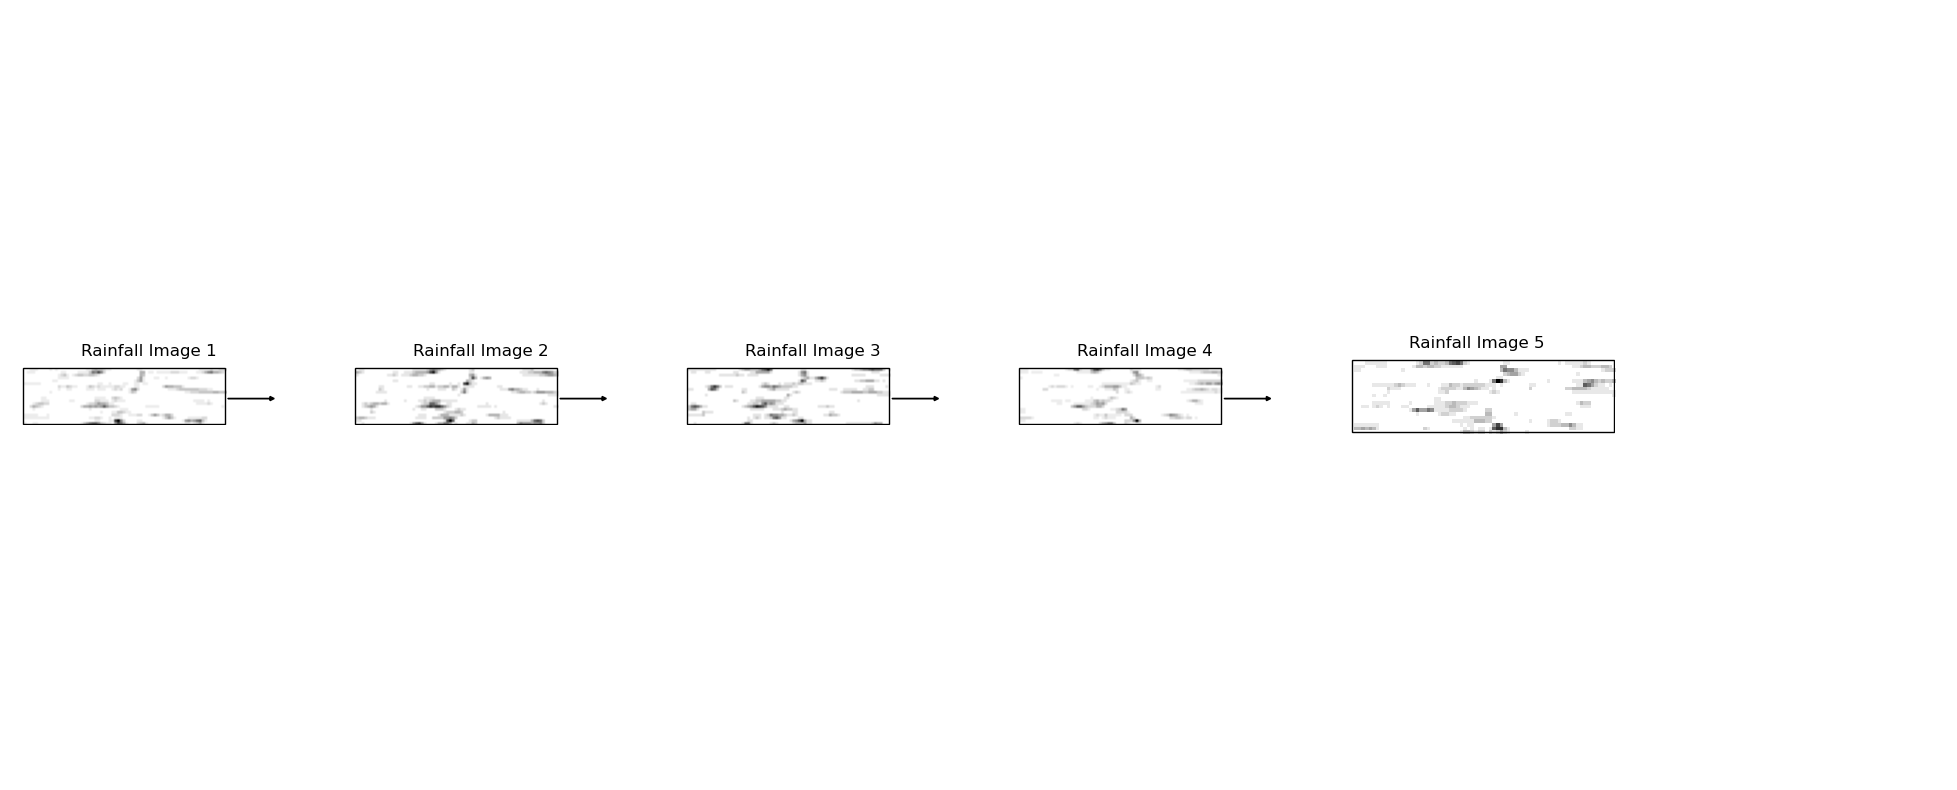

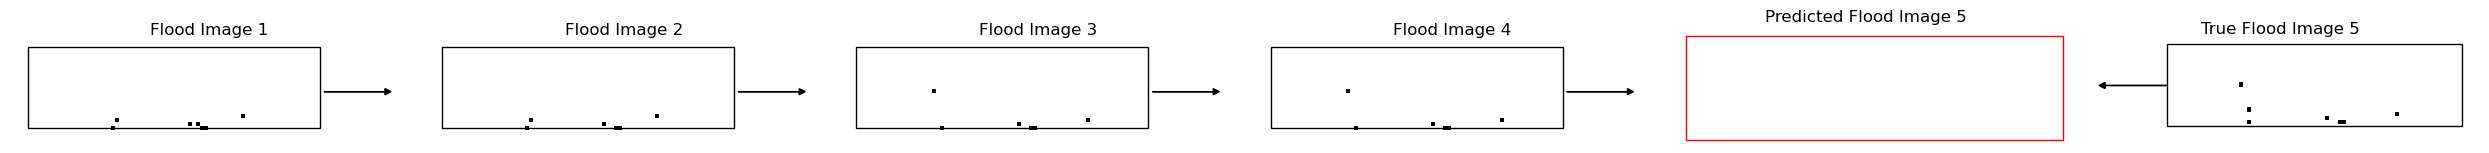

Example 1460
F1-Score: 0.0000


In [40]:
# Display examples of highest scoring, lowest scoring, and median scoring predictions
examples_indices = [sorted_indices[0], sorted_indices[len(sorted_indices) // 2], sorted_indices[-1]]
filenames = ["best", "middle", "worst"]
count = 0

for index in examples_indices:
    # Get the indices of the images for this example
    image_indices = [index - 4, index - 3, index - 2, index - 1, index, index]

    # Create two separate figures with a 1x6 layout
    fig1, axs1 = plt.subplots(1, 6, figsize=(25, 10))
    fig2, axs2 = plt.subplots(1, 6, figsize=(25, 10))
    
    plt.subplots_adjust(wspace=0.1)  # Adjust horizontal spacing

    for i, img_index in enumerate(image_indices):
        input_img = input_images[img_index, 0]
        real_img = real_images[img_index, 0]
        pred_img = predicted_images[img_index, 0]

        # Reshape and resize rainfall images to downscaled_resolution for display
        input_img_resized = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        real_img_resized = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        pred_img_resized = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

        # Convert NumPy arrays to images using PIL
        input_img_pil = Image.fromarray((input_img_resized * 255).astype(np.uint8), mode='L')
        real_img_pil = Image.fromarray((real_img_resized * 255).astype(np.uint8), mode='L')
        pred_img_pil = Image.fromarray((pred_img_resized * 255).astype(np.uint8), mode='L')

        if i <= 3:
            axs1[i].imshow(input_img_pil, cmap='binary')
            axs1[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs1[i].set_title('Rainfall Image '+str(i+1))
            axs1[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs1[i].axis('off')

            axs2[i].imshow(real_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs2[i].set_title('Flood Image '+str(i+1))
            axs2[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs2[i].axis('off')

        if i == 4:
            axs1[i].imshow(input_img_pil, cmap='binary')
            axs1[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs1[i].set_title('Rainfall Image '+str(i+1))
            axs1[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0.01, head_length=0, fc='white', ec='white')
            axs1[i].axis('off')

            axs2[i].imshow(pred_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='red'))
            axs2[i].set_title('Predicted Flood Image '+str(i+1))
            axs2[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0, head_length=0, fc='white', ec='white')
            axs2[i].axis('off')
            
        if i == 5:
            axs1[i].axis('off')

            axs2[i].imshow(real_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((0, 0), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs2[i].arrow(0, downscaled_resolution[1]/2, -15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs2[i].set_title('True Flood Image '+str(i))
            axs2[i].axis('off')

    plt.tight_layout()
    fig1.savefig(filenames[count]+"_cnn_rainfall_sequence.png")
    fig2.savefig(filenames[count]+"_cnn_flood_sequence.png")
    count+=1
    plt.show()

    print(f"Example {index + 1}")
    print(f"F1-Score: {metrics[index][2]:.4f}")
    print("=" * 50)

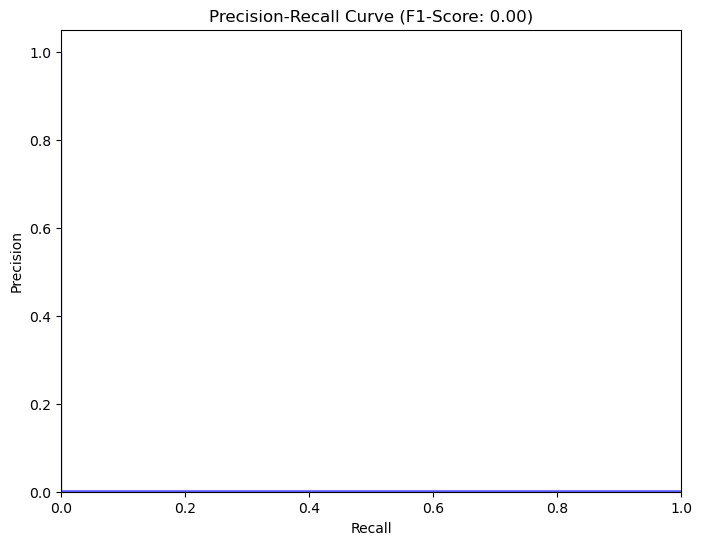

In [41]:
# Flatten the real and predicted images
real_labels = real_images.flatten()
predicted_scores = predicted_images.flatten()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(real_labels, predicted_scores)

# Calculate F1-score
f1 = f1_score(real_labels, np.round(predicted_scores))

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (F1-Score: {:.2f})'.format(f1))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.savefig("cnn_curve.png")
plt.show()

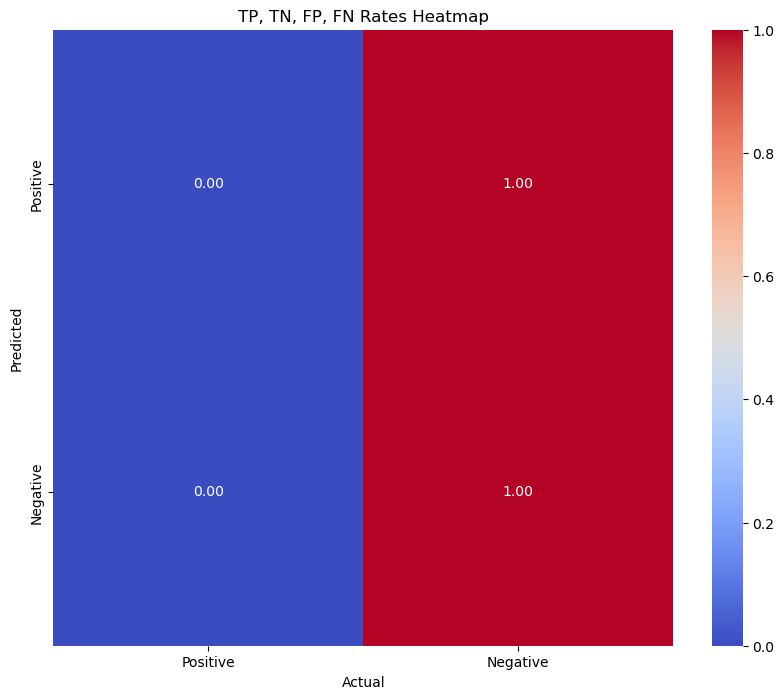

In [42]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(real_labels, np.round(predicted_scores))

# Calculate true positive (TP), true negative (TN), false positive (FP), false negative (FN) rates
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate rates
TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity/Recall)
TNR = TN / (TN + FP)  # True Negative Rate (Specificity)
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate

# Create heatmaps for TP, TN, FP, FN rates
rates = np.array([[TPR, FNR], [FPR, TNR]])

plt.figure(figsize=(10, 8))
sns.heatmap(rates, annot=True, fmt=".2f", cmap='coolwarm', center=0.5,
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('TP, TN, FP, FN Rates Heatmap')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig("cnn_heatmap.png")
plt.show()

In [43]:
dataset = all_dataset

if new_cnn == 1:
    best_model_path = os.path.join(save_dir, f"rainfall_mobilenet_best.pth")
else:
    best_model_path = "/kaggle/input/cnn-model-1/rainfall_mobilenet_best.pth"
checkpoint = torch.load(best_model_path)

# Load the best model state
model_state_dict = checkpoint['model_state_dict']
model_dict = model.state_dict()

# Filter out the missing keys and load only the matching keys
model_state_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model_dict.update(model_state_dict)
model.load_state_dict(model_dict)

# Set the model to evaluation mode
model.eval()

# Initialize an empty dictionary to store the extracted features with image names as keys
all_features_dict = {}

# Extract features from each image and generate the feature maps
with torch.no_grad():
    for idx in tqdm(range(len(dataset))):
        # Get a single image and its filename from the dataset
        image, goal, filename = dataset[idx]

        # Add a batch dimension to the image as the model expects batched input
        image = image.unsqueeze(0).to(device)

        # Extract features from the rainfall image using the model
        feature_map, predicted_image = model(image)

        # Convert features tensor to a numpy array and reshape it
        feature_map = np.array(feature_map[0].unsqueeze(0).cpu())

        # Resize the feature map to match the original image's size using interpolation
        # feature_map = cv2.resize(feature_map, downscaled_resolution[::-1], interpolation=cv2.INTER_LINEAR)

        # Rotate the feature map to match the original landscape orientation (72x20)
        # feature_map = np.rot90(feature_map, k=3)

        # Store the features for the image in the dictionary along with the date
        all_features_dict[filename] = {"feature_map": feature_map}

100%|██████████| 8034/8034 [00:56<00:00, 140.95it/s]


In [44]:
print(len(all_features_dict))

8034


In [45]:
# Print the first few keys of all_features_dict
first_few_keys = list(all_features_dict.keys())[:5]
print(first_few_keys)

['1998-01-01', '1998-01-02', '1998-01-03', '1998-01-04', '1998-01-05']


Original shape of the feature map: (1000,)


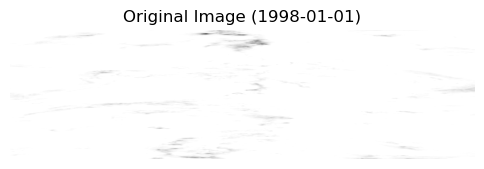

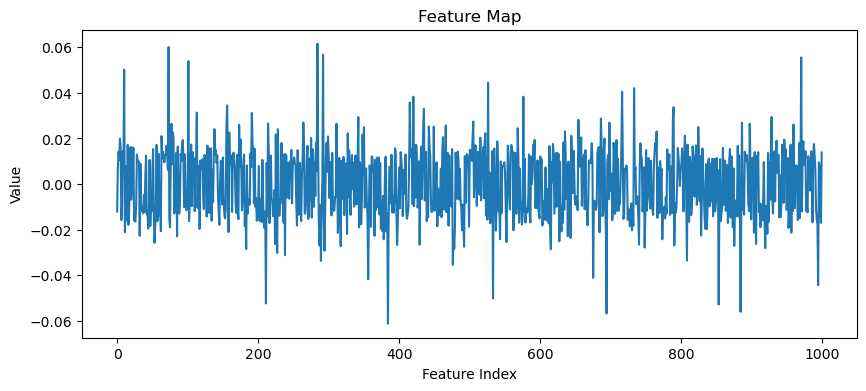

In [46]:
# Assuming all_features_dict contains feature vectors for different images
# Replace it with the actual variable name holding your dictionary of feature vectors
# The key for the feature vector of '1998-01-01.png'
image_key = '1998-01-01'

# Access the feature vector for the image '1998-01-01.png'
feature_of_image = all_features_dict[image_key]

# Convert the feature vector to a numpy array
feature_map = np.array(feature_of_image["feature_map"].squeeze(0))

# Print the original shape of the feature map
print("Original shape of the feature map:", feature_map.shape)

# Load and display the original image
image_path = rainfall_images_set + '/' + image_key + '.png'
image = Image.open(image_path).convert("L")

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Original Image (' + image_key + ')')
plt.axis('off')
plt.show()

# Display the feature map as a line graph
plt.figure(figsize=(10, 4))
plt.plot(feature_map)
plt.title('Feature Map')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.savefig("feature_map_example.png")
plt.show()

In [47]:
def split_data(rainfall_images, flood_images, dates, train_start_year, valid_start_year, test_start_year, feature_maps_dict):
    # Create dictionaries to store the arrays, dates, and feature maps for each set
    train_data = {'rainfall': [], 'flood': [], 'dates': [], 'feature_maps': []}
    valid_data = {'rainfall': [], 'flood': [], 'dates': [], 'feature_maps': []}
    test_data = {'rainfall': [], 'flood': [], 'dates': [], 'feature_maps': []}
    
    # Function to check if the date year is within a specific range
    def is_within_range(date, start_year, end_year):
        year = int(str(date)[:4])
        return start_year <= year <= end_year
    
    # Split the data into training, validation, and test sets
    for i in range(len(dates)):
        date = dates[i]
        rainfall_image = rainfall_images[i]
        flood_image = flood_images[i]
        
        if is_within_range(date, train_start_year, valid_start_year - 1):
            train_data['rainfall'].append(rainfall_image)
            train_data['flood'].append(flood_image)
            train_data['dates'].append(date)
        elif is_within_range(date, valid_start_year, test_start_year - 1):
            valid_data['rainfall'].append(rainfall_image)
            valid_data['flood'].append(flood_image)
            valid_data['dates'].append(date)
        else:
            test_data['rainfall'].append(rainfall_image)
            test_data['flood'].append(flood_image)
            test_data['dates'].append(date)
    
    # Loop through the feature maps and add the vectors to the appropriate dataset
    for date_key, feature_map in feature_maps_dict.items():
        year = int(date_key[:4])
        if is_within_range(year, train_start_year, valid_start_year - 1):
            train_data['feature_maps'].append(feature_map["feature_map"])
        elif is_within_range(year, valid_start_year, test_start_year - 1):
            valid_data['feature_maps'].append(feature_map["feature_map"])
        else:
            test_data['feature_maps'].append(feature_map["feature_map"])
    
    return train_data, valid_data, test_data

In [48]:
# Split the data into train, validation, and test sets
train_data, valid_data, test_data = split_data(rainfall_images, flood_images, dates, train_start_year, valid_start_year, test_start_year, all_features_dict)

In [49]:
def print_dataset_info(data_dict):
    # Get the shapes of the first entries of each subdictionary
    first_rainfall_shape = data_dict['rainfall'][0].shape if data_dict['rainfall'] else "N/A"
    first_flood_shape = data_dict['flood'][0].shape if data_dict['flood'] else "N/A"
    first_date = data_dict['dates'][0] if data_dict['dates'] else "N/A"
    first_feature_map_shape = data_dict['feature_maps'][0].shape if data_dict['feature_maps'] else "N/A"

    # Print the information
    print("Shape of the first entries:")
    print(f"Shape of the first rainfall image: {first_rainfall_shape}")
    print(f"Shape of the first flood image: {first_flood_shape}")
    print(f"First date: {first_date}")
    print(f"Shape of the first feature map: {first_feature_map_shape}")
    print()

In [50]:
print("Training Dataset:")
print_dataset_info(train_data)

Training Dataset:
Shape of the first entries:
Shape of the first rainfall image: (20, 72)
Shape of the first flood image: (20, 72)
First date: 1998-01-01
Shape of the first feature map: (1, 1000)



In [51]:
print("Validation Dataset:")
print_dataset_info(valid_data)

Validation Dataset:
Shape of the first entries:
Shape of the first rainfall image: (20, 72)
Shape of the first flood image: (20, 72)
First date: 2012-01-01
Shape of the first feature map: (1, 1000)



In [52]:
print("Test Dataset:")
print_dataset_info(test_data)

Test Dataset:
Shape of the first entries:
Shape of the first rainfall image: (20, 72)
Shape of the first flood image: (20, 72)
First date: 2016-01-01
Shape of the first feature map: (1, 1000)



In [53]:
class RainfallFloodFeatureDataset(Dataset):
    def __init__(self, rainfall_images, flood_images, feature_maps, dates, sequence_length=5):
        self.rainfall_images = rainfall_images
        self.flood_images = flood_images
        self.feature_maps = feature_maps
        self.dates = dates
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.rainfall_images) - self.sequence_length

    def normalize_rainfall(self, image):
        min_value = np.min(image)
        max_value = np.max(image)
        normalized_image = (image - min_value) / (max_value - min_value)
        return normalized_image
    
    def date_to_tensor(self, date):
        date_tensor = date_string_to_tensor(date)
        return date_tensor  # Squeeze the first dimension

    def __getitem__(self, idx):
        # Create a sequence of rainfall images and convert to tensor
        input_rainfall_sequence = [
            self.normalize_rainfall(self.rainfall_images[idx + j])
            for j in range(self.sequence_length)
        ]
        input_rainfall_sequence = np.array(input_rainfall_sequence, dtype=np.float32)
        input_rainfall_sequence = torch.from_numpy(input_rainfall_sequence)

        # Get the corresponding flood images, feature maps, and dates
        flood_image_sequence = [
            self.flood_images[idx + j]
            for j in range(self.sequence_length)
        ]
        flood_image_sequence = np.array(flood_image_sequence, dtype=np.float32)
        flood_image_sequence = torch.from_numpy(flood_image_sequence)

        feature_map_sequence = self.feature_maps[idx:idx + self.sequence_length]

        # Convert feature maps to tensor
        feature_tensor_sequence = np.array(feature_map_sequence, dtype=np.float32)
        feature_tensor_sequence = torch.tensor(feature_tensor_sequence, dtype=torch.float32).squeeze(1)

        # Convert the date strings to tensors
        date_sequence = [
            self.date_to_tensor(self.dates[idx + j])
            for j in range(self.sequence_length)
        ]
        date_sequence = torch.stack(date_sequence)# Stack the list of tensor

        return input_rainfall_sequence, flood_image_sequence, feature_tensor_sequence, date_sequence

In [54]:
# Create the datasets for training, validation, and test sets
train_dataset = RainfallFloodFeatureDataset(train_data['rainfall'], train_data['flood'], train_data['feature_maps'], train_data['dates'], sequence_length=5)
valid_dataset = RainfallFloodFeatureDataset(valid_data['rainfall'], valid_data['flood'], valid_data['feature_maps'], valid_data['dates'], sequence_length=5)
test_dataset = RainfallFloodFeatureDataset(test_data['rainfall'], test_data['flood'], test_data['feature_maps'], test_data['dates'], sequence_length=5)

# Create DataLoader objects for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [55]:
def check_first_point(dataloader):
    # Get the first batch from the dataloader
    batch = next(iter(dataloader))
    # Unpack the batch into rainfall, flood, feature vector, and date
    rainfall_batch, flood_batch, feature_batch, date_batch = batch

    # Print the shapes of the tensors
    print("Shape of the first rainfall tensor:", rainfall_batch.shape)
    print("Shape of the first feature vector tensor:", feature_batch.shape)
    print("Shape of the first flood tensor:", flood_batch.shape)
    print("Shape of the first date tensor:", date_batch.shape)
    print()

    # Access the first rainfall image from the batch
    first_rainfall_image = rainfall_batch[0, 0]  # Assuming 32, 1, 1440 shape
    
    # Print the first 10 values for the rainfall image
    print("First 10 values of the rainfall image:")
    print(first_rainfall_image[:10])
    print()

    # Print the first feature vector
    print("First Feature Vector:")
    print(feature_batch[0,:10])
    print()

    # Print the first date
    print("Date of the first image:", date_batch[0])
    print()

    # Access the first flood image from the batch
    first_flood_image = flood_batch[0, 0]  # Assuming (32, 1, 1440) shape

    # Print the first 10 values for the flood image
    print("First 10 values of the flood image:")
    print(first_flood_image[:10])
    print()

    # Reshape the rainfall image to downscaled_resolution
    first_rainfall_image = first_rainfall_image.view(downscaled_resolution[1], downscaled_resolution[0])

    # Plot the first rainfall image
    plt.figure(figsize=(5, 5))
    plt.imshow(first_rainfall_image, cmap='binary')
    plt.title("First Rainfall Image")
    plt.axis('off')
    plt.show()

    # Reshape the flood image to downscaled_resolution
    first_flood_image = first_flood_image.view(downscaled_resolution[1], downscaled_resolution[0])

    # Plot the first flood image
    plt.figure(figsize=(5, 5))
    plt.imshow(first_flood_image, cmap='binary')
    plt.title("First Flood Image")
    plt.axis('off')
    plt.show()

Shape of the first rainfall tensor: torch.Size([32, 5, 20, 72])
Shape of the first feature vector tensor: torch.Size([32, 5, 1000])
Shape of the first flood tensor: torch.Size([32, 5, 20, 72])
Shape of the first date tensor: torch.Size([32, 5, 65])

First 10 values of the rainfall image:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625,
         0.0625, 0.1250, 0.1875, 0.1875, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0625, 0.1250, 0.5000, 0.8125, 0.4375, 0.7500, 0.7500, 0.6250, 0.5625,
         0.3125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625,
         0.0625, 0.0625, 0.1875, 0.1875, 0.1250, 0.1250, 0.0625, 0.0625, 0.0625,
         0.0625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.0625, 0.125

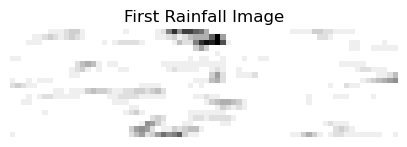

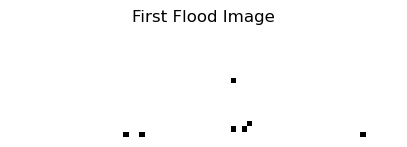

In [56]:
check_first_point(train_loader)

Shape of the first rainfall tensor: torch.Size([32, 5, 20, 72])
Shape of the first feature vector tensor: torch.Size([32, 5, 1000])
Shape of the first flood tensor: torch.Size([32, 5, 20, 72])
Shape of the first date tensor: torch.Size([32, 5, 65])

First 10 values of the rainfall image:
tensor([[0.2000, 0.2000, 0.2000, 0.1000, 0.1000, 0.1000, 0.2000, 0.2000, 0.1000,
         0.1000, 0.1000, 0.1000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000,
         0.4000, 0.9000, 0.9000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000, 0.3000, 0.3000,
         0.3000, 0.4000, 0.4000, 0.4000, 0.4000, 0.2000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

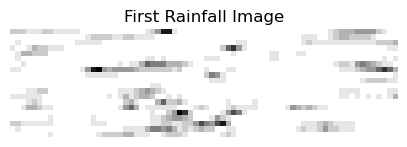

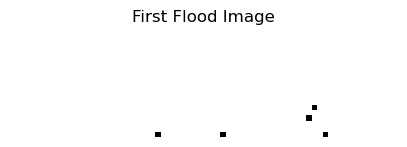

In [57]:
check_first_point(valid_loader)

Shape of the first rainfall tensor: torch.Size([32, 5, 20, 72])
Shape of the first feature vector tensor: torch.Size([32, 5, 1000])
Shape of the first flood tensor: torch.Size([32, 5, 20, 72])
Shape of the first date tensor: torch.Size([32, 5, 65])

First 10 values of the rainfall image:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1538, 0.3846, 0.3077, 0.0769, 0.0769, 0.2308,
         0.1538, 0.0769, 0.2308, 0.3846, 0.2308, 0.1538, 0.0769, 0.0769, 0.0769,
         0.1538, 0.4615, 0.6154, 0.6154, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

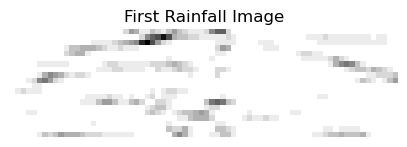

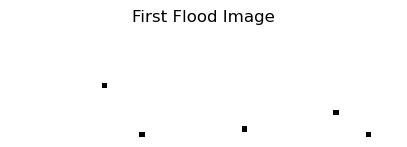

In [58]:
check_first_point(test_loader)

In [59]:
class ImageLSTM(nn.Module):
    #def __init__(self, rainfall_input_size, date_input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
    def __init__(self, rainfall_input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(ImageLSTM, self).__init__()
        
        self.output_size = rainfall_input_size

        # LSTM layers to process sequential image data for each input channel
        self.rainfall_lstm = nn.LSTM(rainfall_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.flood_lstm = nn.LSTM(rainfall_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        #self.date_lstm = nn.LSTM(date_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)

        # Add attention layers
        self.attention_rainfall = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4)
        self.attention_flood = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4)
        #self.attention_date = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4)

        # Batch normalization layer
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)  # Combine outputs from the two LSTMs (rainfall_lstm and date_lstm)
        #self.batch_norm = nn.BatchNorm1d(hidden_size)

        # Output layer to generate predictions
        self.fc = nn.Linear(hidden_size * 2, output_size)
        #self.fc = nn.Linear(hidden_size, output_size)
    
    #def forward(self, rainfall, flood, date_tensors):
    def forward(self, rainfall, flood):
        # rainfall shape: (batch_size, sequence_length, rainfall_input_size)
        # date_tensors shape: (batch_size, sequence_length, date_input_size)

        # Process rainfall data with LSTM
        rainfall_lstm_output, _ = self.rainfall_lstm(rainfall)
        
        sequence_length = rainfall_lstm_output.size(1)  # Get the sequence length

        # Access the values along the 5th dimension (sequence length)
        rainfall_lstm_output = rainfall_lstm_output[:, -1, :].unsqueeze(1)  # Get the output at time
        
        # Process flood data with LSTM
        flood_lstm_output, _ = self.flood_lstm(flood)
        
        sequence_length = flood_lstm_output.size(1)  # Get the sequence length

        # Access the values along the 5th dimension (sequence length)
        flood_lstm_output = flood_lstm_output[:, -1, :].unsqueeze(1)  # Get the output at time

        # Process date_tensors with LSTM
        #date_lstm_output, _ = self.date_lstm(date_tensors)
        
        #sequence_length = date_lstm_output.size(1)  # Get the sequence length

        # Access the values along the 5th dimension (sequence length)
        #date_lstm_output = date_lstm_output[:, -1, :].unsqueeze(1)  # Get the output at time

        # Apply attention to LSTM outputs
        rainfall_lstm_output, _ = self.attention_rainfall(rainfall_lstm_output, rainfall_lstm_output, rainfall_lstm_output)
        flood_lstm_output, _ = self.attention_flood(flood_lstm_output, flood_lstm_output, flood_lstm_output)
        #date_lstm_output, _ = self.attention_date(date_lstm_output, date_lstm_output, date_lstm_output)

        # Concatenate the LSTM outputs along the feature dimension (dim=2)
        #combined_lstm_output = torch.cat((rainfall_lstm_output, date_lstm_output), dim=2)
        combined_lstm_output = torch.cat((rainfall_lstm_output, flood_lstm_output), dim=2)
        #combined_lstm_output = rainfall_lstm_output

        # Batch normalization along the sequence_length dimension
        combined_lstm_output = combined_lstm_output.permute(0, 2, 1)
        combined_lstm_output = self.batch_norm(combined_lstm_output)
        combined_lstm_output = combined_lstm_output.permute(0, 2, 1)

        # Apply fully connected layer
        output = self.fc(combined_lstm_output)
        
        # Apply sigmoid activation to the predicted images
        #output = torch.round(torch.sigmoid(predicted_images))
        #output = F.silu(output)
        #output = F.gelu(output)
        
        # Reshape the output to match the downscaled_resolution
        current_batch_size, sequence_length, _ = output.size()
        output = output.view(current_batch_size, sequence_length, downscaled_resolution[0], downscaled_resolution[1])

        return output

In [60]:
# Define input sizes and other parameters
input_size = downscaled_resolution[0] * downscaled_resolution[1]
rainfall_input_size = input_size
date_input_size = 65
hidden_size = 128
num_layers = 2
output_size = input_size
dropout_prob = 0.5

# Create the ImageLSTM model and move it to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = ImageLSTM(rainfall_input_size, date_input_size, hidden_size, num_layers, output_size, dropout_prob)
model = ImageLSTM(rainfall_input_size, hidden_size, num_layers, output_size, dropout_prob)
model.to(device)

# Define the loss function and optimizer with L2 regularization (weight decay)
learning_rate = 0.001
weight_decay = 1e-5
# Gradient clipping
max_grad_norm = 1.0  # Adjust as needed
#criterion = nn.MSELoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0))
#criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
#criterion = FocalLoss(alpha=1, gamma=1, reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Set the directory where you want to save the model state
save_dir = "/kaggle/working/RNN_models"
os.makedirs(save_dir, exist_ok=True)

In [61]:
new_rnn = 1

100%|██████████| 46/46 [00:01<00:00, 34.44batch/s, loss=0.0356]


Epoch [1/100], Train Loss: 0.2473, Valid Loss: 0.0333
Best model state saved at epoch 1


100%|██████████| 46/46 [00:01<00:00, 24.26batch/s, loss=0.0224]


Epoch [2/100], Train Loss: 0.0271, Valid Loss: 0.0200
Best model state saved at epoch 2


100%|██████████| 46/46 [00:01<00:00, 35.03batch/s, loss=0.0214]


Epoch [3/100], Train Loss: 0.0241, Valid Loss: 0.0190
Best model state saved at epoch 3


100%|██████████| 46/46 [00:01<00:00, 34.69batch/s, loss=0.0207]


Epoch [4/100], Train Loss: 0.0233, Valid Loss: 0.0183
Best model state saved at epoch 4


100%|██████████| 46/46 [00:01<00:00, 33.54batch/s, loss=0.02]  


Epoch [5/100], Train Loss: 0.0227, Valid Loss: 0.0177
Best model state saved at epoch 5


100%|██████████| 46/46 [00:01<00:00, 33.76batch/s, loss=0.0195]


Epoch [6/100], Train Loss: 0.0222, Valid Loss: 0.0172
Best model state saved at epoch 6


100%|██████████| 46/46 [00:01<00:00, 29.00batch/s, loss=0.0191]


Epoch [7/100], Train Loss: 0.0218, Valid Loss: 0.0168
Best model state saved at epoch 7


100%|██████████| 46/46 [00:01<00:00, 34.24batch/s, loss=0.0188]


Epoch [8/100], Train Loss: 0.0214, Valid Loss: 0.0165
Best model state saved at epoch 8


100%|██████████| 46/46 [00:01<00:00, 34.35batch/s, loss=0.0186]


Epoch [9/100], Train Loss: 0.0212, Valid Loss: 0.0163
Best model state saved at epoch 9


100%|██████████| 46/46 [00:01<00:00, 34.34batch/s, loss=0.0183]


Epoch [10/100], Train Loss: 0.0209, Valid Loss: 0.0161
Best model state saved at epoch 10


100%|██████████| 46/46 [00:01<00:00, 33.28batch/s, loss=0.0182]


Epoch [11/100], Train Loss: 0.0208, Valid Loss: 0.0159
Best model state saved at epoch 11


100%|██████████| 46/46 [00:01<00:00, 34.40batch/s, loss=0.018]  


Epoch [12/100], Train Loss: 0.0206, Valid Loss: 0.0157
Best model state saved at epoch 12


100%|██████████| 46/46 [00:01<00:00, 30.41batch/s, loss=0.0179] 


Epoch [13/100], Train Loss: 0.0205, Valid Loss: 0.0156
Best model state saved at epoch 13


100%|██████████| 46/46 [00:01<00:00, 34.59batch/s, loss=0.0178] 


Epoch [14/100], Train Loss: 0.0204, Valid Loss: 0.0155
Best model state saved at epoch 14


100%|██████████| 46/46 [00:01<00:00, 35.02batch/s, loss=0.0177] 


Epoch [15/100], Train Loss: 0.0203, Valid Loss: 0.0154
Best model state saved at epoch 15


100%|██████████| 46/46 [00:01<00:00, 33.98batch/s, loss=0.0176] 


Epoch [16/100], Train Loss: 0.0202, Valid Loss: 0.0153
Best model state saved at epoch 16


100%|██████████| 46/46 [00:01<00:00, 34.13batch/s, loss=0.0176] 


Epoch [17/100], Train Loss: 0.0201, Valid Loss: 0.0152
Best model state saved at epoch 17


100%|██████████| 46/46 [00:01<00:00, 34.39batch/s, loss=0.0175] 


Epoch [18/100], Train Loss: 0.0200, Valid Loss: 0.0152
Best model state saved at epoch 18


100%|██████████| 46/46 [00:01<00:00, 30.61batch/s, loss=0.0175] 


Epoch [19/100], Train Loss: 0.0200, Valid Loss: 0.0151
Best model state saved at epoch 19


100%|██████████| 46/46 [00:01<00:00, 33.56batch/s, loss=0.0174] 


Epoch [20/100], Train Loss: 0.0199, Valid Loss: 0.0151
Best model state saved at epoch 20


100%|██████████| 46/46 [00:01<00:00, 28.81batch/s, loss=0.0174] 


Epoch [21/100], Train Loss: 0.0199, Valid Loss: 0.0150
Best model state saved at epoch 21


100%|██████████| 46/46 [00:01<00:00, 30.49batch/s, loss=0.0174] 


Epoch [22/100], Train Loss: 0.0198, Valid Loss: 0.0150
Best model state saved at epoch 22


100%|██████████| 46/46 [00:01<00:00, 34.90batch/s, loss=0.0174] 


Epoch [23/100], Train Loss: 0.0198, Valid Loss: 0.0150
Best model state saved at epoch 23


100%|██████████| 46/46 [00:01<00:00, 34.88batch/s, loss=0.0174] 


Epoch [24/100], Train Loss: 0.0198, Valid Loss: 0.0149
Best model state saved at epoch 24


100%|██████████| 46/46 [00:01<00:00, 30.18batch/s, loss=0.0174] 


Epoch [25/100], Train Loss: 0.0197, Valid Loss: 0.0149
Best model state saved at epoch 25


100%|██████████| 46/46 [00:01<00:00, 27.45batch/s, loss=0.0174] 


Epoch [26/100], Train Loss: 0.0197, Valid Loss: 0.0149
Best model state saved at epoch 26


100%|██████████| 46/46 [00:01<00:00, 33.57batch/s, loss=0.0174] 


Epoch [27/100], Train Loss: 0.0197, Valid Loss: 0.0149
Best model state saved at epoch 27


100%|██████████| 46/46 [00:01<00:00, 31.83batch/s, loss=0.0174] 


Epoch [28/100], Train Loss: 0.0197, Valid Loss: 0.0149
Best model state saved at epoch 28


100%|██████████| 46/46 [00:01<00:00, 33.52batch/s, loss=0.0174] 


Epoch [29/100], Train Loss: 0.0196, Valid Loss: 0.0149
Best model state saved at epoch 29


100%|██████████| 46/46 [00:01<00:00, 33.14batch/s, loss=0.0174] 


Epoch [30/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 30


100%|██████████| 46/46 [00:01<00:00, 33.36batch/s, loss=0.0174] 


Epoch [31/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 31


100%|██████████| 46/46 [00:01<00:00, 34.36batch/s, loss=0.0174] 


Epoch [32/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 32


100%|██████████| 46/46 [00:01<00:00, 34.32batch/s, loss=0.0174] 


Epoch [33/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 33


100%|██████████| 46/46 [00:01<00:00, 31.49batch/s, loss=0.0174] 


Epoch [34/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 34


100%|██████████| 46/46 [00:01<00:00, 33.73batch/s, loss=0.0174] 


Epoch [35/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 35


100%|██████████| 46/46 [00:01<00:00, 34.12batch/s, loss=0.0174] 


Epoch [36/100], Train Loss: 0.0195, Valid Loss: 0.0148
Best model state saved at epoch 36


100%|██████████| 46/46 [00:01<00:00, 33.20batch/s, loss=0.0175] 


Epoch [37/100], Train Loss: 0.0195, Valid Loss: 0.0148
Best model state saved at epoch 37


100%|██████████| 46/46 [00:01<00:00, 33.37batch/s, loss=0.0175] 


Epoch [38/100], Train Loss: 0.0195, Valid Loss: 0.0148


100%|██████████| 46/46 [00:01<00:00, 33.97batch/s, loss=0.0175] 


Epoch [39/100], Train Loss: 0.0195, Valid Loss: 0.0148


100%|██████████| 46/46 [00:01<00:00, 24.19batch/s, loss=0.0175] 


Epoch [40/100], Train Loss: 0.0195, Valid Loss: 0.0148


100%|██████████| 46/46 [00:01<00:00, 34.10batch/s, loss=0.0175] 


Epoch [41/100], Train Loss: 0.0195, Valid Loss: 0.0148
Epoch 00041: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 46/46 [00:01<00:00, 34.80batch/s, loss=0.0162] 


Epoch [42/100], Train Loss: 0.0191, Valid Loss: 0.0142
Best model state saved at epoch 42


100%|██████████| 46/46 [00:01<00:00, 34.16batch/s, loss=0.0162] 


Epoch [43/100], Train Loss: 0.0189, Valid Loss: 0.0142


100%|██████████| 46/46 [00:01<00:00, 34.17batch/s, loss=0.0162] 


Epoch [44/100], Train Loss: 0.0189, Valid Loss: 0.0142


100%|██████████| 46/46 [00:01<00:00, 30.73batch/s, loss=0.0162] 


Epoch [45/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 45


100%|██████████| 46/46 [00:01<00:00, 33.61batch/s, loss=0.0162] 


Epoch [46/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 46


100%|██████████| 46/46 [00:01<00:00, 32.95batch/s, loss=0.0162] 


Epoch [47/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 47


100%|██████████| 46/46 [00:01<00:00, 33.48batch/s, loss=0.0162] 


Epoch [48/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 48


100%|██████████| 46/46 [00:01<00:00, 33.32batch/s, loss=0.0162] 


Epoch [49/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 49


100%|██████████| 46/46 [00:01<00:00, 32.28batch/s, loss=0.0162] 


Epoch [50/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 50


100%|██████████| 46/46 [00:01<00:00, 33.57batch/s, loss=0.0162] 


Epoch [51/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 51


100%|██████████| 46/46 [00:01<00:00, 34.59batch/s, loss=0.0162] 


Epoch [52/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 52


100%|██████████| 46/46 [00:01<00:00, 34.11batch/s, loss=0.0162] 


Epoch [53/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 53


100%|██████████| 46/46 [00:01<00:00, 34.08batch/s, loss=0.0162] 


Epoch [54/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 54


100%|██████████| 46/46 [00:01<00:00, 34.21batch/s, loss=0.0162] 


Epoch [55/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 55


100%|██████████| 46/46 [00:01<00:00, 33.92batch/s, loss=0.0162] 


Epoch [56/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 56


100%|██████████| 46/46 [00:01<00:00, 33.22batch/s, loss=0.0162] 


Epoch [57/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 57


100%|██████████| 46/46 [00:01<00:00, 34.61batch/s, loss=0.0162] 


Epoch [58/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 58


100%|██████████| 46/46 [00:01<00:00, 25.04batch/s, loss=0.0162] 


Epoch [59/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 59


100%|██████████| 46/46 [00:01<00:00, 34.49batch/s, loss=0.0162] 


Epoch [60/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 60


100%|██████████| 46/46 [00:01<00:00, 35.09batch/s, loss=0.0162] 


Epoch [61/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 61


100%|██████████| 46/46 [00:01<00:00, 34.77batch/s, loss=0.0162] 


Epoch [62/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 62


100%|██████████| 46/46 [00:01<00:00, 34.28batch/s, loss=0.0162] 


Epoch [63/100], Train Loss: 0.0189, Valid Loss: 0.0141
Best model state saved at epoch 63


100%|██████████| 46/46 [00:01<00:00, 28.00batch/s, loss=0.0162] 


Epoch [64/100], Train Loss: 0.0189, Valid Loss: 0.0141
Best model state saved at epoch 64


100%|██████████| 46/46 [00:01<00:00, 33.76batch/s, loss=0.0162] 


Epoch [65/100], Train Loss: 0.0189, Valid Loss: 0.0141
Best model state saved at epoch 65


100%|██████████| 46/46 [00:01<00:00, 33.55batch/s, loss=0.0162] 


Epoch [66/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 66


100%|██████████| 46/46 [00:01<00:00, 33.92batch/s, loss=0.0162] 


Epoch [67/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 67


100%|██████████| 46/46 [00:01<00:00, 34.72batch/s, loss=0.0162] 


Epoch [68/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 68


100%|██████████| 46/46 [00:01<00:00, 34.69batch/s, loss=0.0162] 


Epoch [69/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 69


100%|██████████| 46/46 [00:01<00:00, 33.80batch/s, loss=0.0162] 


Epoch [70/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 70


100%|██████████| 46/46 [00:01<00:00, 35.17batch/s, loss=0.0162] 


Epoch [71/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 71


100%|██████████| 46/46 [00:01<00:00, 34.04batch/s, loss=0.0162] 


Epoch [72/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 72


100%|██████████| 46/46 [00:01<00:00, 34.12batch/s, loss=0.0162] 


Epoch [73/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 73


100%|██████████| 46/46 [00:01<00:00, 34.47batch/s, loss=0.0162] 


Epoch [74/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 74


100%|██████████| 46/46 [00:01<00:00, 33.05batch/s, loss=0.0162] 


Epoch [75/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 75


100%|██████████| 46/46 [00:01<00:00, 34.23batch/s, loss=0.0162] 


Epoch [76/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 76


100%|██████████| 46/46 [00:01<00:00, 33.83batch/s, loss=0.0162] 


Epoch [77/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 77


100%|██████████| 46/46 [00:01<00:00, 34.69batch/s, loss=0.0162] 


Epoch [78/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 78


100%|██████████| 46/46 [00:01<00:00, 33.23batch/s, loss=0.0162] 


Epoch [79/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 79


100%|██████████| 46/46 [00:01<00:00, 34.56batch/s, loss=0.0162] 


Epoch [80/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 80


100%|██████████| 46/46 [00:01<00:00, 35.18batch/s, loss=0.0162] 


Epoch [81/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 81


100%|██████████| 46/46 [00:01<00:00, 34.81batch/s, loss=0.0162] 


Epoch [82/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 82


100%|██████████| 46/46 [00:01<00:00, 27.81batch/s, loss=0.0162] 


Epoch [83/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 83


100%|██████████| 46/46 [00:01<00:00, 34.32batch/s, loss=0.0162] 


Epoch [84/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 84


100%|██████████| 46/46 [00:01<00:00, 34.54batch/s, loss=0.0162] 


Epoch [85/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 85


100%|██████████| 46/46 [00:01<00:00, 34.48batch/s, loss=0.0162] 


Epoch [86/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 86


100%|██████████| 46/46 [00:01<00:00, 34.80batch/s, loss=0.0162] 


Epoch [87/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 87


100%|██████████| 46/46 [00:01<00:00, 23.92batch/s, loss=0.0162] 


Epoch [88/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 88


100%|██████████| 46/46 [00:01<00:00, 33.75batch/s, loss=0.0162] 


Epoch [89/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 89


100%|██████████| 46/46 [00:01<00:00, 34.69batch/s, loss=0.0162] 


Epoch [90/100], Train Loss: 0.0188, Valid Loss: 0.0141
Epoch 00090: reducing learning rate of group 0 to 2.5000e-04.
Best model state saved at epoch 90


100%|██████████| 46/46 [00:01<00:00, 34.98batch/s, loss=0.0158] 


Epoch [91/100], Train Loss: 0.0185, Valid Loss: 0.0139
Best model state saved at epoch 91


100%|██████████| 46/46 [00:01<00:00, 33.58batch/s, loss=0.0158] 


Epoch [92/100], Train Loss: 0.0184, Valid Loss: 0.0139


100%|██████████| 46/46 [00:01<00:00, 33.25batch/s, loss=0.0158] 


Epoch [93/100], Train Loss: 0.0184, Valid Loss: 0.0139


100%|██████████| 46/46 [00:01<00:00, 34.49batch/s, loss=0.0158] 


Epoch [94/100], Train Loss: 0.0184, Valid Loss: 0.0139


100%|██████████| 46/46 [00:01<00:00, 34.30batch/s, loss=0.0158] 


Epoch [95/100], Train Loss: 0.0184, Valid Loss: 0.0139
Epoch 00095: reducing learning rate of group 0 to 1.2500e-04.


100%|██████████| 46/46 [00:01<00:00, 34.69batch/s, loss=0.0157] 


Epoch [96/100], Train Loss: 0.0181, Valid Loss: 0.0138
Best model state saved at epoch 96


100%|██████████| 46/46 [00:01<00:00, 32.79batch/s, loss=0.0157] 


Epoch [97/100], Train Loss: 0.0181, Valid Loss: 0.0138
Best model state saved at epoch 97


100%|██████████| 46/46 [00:01<00:00, 35.15batch/s, loss=0.0156] 


Epoch [98/100], Train Loss: 0.0181, Valid Loss: 0.0138
Best model state saved at epoch 98


100%|██████████| 46/46 [00:01<00:00, 34.81batch/s, loss=0.0156] 


Epoch [99/100], Train Loss: 0.0181, Valid Loss: 0.0138
Best model state saved at epoch 99


100%|██████████| 46/46 [00:01<00:00, 32.86batch/s, loss=0.0156] 


Epoch [100/100], Train Loss: 0.0181, Valid Loss: 0.0138
Best model state saved at epoch 100


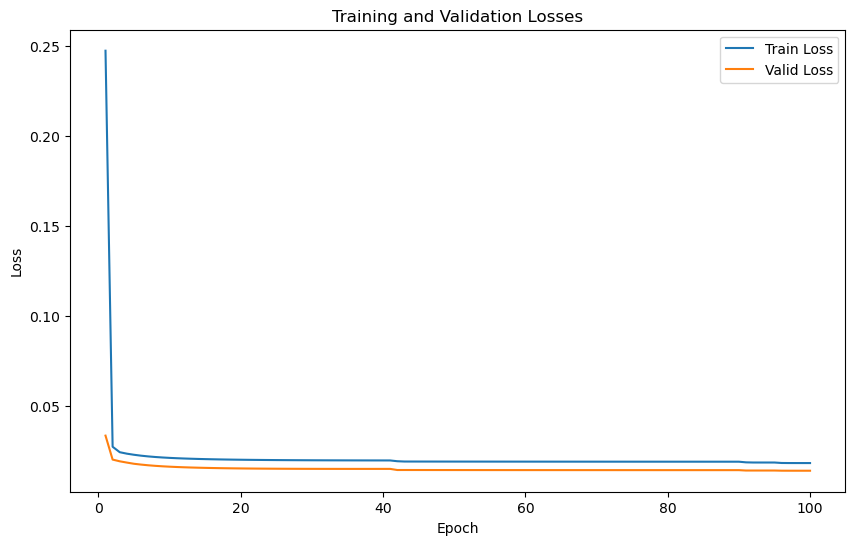

In [62]:
if new_rnn == 1:    
    # Training loop
    num_epochs = 100
    train_losses = []
    valid_losses = []

    # Keep track of the best validation loss and the corresponding epoch
    best_valid_loss = float('inf')
    best_epoch = None
    patience = 10  # Number of epochs to wait for improvement before early stopping
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # Use tqdm to monitor progress for the training loop
        with tqdm(train_loader, unit="batch") as tepoch:
            for rainfall_batch, flood_batch, _, date_batch in tepoch:
                rainfall_batch = rainfall_batch.to(device)
                flood_batch = flood_batch.to(device)
                #date_batch = date_batch.to(device)

                optimizer.zero_grad()
                
                current_batch_size, sequence_length, _, _ = rainfall_batch.size()
                rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
                current_batch_size, sequence_length, _, _ = flood_batch.size()
                flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)
                
                flood_input = flood_batch[:, :-1, :]
                flood_target = flood_batch[:, -1, :].unsqueeze(1)
                
                #output = model(rainfall_batch, flood_input, date_batch)
                output = model(rainfall_batch, flood_input)
                
                # Reshape the output to match the downscaled_resolution
                current_batch_size, sequence_length, _, _ = output.size()
                output = output.view(current_batch_size, sequence_length, output_size)
                
                loss = criterion(output, flood_target)  # Use flood_batch as target
                loss.backward()
                
                # Clip gradients using nn.utils.clip_grad_norm_
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                optimizer.step()

                total_train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        # Calculate and store average training loss for this epoch
        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loop (assuming you have a validation set)
        model.eval()
        total_valid_loss = 0

        # Use tqdm to monitor progress for the validation loop
        with tqdm(valid_loader, unit="batch") as tvalid:
            with torch.no_grad():
                for rainfall_batch, flood_batch, _, date_batch in tvalid:
                    rainfall_batch = rainfall_batch.to(device)
                    flood_batch = flood_batch.to(device)
                    #date_batch = date_batch.to(device)

                    optimizer.zero_grad()

                    current_batch_size, sequence_length, _, _ = rainfall_batch.size()
                    rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
                    current_batch_size, sequence_length, _, _ = flood_batch.size()
                    flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)

                    flood_input = flood_batch[:, :-1, :]
                    flood_target = flood_batch[:, -1, :].unsqueeze(1)

                    #output = model(rainfall_batch, flood_input, date_batch)
                    output = model(rainfall_batch, flood_input)

                    # Reshape the output to match the downscaled_resolution
                    current_batch_size, sequence_length, _, _ = output.size()
                    output = output.view(current_batch_size, sequence_length, output_size)

                    loss = criterion(output, flood_target)  # Use flood_batch as target
        
                    total_valid_loss += loss.item()
                    tvalid.set_postfix(loss=loss.item())

        # Calculate and store average validation loss for this epoch
        valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)

        # Print epoch-wise losses
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

        # Update the learning rate scheduler based on the validation loss
        scheduler.step(valid_loss)

        # Save the model state if the validation loss has improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0  # Reset the counter for lack of improvement
            model_state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'valid_losses': valid_losses,
            }
            save_path = os.path.join(save_dir, f"rnn_model_best.pt")
            torch.save(model_state, save_path)
            print(f"Best model state saved at epoch {epoch + 1}")

        else:
            epochs_without_improvement += 1

        # Early stopping: If both lack of improvement and stagnation occur for the specified patience, stop training
        if epochs_without_improvement >= patience:
            print(f"Stopping early as validation loss has not improved or stagnated for {patience} consecutive epochs.")
            break

    # Plot the losses over time
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.savefig("rnn_losses.png")
    plt.show()

In [63]:
if new_rnn == 1:
    # Generate a file link for the best model
    best_rnn_link = FileLink(save_path)
    print("Download the best model:", best_rnn_link)

Download the best model: /kaggle/working/RNN_models/rnn_model_best.pt


In [64]:
# Load the saved model state (best model)
if new_rnn == 1:
    model_path = "/kaggle/working/RNN_models/rnn_model_best.pt"  # Replace with the actual path to the saved best model state
else:
    model_path = "/kaggle/input/rnn-model-1/rnn_model_best.pt"  # Replace with the actual path to the saved model state

checkpoint = torch.load(model_path)

# Load the best model state
model_state_dict = checkpoint['state_dict']
model_dict = model.state_dict()

# Filter out the missing keys and load only the matching keys
model_state_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model_dict.update(model_state_dict)
model.load_state_dict(model_dict)
model.eval()

# Test the model on the test set and calculate the loss
input_images = []
real_images = []
predicted_images = []

with torch.no_grad(), tqdm(test_loader, unit="batch") as ttest:
    for rainfall_batch, flood_batch, _, date_batch in ttest:
        rainfall_batch = rainfall_batch.to(device)
        flood_batch = flood_batch.to(device)
        #date_batch = date_batch.to(device)

        current_batch_size, sequence_length, _, _ = rainfall_batch.size()
        rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
        current_batch_size, sequence_length, _, _ = flood_batch.size()
        flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)

        flood_input = flood_batch[:, :-1, :]
        flood_target = flood_batch[:, -1, :].unsqueeze(1)

        #output = model(rainfall_batch, flood_input, date_batch)
        output = model(rainfall_batch, flood_input)
        
        # Reshape the output to match the downscaled_resolution
        current_batch_size, sequence_length, _, _ = output.size()
        output = output.view(current_batch_size, sequence_length, output_size)

        rainfall_final = rainfall_batch[:, sequence_length-1, :].unsqueeze(1)
        rainfall_final = rainfall_final.view(current_batch_size, sequence_length, output_size)
        
        output = torch.round(torch.sigmoid(output))
        #output = torch.clamp(output, 0, 1)
        
        # Append the input and predicted rainfall sequences to their respective lists
        input_images.extend(rainfall_final.cpu().numpy())
        real_images.extend(flood_target.cpu().numpy())
        predicted_images.extend(output.cpu().numpy())

# Convert the lists to numpy arrays
input_images = np.array(input_images)
real_images = np.array(real_images)
predicted_images = np.array(predicted_images)

#messy_predicted_images = predicted_images

# Round the predicted images
#predicted_images = np.round(1 / (1 + np.exp(-predicted_images)))
#predicted_images = np.clip(predicted_images, 0, 1)  # Clipping
#predicted_images = np.round(predicted_images)

100%|██████████| 46/46 [00:01<00:00, 36.73batch/s]


In [65]:
print(input_images.shape)
print(real_images.shape)
print(predicted_images.shape)

# Print the first values in the first image for each set
print("First values in the first image for each set:")
print("Input Images:")
print(input_images[0, 0])
print("Real Images:")
print(real_images[0, 0])
print("Predicted Images:")
print(predicted_images[0, 0])
#print("Unnormalized Predicted Images:")
#print(messy_predicted_images[0, 0])

(1455, 1, 1440)
(1455, 1, 1440)
(1455, 1, 1440)
First values in the first image for each set:
Input Images:
[0. 0. 0. ... 0. 0. 0.]
Real Images:
[0. 0. 0. ... 0. 0. 0.]
Predicted Images:
[0. 0. 0. ... 0. 0. 0.]


Best Prediction:


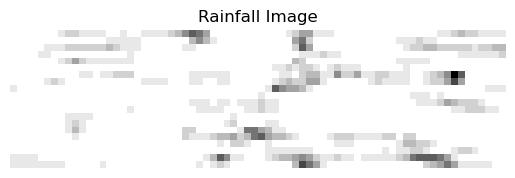

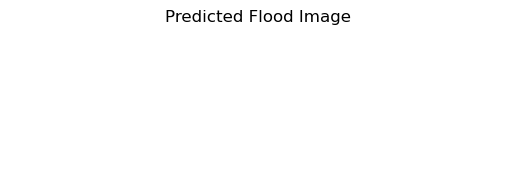

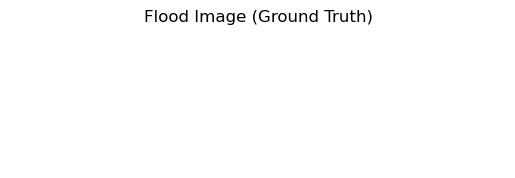

Best Image
F1-Score: 1.0000
Middle Prediction:


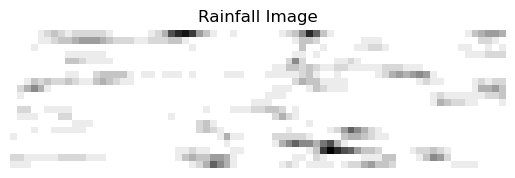

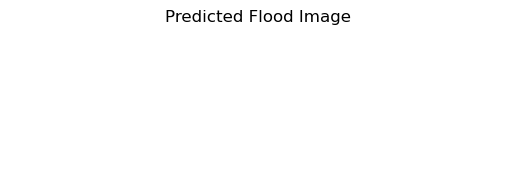

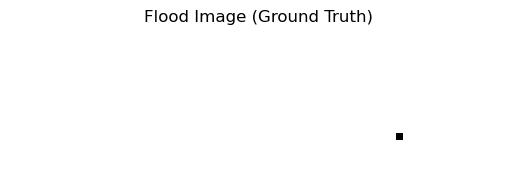

Middle Image
F1-Score: 0.0000
Worst Prediction:


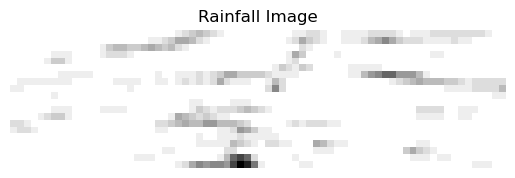

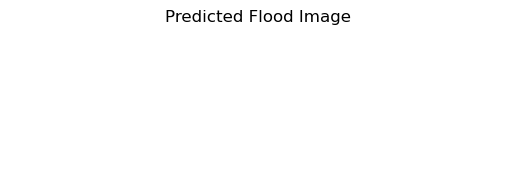

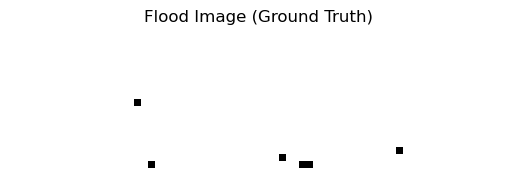

Worst Image
F1-Score: 0.0000
Average Precision: 1.0000, Average Recall: 0.0694, Average F1-Score: 0.0694


In [66]:
# Calculate metrics for all predicted flood images
metrics = [calculate_metrics(real_images[i, 0], predicted_images[i, 0]) for i in range(len(predicted_images))]

# Sort the images based on their F1-scores in descending order
sorted_indices = sorted(range(len(metrics)), key=lambda k: metrics[k][2], reverse=True)

# Display the best, middle, and worst predictions
best_n = 1
middle_n = 1
worst_n = 1

# Display the best prediction
print("Best Prediction:")
index = sorted_indices[0]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("best_rainfall_rnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("best_predicted_rnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("best_real_rnn.png")
plt.show()

print(f"Best Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the middle prediction
print("Middle Prediction:")
index = sorted_indices[len(sorted_indices) // 2]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("middle_rainfall_rnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("middle_predicted_rnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("middle_real_rnn.png")
plt.show()

print(f"Middle Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the worst prediction
print("Worst Prediction:")
index = sorted_indices[-1]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("worst_rainfall_rnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("worst_predicted_rnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("worst_real_rnn.png")
plt.show()

print(f"Worst Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Calculate the average metrics for all predicted flood images
precision_scores = [m[0] for m in metrics]
recall_scores = [m[1] for m in metrics]
f1_scores = [m[2] for m in metrics]
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)
print(f"Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-Score: {average_f1:.4f}")

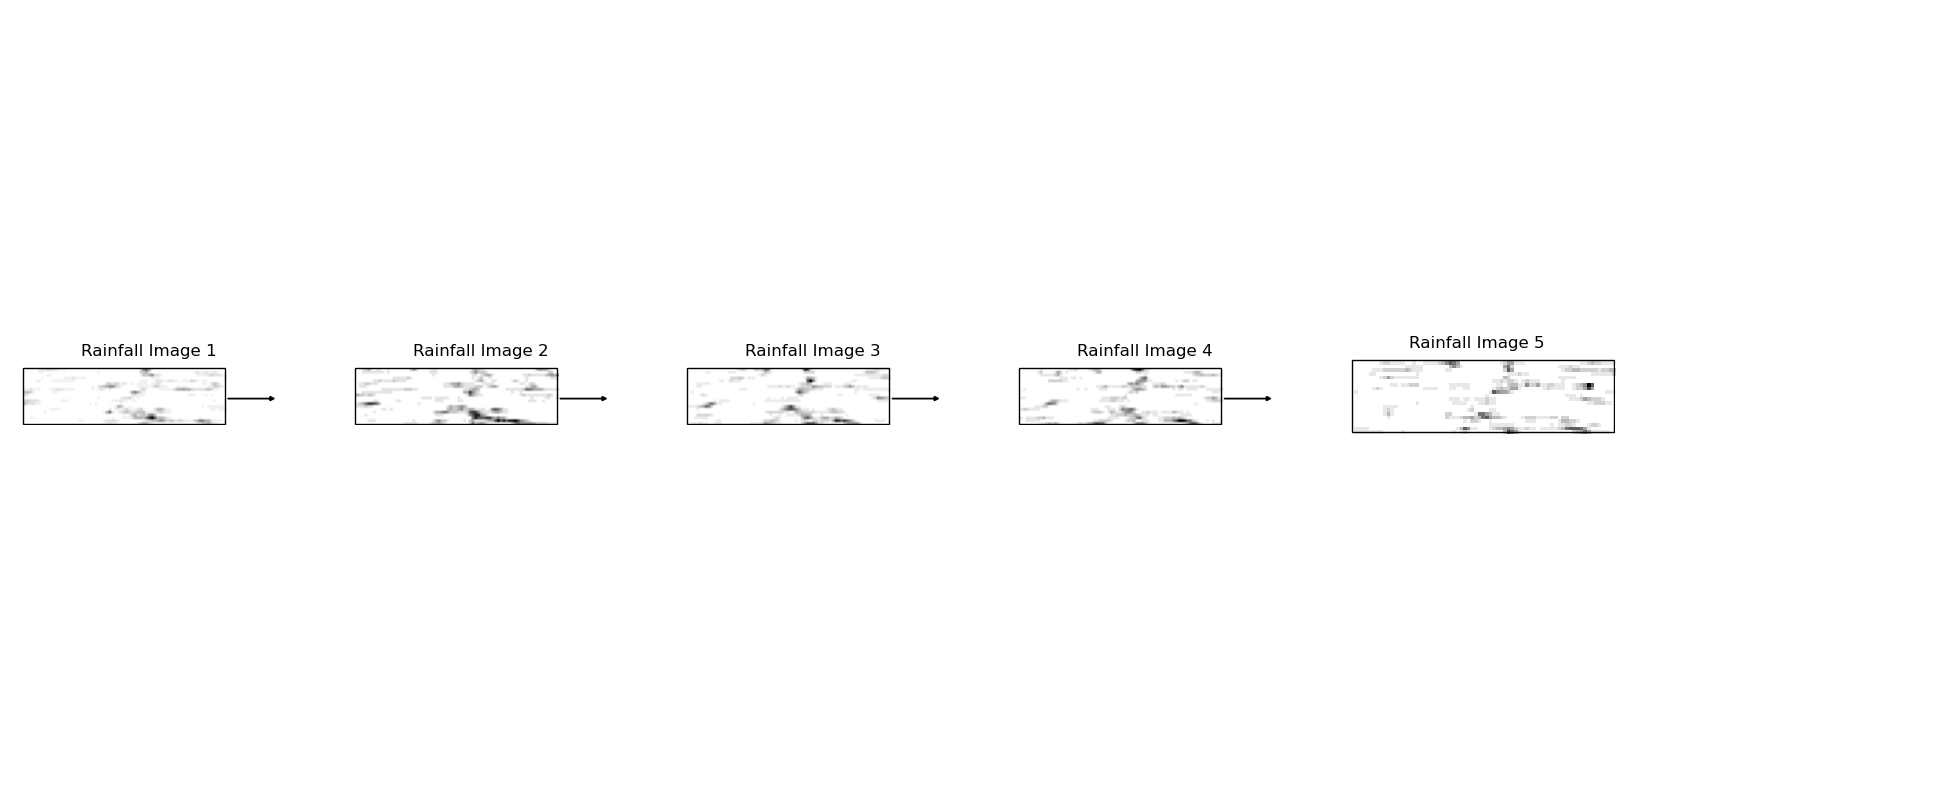

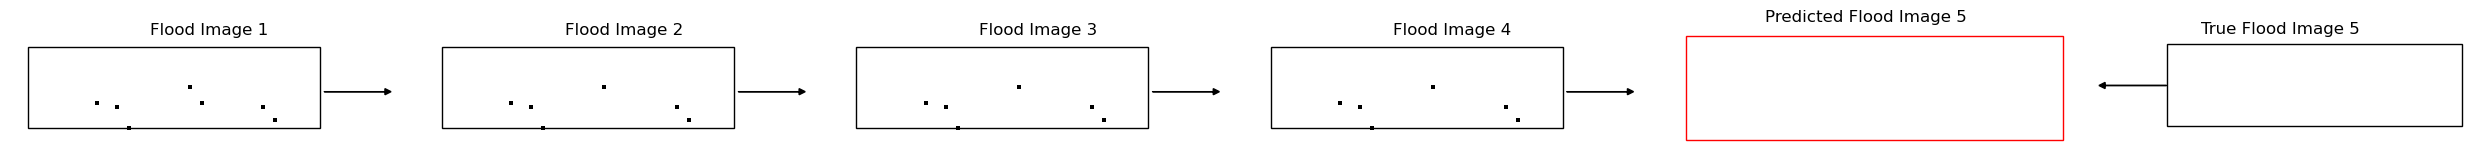

Example 312
F1-Score: 1.0000


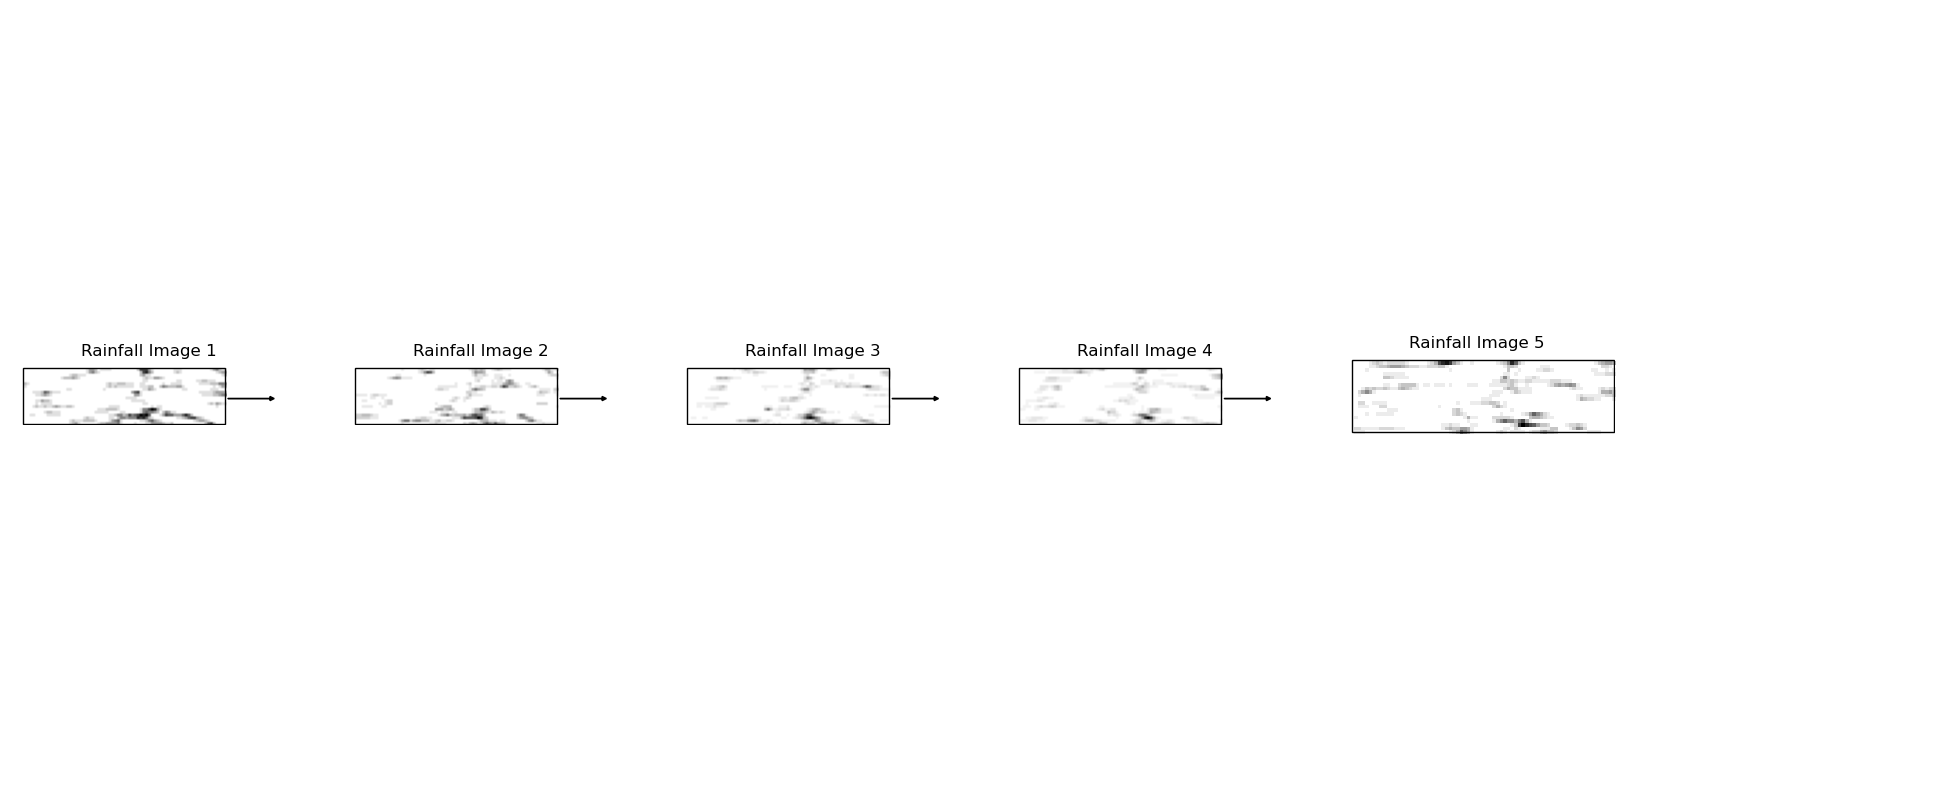

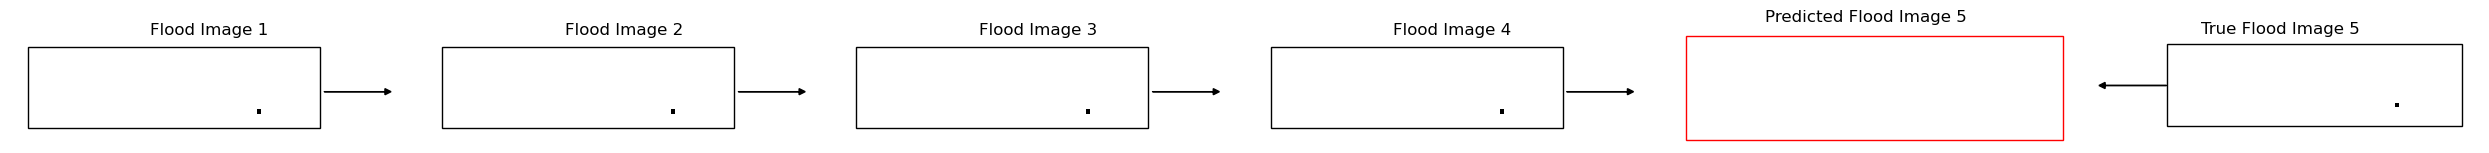

Example 658
F1-Score: 0.0000


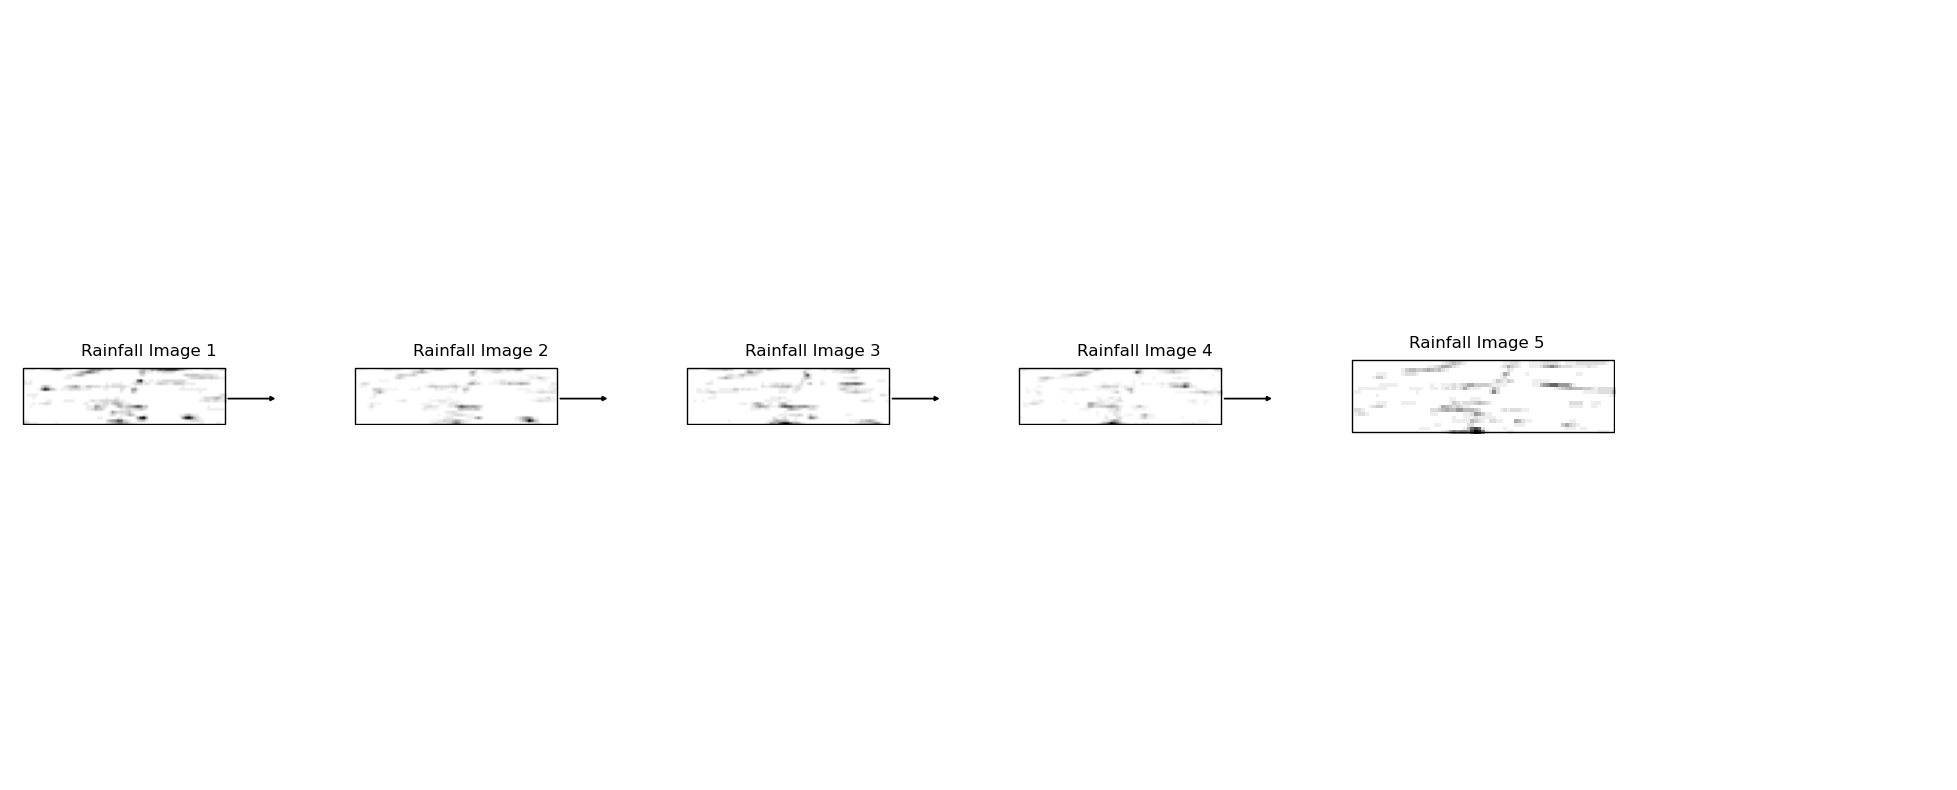

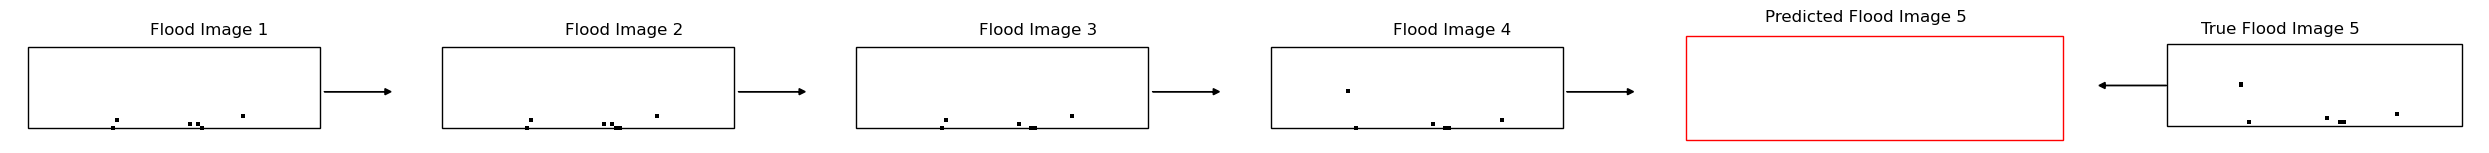

Example 1455
F1-Score: 0.0000


In [67]:
# Display examples of highest scoring, lowest scoring, and median scoring predictions
examples_indices = [sorted_indices[0], sorted_indices[len(sorted_indices) // 2], sorted_indices[-1]]
filenames = ["best", "middle", "worst"]
count = 0

for index in examples_indices:
    # Get the indices of the images for this example
    image_indices = [index - 4, index - 3, index - 2, index - 1, index, index]

    # Create two separate figures with a 1x6 layout
    fig1, axs1 = plt.subplots(1, 6, figsize=(25, 10))
    fig2, axs2 = plt.subplots(1, 6, figsize=(25, 10))
    
    plt.subplots_adjust(wspace=0.1)  # Adjust horizontal spacing

    for i, img_index in enumerate(image_indices):
        input_img = input_images[img_index, 0]
        real_img = real_images[img_index, 0]
        pred_img = predicted_images[img_index, 0]

        # Reshape and resize rainfall images to downscaled_resolution for display
        input_img_resized = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        real_img_resized = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        pred_img_resized = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

        # Convert NumPy arrays to images using PIL
        input_img_pil = Image.fromarray((input_img_resized * 255).astype(np.uint8), mode='L')
        real_img_pil = Image.fromarray((real_img_resized * 255).astype(np.uint8), mode='L')
        pred_img_pil = Image.fromarray((pred_img_resized * 255).astype(np.uint8), mode='L')

        if i <= 3:
            axs1[i].imshow(input_img_pil, cmap='binary')
            axs1[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs1[i].set_title('Rainfall Image '+str(i+1))
            axs1[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs1[i].axis('off')

            axs2[i].imshow(real_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs2[i].set_title('Flood Image '+str(i+1))
            axs2[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs2[i].axis('off')

        if i == 4:
            axs1[i].imshow(input_img_pil, cmap='binary')
            axs1[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs1[i].set_title('Rainfall Image '+str(i+1))
            axs1[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0.01, head_length=0, fc='white', ec='white')
            axs1[i].axis('off')

            axs2[i].imshow(pred_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='red'))
            axs2[i].set_title('Predicted Flood Image '+str(i+1))
            axs2[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0, head_length=0, fc='white', ec='white')
            axs2[i].axis('off')
            
        if i == 5:
            axs1[i].axis('off')

            axs2[i].imshow(real_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((0, 0), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs2[i].arrow(0, downscaled_resolution[1]/2, -15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs2[i].set_title('True Flood Image '+str(i))
            axs2[i].axis('off')

    plt.tight_layout()
    fig1.savefig(filenames[count]+"_rnn_rainfall_sequence.png")
    fig2.savefig(filenames[count]+"_rnn_flood_sequence.png")
    count+=1
    plt.show()

    print(f"Example {index + 1}")
    print(f"F1-Score: {metrics[index][2]:.4f}")
    print("=" * 50)

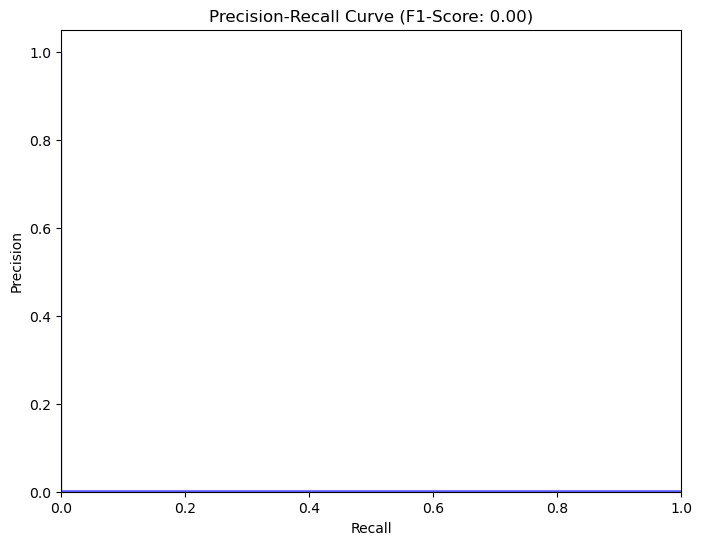

In [68]:
# Flatten the real and predicted images
real_labels = real_images.flatten()
predicted_scores = predicted_images.flatten()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(real_labels, predicted_scores)

# Calculate F1-score
f1 = f1_score(real_labels, np.round(predicted_scores))

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (F1-Score: {:.2f})'.format(f1))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.savefig("rnn_curve.png")
plt.show()

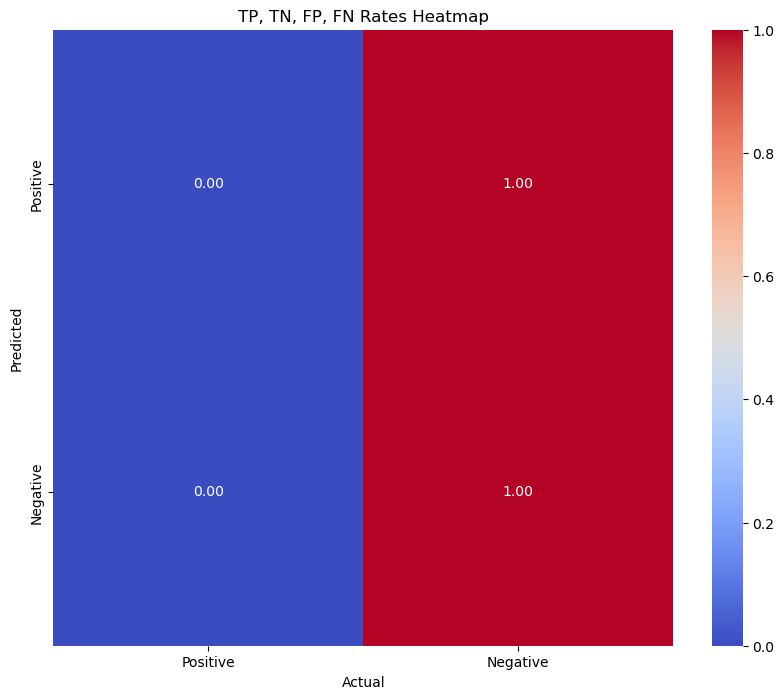

In [69]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(real_labels, np.round(predicted_scores))

# Calculate true positive (TP), true negative (TN), false positive (FP), false negative (FN) rates
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate rates
TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity/Recall)
TNR = TN / (TN + FP)  # True Negative Rate (Specificity)
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate

# Create heatmaps for TP, TN, FP, FN rates
rates = np.array([[TPR, FNR], [FPR, TNR]])

plt.figure(figsize=(10, 8))
sns.heatmap(rates, annot=True, fmt=".2f", cmap='coolwarm', center=0.5,
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('TP, TN, FP, FN Rates Heatmap')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig("rnn_heatmap.png")
plt.show()

In [70]:
class CombinedModel(nn.Module):
    #def __init__(self, rainfall_input_size, feature_input_size, date_input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
    def __init__(self, rainfall_input_size, feature_input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(CombinedModel, self).__init__()
        
        self.output_size = rainfall_input_size

        # LSTM layers to process sequential image data for each input channel
        #self.rainfall_lstm = nn.LSTM(rainfall_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.flood_lstm = nn.LSTM(rainfall_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.feature_lstm = nn.LSTM(feature_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        #self.date_lstm = nn.LSTM(date_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)

        # Add attention layers
        #self.attention_rainfall = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4)
        self.attention_flood = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4)
        self.attention_feature = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4)
        #self.attention_date = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4)

        # Batch normalization layer
        #self.batch_norm = nn.BatchNorm1d(hidden_size * 4)  # Combine outputs from the three LSTMs (rainfall_lstm, feature_lstm, and date_lstm)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)

        # Output layer to generate predictions
        #self.fc = nn.Linear(hidden_size * 4, output_size)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    #def forward(self, rainfall_batch, flood_batch, feature_maps, date_tensors):
    def forward(self, flood_batch, feature_maps):
        # rainfall shape: (batch_size, sequence_length, rainfall_input_size)
        # feature_maps shape: (batch_size, sequence_length, feature_input_size)
        # date_tensors shape: (batch_size, sequence_length, date_input_size)
        
        # Process feature maps with LSTM
        #rainfall_lstm_output, _ = self.rainfall_lstm(rainfall_batch)
        
        #sequence_length = rainfall_lstm_output.size(1)  # Get the sequence length

        # Access the values along the 5th dimension (sequence length)
        #rainfall_lstm_output = rainfall_lstm_output[:, -1, :].unsqueeze(1)  # Get the output at time
        
        # Process feature maps with LSTM
        flood_lstm_output, _ = self.flood_lstm(flood_batch)
        
        sequence_length = flood_lstm_output.size(1)  # Get the sequence length

        # Access the values along the 5th dimension (sequence length)
        flood_lstm_output = flood_lstm_output[:, sequence_length-1, :].unsqueeze(1)  # Get the output at time
        
        # Process feature maps with LSTM
        feature_lstm_output, _ = self.feature_lstm(feature_maps)
        
        sequence_length = feature_lstm_output.size(1)  # Get the sequence length

        # Access the values along the 5th dimension (sequence length)
        feature_lstm_output = feature_lstm_output[:, sequence_length-1, :].unsqueeze(1)  # Get the output at time

        # Process date_tensors with LSTM
        #date_lstm_output, _ = self.date_lstm(date_tensors)
        
        #sequence_length = date_lstm_output.size(1)  # Get the sequence length

        # Access the values along the 5th dimension (sequence length)
        #date_lstm_output = date_lstm_output[:, -1, :].unsqueeze(1)  # Get the output at time

        # Apply attention to LSTM outputs
        #rainfall_batch, _ = self.attention_rainfall(rainfall_lstm_output, rainfall_lstm_output, rainfall_lstm_output)
        flood_lstm_output, _ = self.attention_flood(flood_lstm_output, flood_lstm_output, flood_lstm_output)
        feature_lstm_output, _ = self.attention_feature(feature_lstm_output, feature_lstm_output, feature_lstm_output)
        #date_lstm_output, _ = self.attention_date(date_lstm_output, date_lstm_output, date_lstm_output)

        # Concatenate the LSTM outputs along the feature dimension (dim=2)
        #combined_lstm_output = torch.cat((rainfall_lstm_output, flood_lstm_output, feature_lstm_output, date_lstm_output), dim=2)
        combined_lstm_output = torch.cat((flood_lstm_output, feature_lstm_output), dim=2)

        # Batch normalization along the sequence_length dimension
        combined_lstm_output = combined_lstm_output.permute(0, 2, 1)
        combined_lstm_output = self.batch_norm(combined_lstm_output)
        combined_lstm_output = combined_lstm_output.permute(0, 2, 1)

        # Apply fully connected layer
        output = self.fc(combined_lstm_output)
        
        # Apply sigmoid activation to the predicted images
        #output = torch.round(torch.sigmoid(predicted_images))
        #output = F.silu(output)
        #output = F.gelu(output)
        
        # Reshape the output to match the downscaled_resolution
        current_batch_size, sequence_length, _ = output.size()
        output = output.view(current_batch_size, sequence_length, downscaled_resolution[0], downscaled_resolution[1])

        return output

In [71]:
# Define the input size based on the feature vector size
input_size = downscaled_resolution[0] * downscaled_resolution[1]

# Assuming you have already defined train_loader, valid_loader, and other variables
rainfall_input_size = input_size
feature_input_size = 1000  # Adjust this based on the size of the feature maps
date_input_size = 65  # Adjust this based on the size of the date tensors
output_size = input_size

hidden_size = 128
num_layers = 2
output_size = input_size
dropout_prob = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = CombinedModel(rainfall_input_size, feature_input_size, date_input_size, hidden_size, num_layers, output_size, dropout_prob)
model = CombinedModel(rainfall_input_size, feature_input_size, hidden_size, num_layers, output_size, dropout_prob)
model.to(device)

# Define the loss function and optimizer with L2 regularization (weight decay)
learning_rate = 0.001
weight_decay = 1e-5  # You can adjust the weight decay strength
# Gradient clipping
max_grad_norm = 1.0  # Adjust as needed
#criterion = nn.MSELoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0))
#criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
#criterion = FocalLoss(alpha=1, gamma=1, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Set the directory where you want to save the model state
save_dir = "/kaggle/working/combined_models"
os.makedirs(save_dir, exist_ok=True)

In [72]:
new_combined = 1

100%|██████████| 46/46 [00:01<00:00, 34.77batch/s, loss=0.0311]


Epoch [1/100], Train Loss: 0.2475, Valid Loss: 0.0286
Best model state saved at epoch 1


100%|██████████| 46/46 [00:01<00:00, 33.57batch/s, loss=0.0219]


Epoch [2/100], Train Loss: 0.0271, Valid Loss: 0.0195
Best model state saved at epoch 2


100%|██████████| 46/46 [00:01<00:00, 35.26batch/s, loss=0.0214]


Epoch [3/100], Train Loss: 0.0241, Valid Loss: 0.0190
Best model state saved at epoch 3


100%|██████████| 46/46 [00:01<00:00, 34.90batch/s, loss=0.0207]


Epoch [4/100], Train Loss: 0.0233, Valid Loss: 0.0184
Best model state saved at epoch 4


100%|██████████| 46/46 [00:01<00:00, 24.38batch/s, loss=0.02]  


Epoch [5/100], Train Loss: 0.0227, Valid Loss: 0.0176
Best model state saved at epoch 5


100%|██████████| 46/46 [00:01<00:00, 35.35batch/s, loss=0.0195]


Epoch [6/100], Train Loss: 0.0222, Valid Loss: 0.0172
Best model state saved at epoch 6


100%|██████████| 46/46 [00:01<00:00, 34.67batch/s, loss=0.0191]


Epoch [7/100], Train Loss: 0.0218, Valid Loss: 0.0168
Best model state saved at epoch 7


100%|██████████| 46/46 [00:01<00:00, 34.68batch/s, loss=0.0188]


Epoch [8/100], Train Loss: 0.0214, Valid Loss: 0.0165
Best model state saved at epoch 8


100%|██████████| 46/46 [00:01<00:00, 32.18batch/s, loss=0.0186]


Epoch [9/100], Train Loss: 0.0212, Valid Loss: 0.0163
Best model state saved at epoch 9


100%|██████████| 46/46 [00:01<00:00, 26.14batch/s, loss=0.0183]


Epoch [10/100], Train Loss: 0.0209, Valid Loss: 0.0161
Best model state saved at epoch 10


100%|██████████| 46/46 [00:01<00:00, 34.51batch/s, loss=0.0182]


Epoch [11/100], Train Loss: 0.0208, Valid Loss: 0.0159
Best model state saved at epoch 11


100%|██████████| 46/46 [00:01<00:00, 33.87batch/s, loss=0.018]  


Epoch [12/100], Train Loss: 0.0206, Valid Loss: 0.0157
Best model state saved at epoch 12


100%|██████████| 46/46 [00:01<00:00, 34.52batch/s, loss=0.0179] 


Epoch [13/100], Train Loss: 0.0205, Valid Loss: 0.0156
Best model state saved at epoch 13


100%|██████████| 46/46 [00:01<00:00, 34.64batch/s, loss=0.0178] 


Epoch [14/100], Train Loss: 0.0204, Valid Loss: 0.0155
Best model state saved at epoch 14


100%|██████████| 46/46 [00:01<00:00, 34.50batch/s, loss=0.0177] 


Epoch [15/100], Train Loss: 0.0203, Valid Loss: 0.0154
Best model state saved at epoch 15


100%|██████████| 46/46 [00:01<00:00, 34.63batch/s, loss=0.0176] 


Epoch [16/100], Train Loss: 0.0202, Valid Loss: 0.0153
Best model state saved at epoch 16


100%|██████████| 46/46 [00:01<00:00, 33.42batch/s, loss=0.0176] 


Epoch [17/100], Train Loss: 0.0201, Valid Loss: 0.0152
Best model state saved at epoch 17


100%|██████████| 46/46 [00:01<00:00, 34.43batch/s, loss=0.0175] 


Epoch [18/100], Train Loss: 0.0200, Valid Loss: 0.0152
Best model state saved at epoch 18


100%|██████████| 46/46 [00:01<00:00, 33.02batch/s, loss=0.0175] 


Epoch [19/100], Train Loss: 0.0200, Valid Loss: 0.0151
Best model state saved at epoch 19


100%|██████████| 46/46 [00:01<00:00, 34.05batch/s, loss=0.0174] 


Epoch [20/100], Train Loss: 0.0199, Valid Loss: 0.0151
Best model state saved at epoch 20


100%|██████████| 46/46 [00:01<00:00, 32.18batch/s, loss=0.0174] 


Epoch [21/100], Train Loss: 0.0199, Valid Loss: 0.0150
Best model state saved at epoch 21


100%|██████████| 46/46 [00:01<00:00, 33.60batch/s, loss=0.0174] 


Epoch [22/100], Train Loss: 0.0198, Valid Loss: 0.0150
Best model state saved at epoch 22


100%|██████████| 46/46 [00:01<00:00, 33.52batch/s, loss=0.0174] 


Epoch [23/100], Train Loss: 0.0198, Valid Loss: 0.0150
Best model state saved at epoch 23


100%|██████████| 46/46 [00:01<00:00, 33.57batch/s, loss=0.0174] 


Epoch [24/100], Train Loss: 0.0198, Valid Loss: 0.0149
Best model state saved at epoch 24


100%|██████████| 46/46 [00:01<00:00, 33.89batch/s, loss=0.0174] 


Epoch [25/100], Train Loss: 0.0197, Valid Loss: 0.0149
Best model state saved at epoch 25


100%|██████████| 46/46 [00:01<00:00, 32.50batch/s, loss=0.0174] 


Epoch [26/100], Train Loss: 0.0197, Valid Loss: 0.0149
Best model state saved at epoch 26


100%|██████████| 46/46 [00:01<00:00, 32.32batch/s, loss=0.0174] 


Epoch [27/100], Train Loss: 0.0197, Valid Loss: 0.0149
Best model state saved at epoch 27


100%|██████████| 46/46 [00:01<00:00, 33.33batch/s, loss=0.0174] 


Epoch [28/100], Train Loss: 0.0197, Valid Loss: 0.0149
Best model state saved at epoch 28


100%|██████████| 46/46 [00:01<00:00, 26.97batch/s, loss=0.0174] 


Epoch [29/100], Train Loss: 0.0196, Valid Loss: 0.0149
Best model state saved at epoch 29


100%|██████████| 46/46 [00:01<00:00, 33.60batch/s, loss=0.0174] 


Epoch [30/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 30


100%|██████████| 46/46 [00:01<00:00, 33.94batch/s, loss=0.0174] 


Epoch [31/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 31


100%|██████████| 46/46 [00:01<00:00, 32.18batch/s, loss=0.0174] 


Epoch [32/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 32


100%|██████████| 46/46 [00:01<00:00, 33.69batch/s, loss=0.0174] 


Epoch [33/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 33


100%|██████████| 46/46 [00:01<00:00, 34.78batch/s, loss=0.0174] 


Epoch [34/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 34


100%|██████████| 46/46 [00:01<00:00, 31.76batch/s, loss=0.0174] 


Epoch [35/100], Train Loss: 0.0196, Valid Loss: 0.0148
Best model state saved at epoch 35


100%|██████████| 46/46 [00:01<00:00, 32.75batch/s, loss=0.0174] 


Epoch [36/100], Train Loss: 0.0195, Valid Loss: 0.0148
Best model state saved at epoch 36


100%|██████████| 46/46 [00:01<00:00, 33.49batch/s, loss=0.0175] 


Epoch [37/100], Train Loss: 0.0195, Valid Loss: 0.0148
Best model state saved at epoch 37


100%|██████████| 46/46 [00:01<00:00, 31.91batch/s, loss=0.0175] 


Epoch [38/100], Train Loss: 0.0195, Valid Loss: 0.0148


100%|██████████| 46/46 [00:01<00:00, 34.23batch/s, loss=0.0175] 


Epoch [39/100], Train Loss: 0.0195, Valid Loss: 0.0148


100%|██████████| 46/46 [00:01<00:00, 32.53batch/s, loss=0.0175] 


Epoch [40/100], Train Loss: 0.0195, Valid Loss: 0.0148


100%|██████████| 46/46 [00:01<00:00, 31.13batch/s, loss=0.0175] 


Epoch [41/100], Train Loss: 0.0195, Valid Loss: 0.0148
Epoch 00041: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 46/46 [00:01<00:00, 33.37batch/s, loss=0.0162] 


Epoch [42/100], Train Loss: 0.0191, Valid Loss: 0.0142
Best model state saved at epoch 42


100%|██████████| 46/46 [00:01<00:00, 24.51batch/s, loss=0.0162] 


Epoch [43/100], Train Loss: 0.0189, Valid Loss: 0.0142


100%|██████████| 46/46 [00:01<00:00, 32.28batch/s, loss=0.0162] 


Epoch [44/100], Train Loss: 0.0189, Valid Loss: 0.0142


100%|██████████| 46/46 [00:01<00:00, 32.24batch/s, loss=0.0162] 


Epoch [45/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 45


100%|██████████| 46/46 [00:01<00:00, 35.40batch/s, loss=0.0162] 


Epoch [46/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 46


100%|██████████| 46/46 [00:01<00:00, 32.59batch/s, loss=0.0162] 


Epoch [47/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 47


100%|██████████| 46/46 [00:01<00:00, 26.68batch/s, loss=0.0162] 


Epoch [48/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 48


100%|██████████| 46/46 [00:01<00:00, 33.72batch/s, loss=0.0162] 


Epoch [49/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 49


100%|██████████| 46/46 [00:01<00:00, 32.49batch/s, loss=0.0162] 


Epoch [50/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 50


100%|██████████| 46/46 [00:01<00:00, 34.72batch/s, loss=0.0162] 


Epoch [51/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 51


100%|██████████| 46/46 [00:01<00:00, 35.29batch/s, loss=0.0162] 


Epoch [52/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 52


100%|██████████| 46/46 [00:01<00:00, 32.83batch/s, loss=0.0162] 


Epoch [53/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 53


100%|██████████| 46/46 [00:01<00:00, 33.86batch/s, loss=0.0162] 


Epoch [54/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 54


100%|██████████| 46/46 [00:01<00:00, 33.41batch/s, loss=0.0162] 


Epoch [55/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 55


100%|██████████| 46/46 [00:01<00:00, 33.59batch/s, loss=0.0162] 


Epoch [56/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 56


100%|██████████| 46/46 [00:01<00:00, 34.45batch/s, loss=0.0162] 


Epoch [57/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 57


100%|██████████| 46/46 [00:01<00:00, 33.52batch/s, loss=0.0162] 


Epoch [58/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 58


100%|██████████| 46/46 [00:01<00:00, 32.23batch/s, loss=0.0162] 


Epoch [59/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 59


100%|██████████| 46/46 [00:01<00:00, 34.10batch/s, loss=0.0162] 


Epoch [60/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 60


100%|██████████| 46/46 [00:01<00:00, 34.62batch/s, loss=0.0162] 


Epoch [61/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 61


100%|██████████| 46/46 [00:01<00:00, 32.90batch/s, loss=0.0162] 


Epoch [62/100], Train Loss: 0.0189, Valid Loss: 0.0142
Best model state saved at epoch 62


100%|██████████| 46/46 [00:01<00:00, 33.31batch/s, loss=0.0162] 


Epoch [63/100], Train Loss: 0.0189, Valid Loss: 0.0141
Best model state saved at epoch 63


100%|██████████| 46/46 [00:01<00:00, 33.71batch/s, loss=0.0162] 


Epoch [64/100], Train Loss: 0.0189, Valid Loss: 0.0141
Best model state saved at epoch 64


100%|██████████| 46/46 [00:01<00:00, 33.64batch/s, loss=0.0162] 


Epoch [65/100], Train Loss: 0.0189, Valid Loss: 0.0141
Best model state saved at epoch 65


100%|██████████| 46/46 [00:01<00:00, 35.37batch/s, loss=0.0162] 


Epoch [66/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 66


100%|██████████| 46/46 [00:01<00:00, 34.20batch/s, loss=0.0162] 


Epoch [67/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 67


100%|██████████| 46/46 [00:01<00:00, 33.91batch/s, loss=0.0162] 


Epoch [68/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 68


100%|██████████| 46/46 [00:01<00:00, 35.14batch/s, loss=0.0162] 


Epoch [69/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 69


100%|██████████| 46/46 [00:01<00:00, 34.53batch/s, loss=0.0162] 


Epoch [70/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 70


100%|██████████| 46/46 [00:01<00:00, 34.49batch/s, loss=0.0162] 


Epoch [71/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 71


100%|██████████| 46/46 [00:02<00:00, 22.52batch/s, loss=0.0162] 


Epoch [72/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 72


100%|██████████| 46/46 [00:01<00:00, 32.61batch/s, loss=0.0162] 


Epoch [73/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 73


100%|██████████| 46/46 [00:01<00:00, 35.14batch/s, loss=0.0162] 


Epoch [74/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 74


100%|██████████| 46/46 [00:01<00:00, 34.34batch/s, loss=0.0162] 


Epoch [75/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 75


100%|██████████| 46/46 [00:01<00:00, 34.36batch/s, loss=0.0162] 


Epoch [76/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 76


100%|██████████| 46/46 [00:01<00:00, 31.32batch/s, loss=0.0162] 


Epoch [77/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 77


100%|██████████| 46/46 [00:01<00:00, 35.06batch/s, loss=0.0162] 


Epoch [78/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 78


100%|██████████| 46/46 [00:01<00:00, 34.45batch/s, loss=0.0162] 


Epoch [79/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 79


100%|██████████| 46/46 [00:01<00:00, 33.53batch/s, loss=0.0162] 


Epoch [80/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 80


100%|██████████| 46/46 [00:01<00:00, 32.26batch/s, loss=0.0162] 


Epoch [81/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 81


100%|██████████| 46/46 [00:01<00:00, 33.27batch/s, loss=0.0162] 


Epoch [82/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 82


100%|██████████| 46/46 [00:01<00:00, 34.71batch/s, loss=0.0162] 


Epoch [83/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 83


100%|██████████| 46/46 [00:01<00:00, 34.39batch/s, loss=0.0162] 


Epoch [84/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 84


100%|██████████| 46/46 [00:01<00:00, 34.78batch/s, loss=0.0162] 


Epoch [85/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 85


100%|██████████| 46/46 [00:01<00:00, 34.72batch/s, loss=0.0162] 


Epoch [86/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 86


100%|██████████| 46/46 [00:01<00:00, 34.65batch/s, loss=0.0162] 


Epoch [87/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 87


100%|██████████| 46/46 [00:01<00:00, 33.61batch/s, loss=0.0162] 


Epoch [88/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 88


100%|██████████| 46/46 [00:01<00:00, 33.90batch/s, loss=0.0162] 


Epoch [89/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 89


100%|██████████| 46/46 [00:01<00:00, 33.95batch/s, loss=0.0162] 


Epoch [90/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 90


100%|██████████| 46/46 [00:01<00:00, 34.54batch/s, loss=0.0162] 


Epoch [91/100], Train Loss: 0.0188, Valid Loss: 0.0141
Best model state saved at epoch 91


100%|██████████| 46/46 [00:01<00:00, 34.47batch/s, loss=0.0162] 


Epoch [92/100], Train Loss: 0.0188, Valid Loss: 0.0141
Epoch 00092: reducing learning rate of group 0 to 2.5000e-04.
Best model state saved at epoch 92


100%|██████████| 46/46 [00:01<00:00, 35.11batch/s, loss=0.0158] 


Epoch [93/100], Train Loss: 0.0185, Valid Loss: 0.0139
Best model state saved at epoch 93


100%|██████████| 46/46 [00:01<00:00, 34.39batch/s, loss=0.0158] 


Epoch [94/100], Train Loss: 0.0184, Valid Loss: 0.0139


100%|██████████| 46/46 [00:01<00:00, 34.55batch/s, loss=0.0158] 


Epoch [95/100], Train Loss: 0.0184, Valid Loss: 0.0139


100%|██████████| 46/46 [00:01<00:00, 24.97batch/s, loss=0.0158] 


Epoch [96/100], Train Loss: 0.0184, Valid Loss: 0.0139


100%|██████████| 46/46 [00:01<00:00, 33.47batch/s, loss=0.0158] 


Epoch [97/100], Train Loss: 0.0184, Valid Loss: 0.0139
Epoch 00097: reducing learning rate of group 0 to 1.2500e-04.


100%|██████████| 46/46 [00:01<00:00, 33.72batch/s, loss=0.0157] 


Epoch [98/100], Train Loss: 0.0181, Valid Loss: 0.0138
Best model state saved at epoch 98


100%|██████████| 46/46 [00:01<00:00, 33.27batch/s, loss=0.0156] 


Epoch [99/100], Train Loss: 0.0181, Valid Loss: 0.0138
Best model state saved at epoch 99


100%|██████████| 46/46 [00:01<00:00, 33.66batch/s, loss=0.0156] 


Epoch [100/100], Train Loss: 0.0181, Valid Loss: 0.0138
Best model state saved at epoch 100


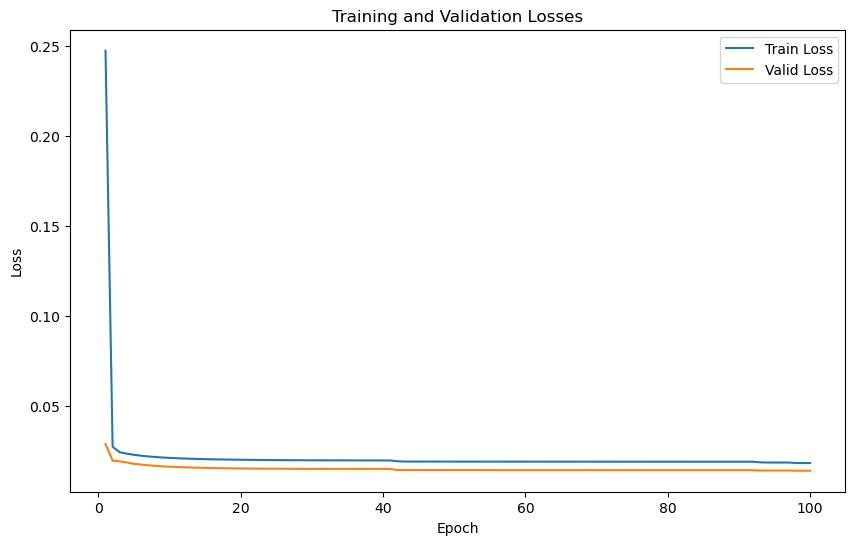

In [73]:
if new_combined == 1:    
    # Training loop
    num_epochs = 100
    train_losses = []
    valid_losses = []

    # Keep track of the best validation loss and the corresponding epoch
    best_valid_loss = float('inf')
    best_epoch = None
    patience = 10  # Number of epochs to wait for improvement before early stopping
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # Use tqdm to monitor progress for the training loop
        with tqdm(train_loader, unit="batch") as tepoch:
            for rainfall_batch, flood_batch, feature_batch, date_batch in tepoch:
                #rainfall_batch = rainfall_batch.to(device)
                flood_batch = flood_batch.to(device)
                feature_batch = feature_batch.to(device)
                #date_batch = date_batch.to(device)
                
                optimizer.zero_grad()

                #current_batch_size, sequence_length, _, _ = rainfall_batch.size()
                #rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
                current_batch_size, sequence_length, _, _ = flood_batch.size()
                flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)
                
                flood_input = flood_batch[:, :-1, :]
                flood_target = flood_batch[:, -1, :].unsqueeze(1)
                
                #output = model(rainfall_batch, flood_input, date_batch)
                output = model(flood_input, feature_batch)
                
                # Reshape the output to match the downscaled_resolution
                current_batch_size, sequence_length, _, _ = output.size()
                output = output.view(current_batch_size, sequence_length, output_size)
                
                loss = criterion(output, flood_target)  # Use flood_batch as target
                loss.backward()
                
                # Clip gradients using nn.utils.clip_grad_norm_
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                optimizer.step()

                total_train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        # Calculate and store average training loss for this epoch
        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation loop (assuming you have a validation set)
        model.eval()
        total_valid_loss = 0

        # Use tqdm to monitor progress for the validation loop
        with tqdm(valid_loader, unit="batch") as tvalid:
            with torch.no_grad():
                for rainfall_batch, flood_batch, feature_batch, date_batch in tvalid:
                    #rainfall_batch = rainfall_batch.to(device)
                    flood_batch = flood_batch.to(device)
                    feature_batch = feature_batch.to(device)
                    #date_batch = date_batch.to(device)

                    optimizer.zero_grad()

                    #current_batch_size, sequence_length, _, _ = rainfall_batch.size()
                    #rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
                    current_batch_size, sequence_length, _, _ = flood_batch.size()
                    flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)

                    flood_input = flood_batch[:, :-1, :]
                    flood_target = flood_batch[:, -1, :].unsqueeze(1)

                    #output = model(rainfall_batch, flood_input, date_batch)
                    output = model(flood_input, feature_batch)

                    # Reshape the output to match the downscaled_resolution
                    current_batch_size, sequence_length, _, _ = output.size()
                    output = output.view(current_batch_size, sequence_length, output_size)

                    loss = criterion(output, flood_target)  # Use flood_batch as target
                    total_valid_loss += loss.item()
                    tvalid.set_postfix(loss=loss.item())

        # Calculate and store average validation loss for this epoch
        valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)

        # Print epoch-wise losses
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

        # Update the learning rate scheduler based on the validation loss
        scheduler.step(valid_loss)

        # Save the model state if the validation loss has improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch + 1
            epochs_without_improvement = 0  # Reset the counter for lack of improvement
            model_state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'valid_losses': valid_losses,
            }
            save_path = os.path.join(save_dir, f"combined_model_best.pt")
            torch.save(model_state, save_path)
            print(f"Best model state saved at epoch {epoch + 1}")

        else:
            epochs_without_improvement += 1

        # Early stopping: If both lack of improvement and stagnation occur for the specified patience, stop training
        if epochs_without_improvement >= patience:
            print(f"Stopping early as validation loss has not improved or stagnated for {patience} consecutive epochs.")
            break

    # Plot the losses over time
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.savefig("combined_losses.png")
    plt.show()

In [74]:
if new_combined == 1:
    # Generate a file link for the best model
    best_combined_link = FileLink(save_path)
    print("Download the best model:", best_combined_link)

Download the best model: /kaggle/working/combined_models/combined_model_best.pt


In [75]:
# Load the saved model state (best model)
if new_combined == 1:
    model_path = "/kaggle/working/combined_models/combined_model_best.pt"  # Replace with the actual path to the saved best model state
else:
    model_path = "/kaggle/input/combined-model-1/combined_model_best.pt"  # Replace with the actual path to the saved model state

checkpoint = torch.load(model_path)

# Load the best model state
model_state_dict = checkpoint['state_dict']
model_dict = model.state_dict()

# Filter out the missing keys and load only the matching keys
model_state_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model_dict.update(model_state_dict)
model.load_state_dict(model_dict)
model.eval()

# Test the model on the test set and calculate the loss
input_images = []
real_images = []
predicted_images = []

with torch.no_grad(), tqdm(test_loader, unit="batch") as ttest:
    for rainfall_batch, flood_batch, feature_batch, date_batch in ttest:
        rainfall_batch = rainfall_batch.to(device)
        flood_batch = flood_batch.to(device)
        feature_batch = feature_batch.to(device)
        #date_batch = date_batch.to(device)
        
        current_batch_size, sequence_length, _, _ = rainfall_batch.size()
        rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
        current_batch_size, sequence_length, _, _ = flood_batch.size()
        flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)

        flood_input = flood_batch[:, :-1, :]
        flood_target = flood_batch[:, -1, :].unsqueeze(1)

        #output = model(rainfall_batch, flood_input, date_batch)
        output = model(flood_input, feature_batch)
        
        # Reshape the output to match the downscaled_resolution
        current_batch_size, sequence_length, _, _ = output.size()
        output = output.view(current_batch_size, sequence_length, output_size)

        rainfall_final = rainfall_batch[:, sequence_length-1, :].unsqueeze(1)
        rainfall_final = rainfall_final.view(current_batch_size, sequence_length, output_size)
        
        output = torch.round(torch.sigmoid(output))
        #output = torch.clamp(output, 0, 1)
        
        # Append the input and predicted rainfall sequences to their respective lists
        input_images.extend(rainfall_final.cpu().numpy())
        real_images.extend(flood_target.cpu().numpy())
        predicted_images.extend(output.cpu().numpy())

# Convert the lists to numpy arrays
input_images = np.array(input_images)
real_images = np.array(real_images)
predicted_images = np.array(predicted_images)

#messy_predicted_images = predicted_images

# Round the predicted images
#predicted_images = np.round(1 / (1 + np.exp(-predicted_images)))
#predicted_images = np.clip(predicted_images, 0, 1)  # Clipping
#predicted_images = np.round(predicted_images)

100%|██████████| 46/46 [00:01<00:00, 34.84batch/s]


In [76]:
print(input_images.shape)
print(real_images.shape)
print(predicted_images.shape)

# Print the first values in the first image for each set
print("First values in the first image for each set:")
print("Input Images:")
print(input_images[0, 0])
print("Real Images:")
print(real_images[0, 0])
print("Predicted Images:")
print(predicted_images[0, 0])
#print("Unnormalized Predicted Images:")
#print(messy_predicted_images[0, 0])

(1455, 1, 1440)
(1455, 1, 1440)
(1455, 1, 1440)
First values in the first image for each set:
Input Images:
[0. 0. 0. ... 0. 0. 0.]
Real Images:
[0. 0. 0. ... 0. 0. 0.]
Predicted Images:
[0. 0. 0. ... 0. 0. 0.]


Best Prediction:


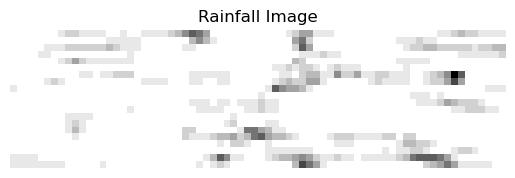

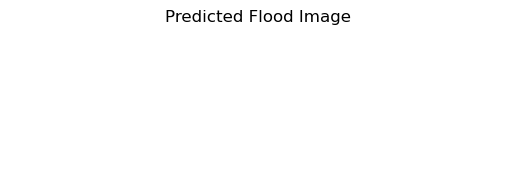

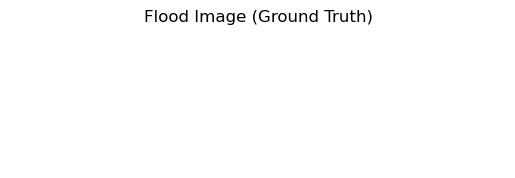

Best Image
F1-Score: 1.0000
Middle Prediction:


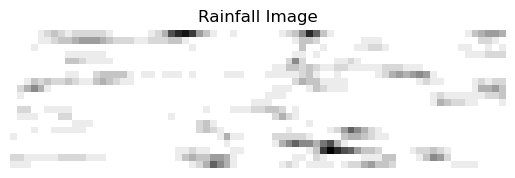

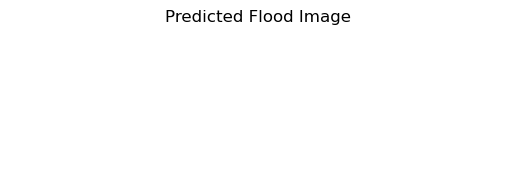

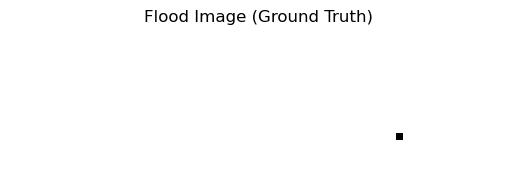

Middle Image
F1-Score: 0.0000
Worst Prediction:


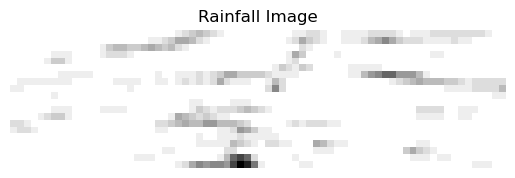

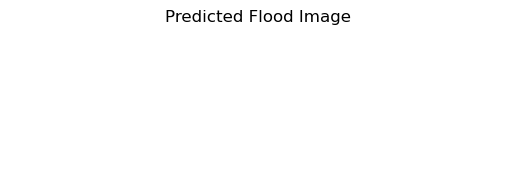

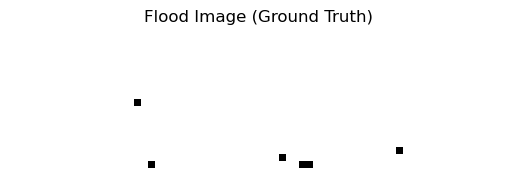

Worst Image
F1-Score: 0.0000
Average Precision: 1.0000, Average Recall: 0.0694, Average F1-Score: 0.0694


In [77]:
# Calculate metrics for all predicted flood images
metrics = [calculate_metrics(real_images[i, 0], predicted_images[i, 0]) for i in range(len(predicted_images))]

# Sort the images based on their F1-scores in descending order
sorted_indices = sorted(range(len(metrics)), key=lambda k: metrics[k][2], reverse=True)

# Display the best, middle, and worst predictions
best_n = 1
middle_n = 1
worst_n = 1

# Display the best prediction
print("Best Prediction:")
index = sorted_indices[0]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("best_rainfall_combined.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("best_predicted_combined.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("best_real_combined.png")
plt.show()

print(f"Best Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the middle prediction
print("Middle Prediction:")
index = sorted_indices[len(sorted_indices) // 2]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("middle_rainfall_combined.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("middle_predicted_combined.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("middle_real_combined.png")
plt.show()

print(f"Middle Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the worst prediction
print("Worst Prediction:")
index = sorted_indices[-1]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("worst_rainfall_combined.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("worst_predicted_combined.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("worst_real_combined.png")
plt.show()

print(f"Worst Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Calculate the average metrics for all predicted flood images
precision_scores = [m[0] for m in metrics]
recall_scores = [m[1] for m in metrics]
f1_scores = [m[2] for m in metrics]
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)
print(f"Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-Score: {average_f1:.4f}")

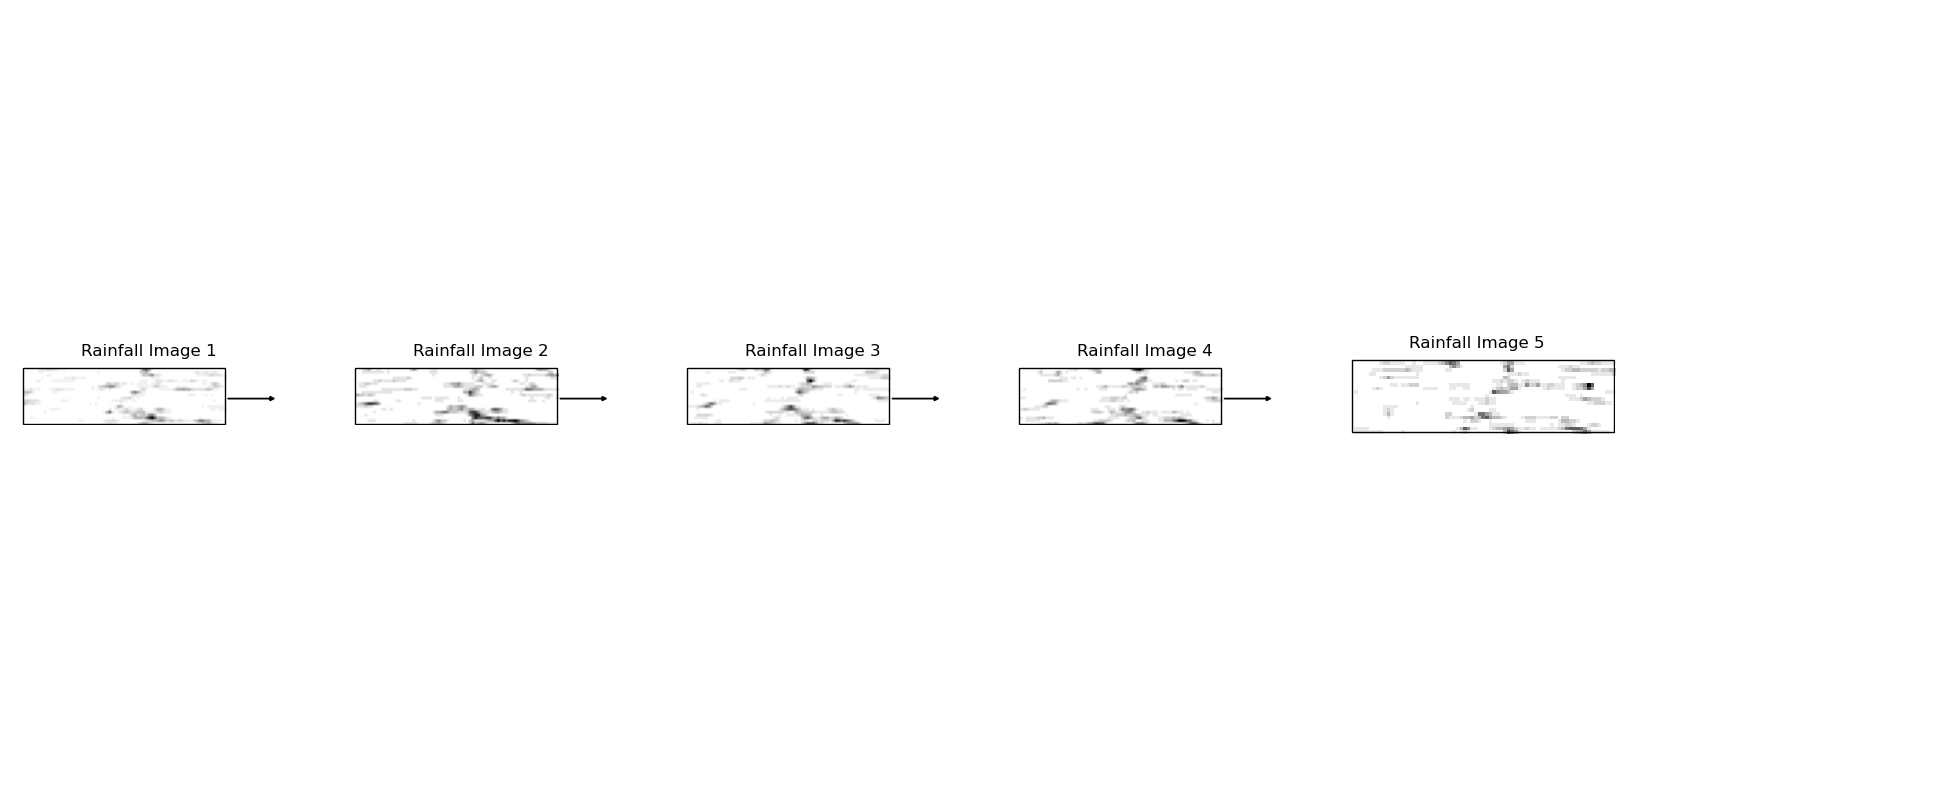

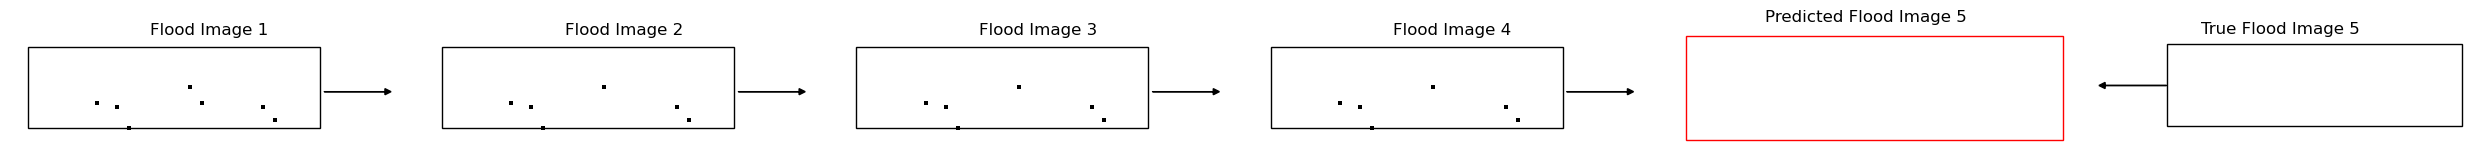

Example 312
F1-Score: 1.0000


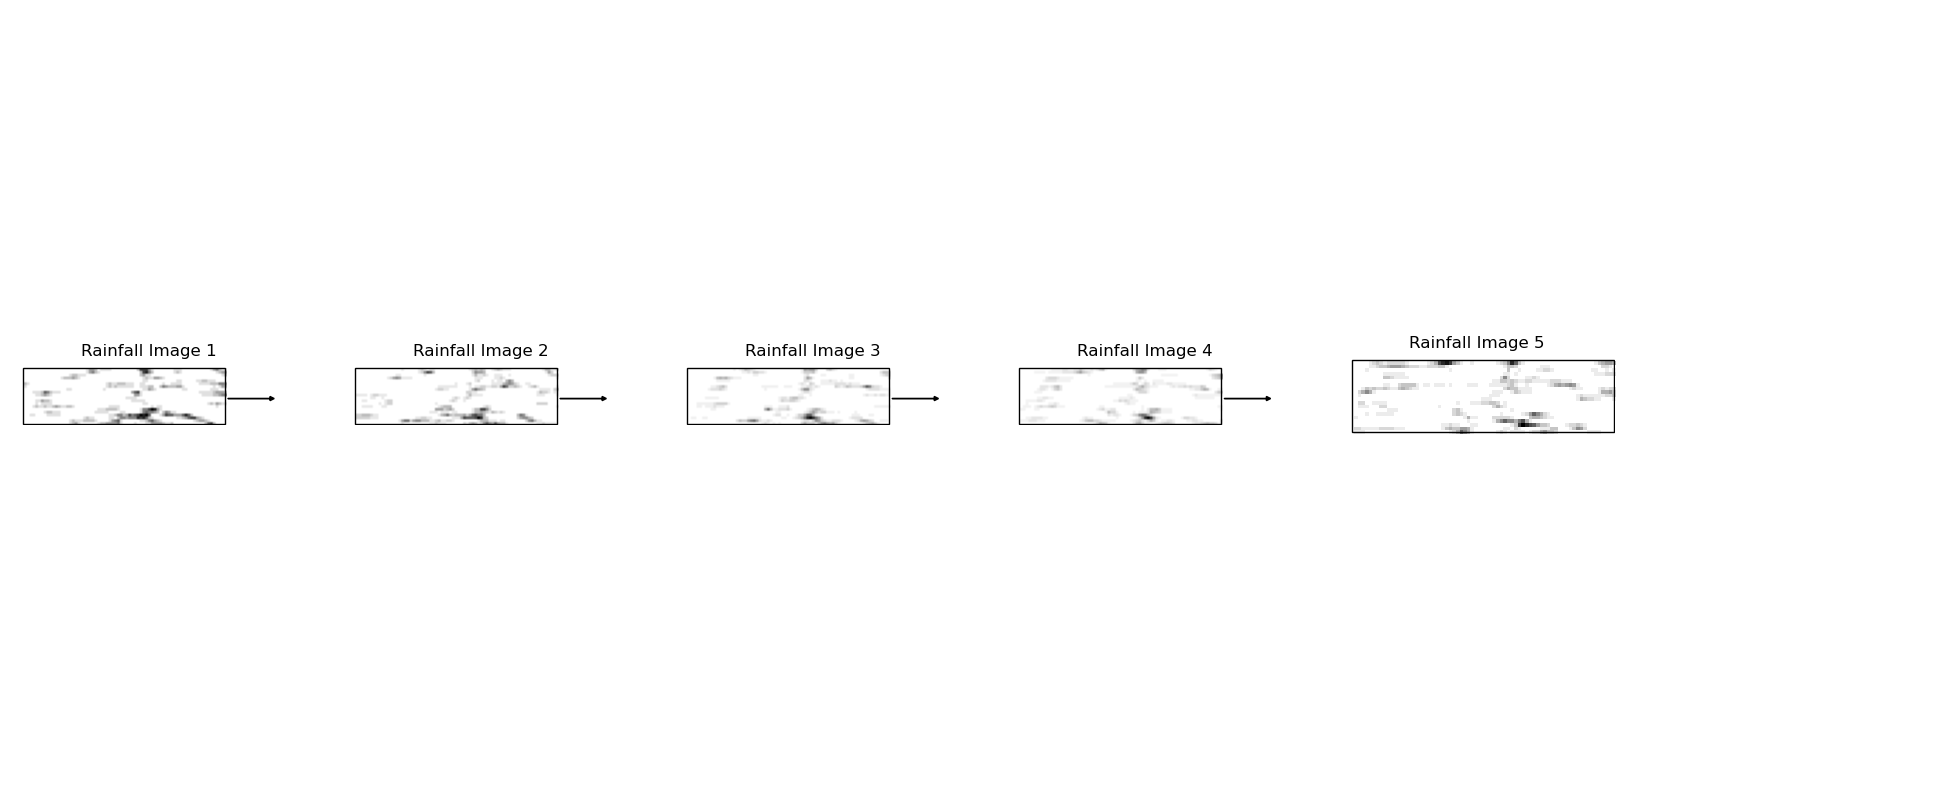

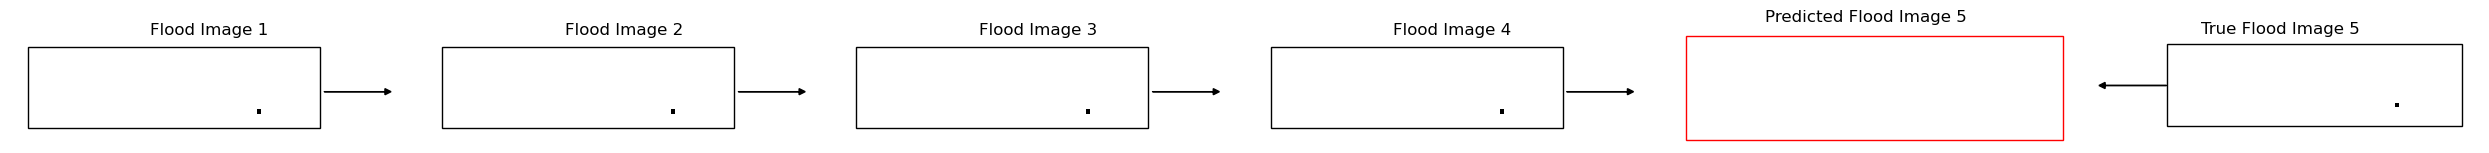

Example 658
F1-Score: 0.0000


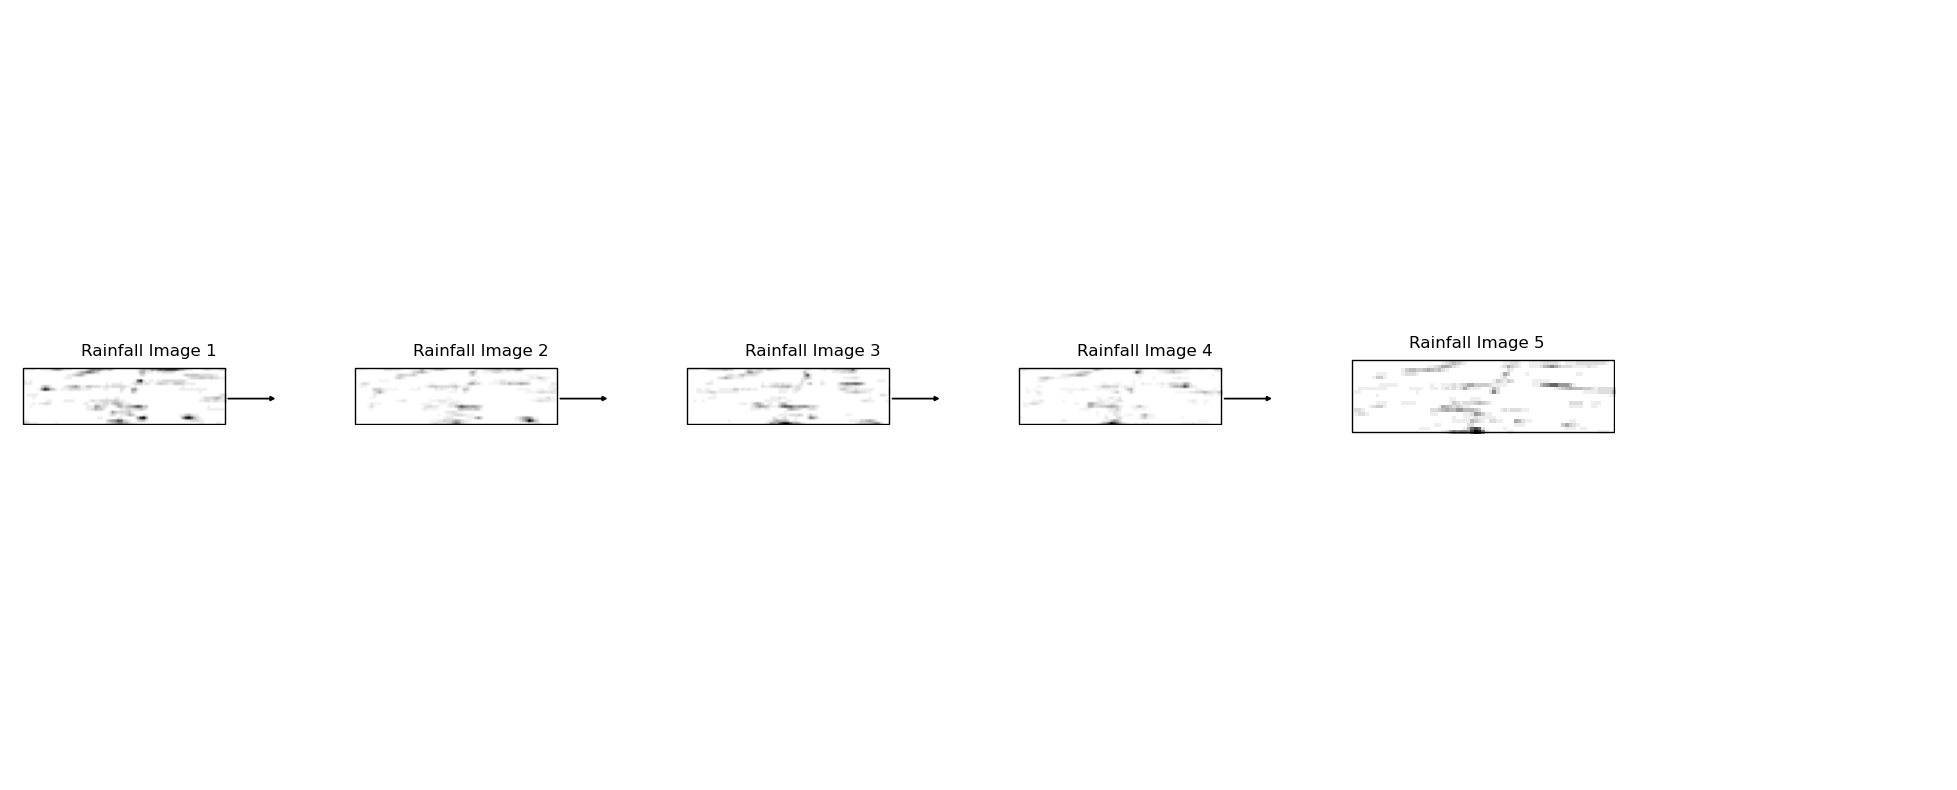

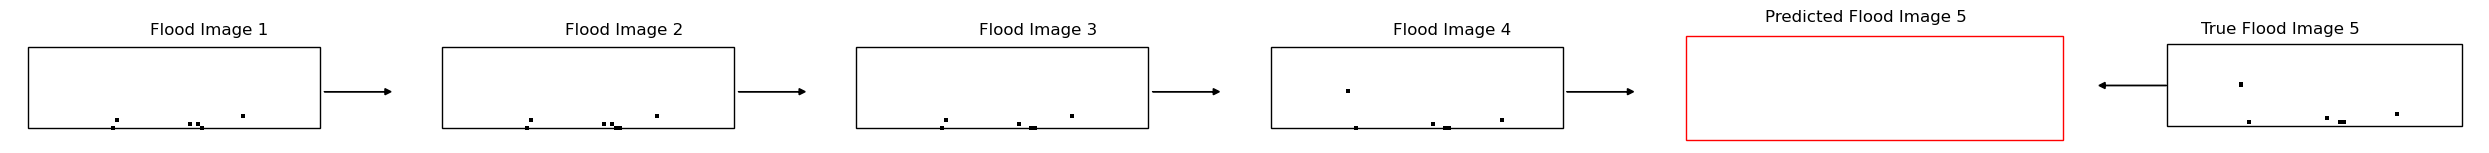

Example 1455
F1-Score: 0.0000


In [78]:
# Display examples of highest scoring, lowest scoring, and median scoring predictions
examples_indices = [sorted_indices[0], sorted_indices[len(sorted_indices) // 2], sorted_indices[-1]]
filenames = ["best", "middle", "worst"]
count = 0

for index in examples_indices:
    # Get the indices of the images for this example
    image_indices = [index - 4, index - 3, index - 2, index - 1, index, index]

    # Create two separate figures with a 1x6 layout
    fig1, axs1 = plt.subplots(1, 6, figsize=(25, 10))
    fig2, axs2 = plt.subplots(1, 6, figsize=(25, 10))
    
    plt.subplots_adjust(wspace=0.1)  # Adjust horizontal spacing

    for i, img_index in enumerate(image_indices):
        input_img = input_images[img_index, 0]
        real_img = real_images[img_index, 0]
        pred_img = predicted_images[img_index, 0]

        # Reshape and resize rainfall images to downscaled_resolution for display
        input_img_resized = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        real_img_resized = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        pred_img_resized = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

        # Convert NumPy arrays to images using PIL
        input_img_pil = Image.fromarray((input_img_resized * 255).astype(np.uint8), mode='L')
        real_img_pil = Image.fromarray((real_img_resized * 255).astype(np.uint8), mode='L')
        pred_img_pil = Image.fromarray((pred_img_resized * 255).astype(np.uint8), mode='L')

        if i <= 3:
            axs1[i].imshow(input_img_pil, cmap='binary')
            axs1[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs1[i].set_title('Rainfall Image '+str(i+1))
            axs1[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs1[i].axis('off')

            axs2[i].imshow(real_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs2[i].set_title('Flood Image '+str(i+1))
            axs2[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs2[i].axis('off')

        if i == 4:
            axs1[i].imshow(input_img_pil, cmap='binary')
            axs1[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs1[i].set_title('Rainfall Image '+str(i+1))
            axs1[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0.01, head_length=0, fc='white', ec='white')
            axs1[i].axis('off')

            axs2[i].imshow(pred_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='red'))
            axs2[i].set_title('Predicted Flood Image '+str(i+1))
            axs2[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0, head_length=0, fc='white', ec='white')
            axs2[i].axis('off')
            
        if i == 5:
            axs1[i].axis('off')

            axs2[i].imshow(real_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((0, 0), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs2[i].arrow(0, downscaled_resolution[1]/2, -15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs2[i].set_title('True Flood Image '+str(i))
            axs2[i].axis('off')

    plt.tight_layout()
    fig1.savefig(filenames[count]+"_combined_rainfall_sequence.png")
    fig2.savefig(filenames[count]+"_combined_flood_sequence.png")
    count+=1
    plt.show()

    print(f"Example {index + 1}")
    print(f"F1-Score: {metrics[index][2]:.4f}")
    print("=" * 50)

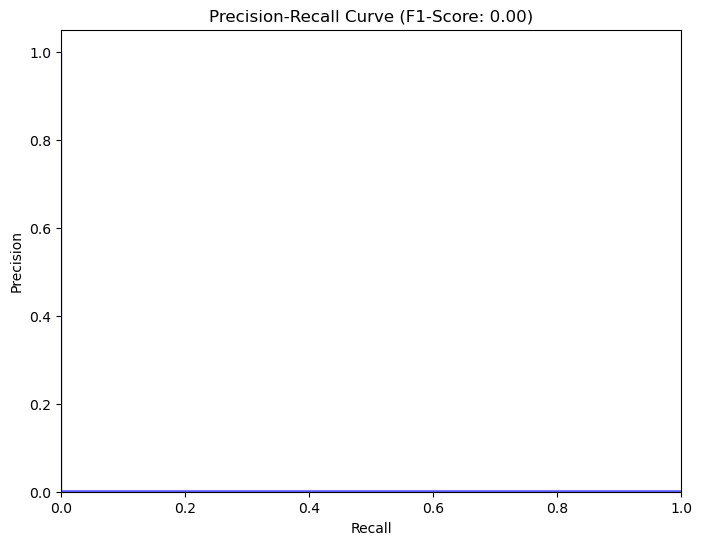

In [79]:
# Flatten the real and predicted images
real_labels = real_images.flatten()
predicted_scores = predicted_images.flatten()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(real_labels, predicted_scores)

# Calculate F1-score
f1 = f1_score(real_labels, np.round(predicted_scores))

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (F1-Score: {:.2f})'.format(f1))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.savefig("combined_curve.png")
plt.show()

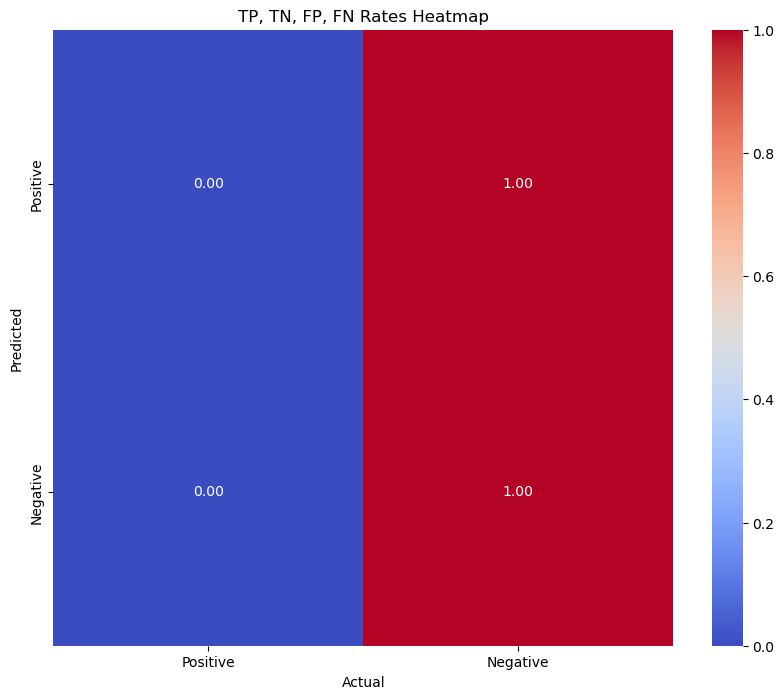

In [80]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(real_labels, np.round(predicted_scores))

# Calculate true positive (TP), true negative (TN), false positive (FP), false negative (FN) rates
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate rates
TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity/Recall)
TNR = TN / (TN + FP)  # True Negative Rate (Specificity)
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate

# Create heatmaps for TP, TN, FP, FN rates
rates = np.array([[TPR, FNR], [FPR, TNR]])

plt.figure(figsize=(10, 8))
sns.heatmap(rates, annot=True, fmt=".2f", cmap='coolwarm', center=0.5,
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('TP, TN, FP, FN Rates Heatmap')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig("combined_heatmap.png")
plt.show()

In [81]:
class ConvLSTMCell(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        kernel_size: int,
        bias: bool,
    ):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = (kernel_size, kernel_size)
        self.padding = self.kernel_size[0] // 2, self.kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            stride=1,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        # concatenate along channel axis
        combined = torch.cat([input_tensor, h_cur], dim=1)

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (
            torch.zeros(
                batch_size,
                self.hidden_dim,
                height,
                width,
                device=self.conv.weight.device,
            ),
        ) * 2


class ConvLSTM(nn.Module):
    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(
        self,
        input_dim,
        hidden_dim,
        kernel_size,
        num_layers=1,
        batch_first=True,
        bias=True,
        return_all_layers=False,
    ):
        super().__init__()
        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        assert (
            len(kernel_size) == len(hidden_dim) == num_layers
        ), "Inconsistent list length."

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(
                ConvLSTMCell(
                    input_dim=cur_input_dim,
                    hidden_dim=self.hidden_dim[i],
                    kernel_size=self.kernel_size[i],
                    bias=self.bias,
                )
            )

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Since the init is done in forward. Can send image size here
        hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](
                    input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c]
                )
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _extend_for_multilayer(param, num_layers: int):
        if isinstance(param, int):
            return (param,) * num_layers
        elif isinstance(param, list):
            return tuple(param)
        else:
            return param

In [82]:
class ImageConvLSTM(nn.Module):
    #def __init__(self, rainfall_input_size, feature_input_size, date_input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
    def __init__(self, rainfall_input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(ImageConvLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = rainfall_input_size

        # ConvLSTM layer to process sequential data
        self.rainfall_convlstm = ConvLSTM(input_dim=1, hidden_dim=[256] * num_layers, kernel_size=(3, 3),
                                  num_layers=num_layers, batch_first=True, bias=True, return_all_layers=False)
        
        self.flood_convlstm = ConvLSTM(input_dim=1, hidden_dim=[256] * num_layers, kernel_size=(3, 3),
                                  num_layers=num_layers, batch_first=True, bias=True, return_all_layers=False)
        
        self.mapping_layer = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)  # Linear mapping

        # LSTM layers to process sequential image data for each input channel
        #self.feature_lstm = nn.LSTM(feature_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        #self.date_lstm = nn.LSTM(date_input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)

        # Add attention layers
        #self.lstm_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4)

        # Batch normalization along the feature dimension
        self.convlstm_batch_norm = nn.BatchNorm1d(output_size)
        #self.lstm_batch_norm = nn.BatchNorm1d(hidden_size * 2)

        # Add Multihead Attention layer for rainfall ConvLSTM output
        self.convlstm_attention = nn.MultiheadAttention(embed_dim=output_size, num_heads=4)

        # Output layer to generate predictions
        #self.fc = nn.Linear(hidden_size * 2, output_size)  # Concatenate ConvLSTM and LSTM outputs

    #def forward(self, rainfall_batch, flood_batch, feature_maps, date_tensors):
    def forward(self, rainfall_batch, flood_batch):
        # rainfall_batch shape: (batch_size, sequence_length, rainfall_input_size)
        # date_tensors shape: (batch_size, sequence_length, date_input_size)

        current_batch_size, sequence_length, _ = rainfall_batch.size()
        
        # Reshape rainfall_batch to match the ConvLSTM input dimensions
        rainfall_convlstm_input = rainfall_batch.view(current_batch_size, sequence_length, 1, downscaled_resolution[0], downscaled_resolution[1])

        # Process rainfall_batch with ConvLSTM
        rainfall_convlstm_output, _ = self.rainfall_convlstm(rainfall_convlstm_input)

        # Reshape ConvLSTM output to match LSTM output dimensions
        rainfall_convlstm_output = rainfall_convlstm_output[0] # Extract the last hidden state
        rainfall_convlstm_output = rainfall_convlstm_output[:, -1, :, :, :].squeeze(1) 
        rainfall_convlstm_output = self.mapping_layer(rainfall_convlstm_output)  # Map the hidden state

        # Reshape ConvLSTM output to [batch_size, desired_dim, downscaled_resolution[0] * downscaled_resolution[1]]
        rainfall_convlstm_output = rainfall_convlstm_output.view(current_batch_size, 1, output_size)
        
        current_batch_size, sequence_length, _ = flood_batch.size()
        
        # Reshape rainfall_batch to match the ConvLSTM input dimensions
        flood_convlstm_input = flood_batch.view(current_batch_size, sequence_length, 1, downscaled_resolution[0], downscaled_resolution[1])

        # Process rainfall_batch with ConvLSTM
        flood_convlstm_output, _ = self.flood_convlstm(flood_convlstm_input)

        # Reshape ConvLSTM output to match LSTM output dimensions
        flood_convlstm_output = flood_convlstm_output[0] # Extract the last hidden state
        flood_convlstm_output = flood_convlstm_output[:, -1, :, :, :].squeeze(1) 
        flood_convlstm_output = self.mapping_layer(flood_convlstm_output)  # Map the hidden state

        # Reshape ConvLSTM output to [batch_size, desired_dim, downscaled_resolution[0] * downscaled_resolution[1]]
        flood_convlstm_output = flood_convlstm_output.view(current_batch_size, 1, output_size)

        # Process feature maps with LSTM
        #feature_lstm_output, _ = self.feature_lstm(feature_maps)

        # Process date_tensors with LSTM
        #date_lstm_output, _ = self.date_lstm(date_tensors)

        # Apply Multihead Attention to the ConvLSTM outputs
        with torch.no_grad():
            rainfall_convlstm_attn_output, _ = self.convlstm_attention(
                rainfall_convlstm_output,  # Transpose dimensions
                rainfall_convlstm_output,  # Transpose dimensions
                rainfall_convlstm_output   # Transpose dimensions
            )
            flood_convlstm_attn_output, _ = self.convlstm_attention(
                flood_convlstm_output,  # Transpose dimensions
                flood_convlstm_output,  # Transpose dimensions
                flood_convlstm_output   # Transpose dimensions
            )
        combined_rainfall_convlstm_output = rainfall_convlstm_output + rainfall_convlstm_attn_output
        combined_flood_convlstm_output = flood_convlstm_output + flood_convlstm_attn_output
        
        combined_convlstm_output = combined_rainfall_convlstm_output + combined_flood_convlstm_output

        # Apply Multihead Attention to the LSTM outputs
        #with torch.no_grad():
            #feature_attn_output, _ = self.lstm_attention(feature_lstm_output, feature_lstm_output, feature_lstm_output)
            #date_attn_output, _ = self.lstm_attention(date_lstm_output, date_lstm_output, date_lstm_output)
            
        #combined_feature_output = feature_lstm_output + feature_attn_output
        #combined_date_output = date_lstm_output + date_attn_output

        # Concatenate the LSTM outputs along the feature dimension (dim=2)
        #combined_lstm_output = torch.cat((combined_feature_output, combined_date_output), dim=2)

        # Batch normalization along the sequence_length dimension
        combined_convlstm_output = combined_convlstm_output.permute(0, 2, 1)
        combined_convlstm_output = self.convlstm_batch_norm(combined_convlstm_output)
        combined_convlstm_output = combined_convlstm_output.permute(0, 2, 1)
        
        # Batch normalization along the sequence_length dimension
        #combined_lstm_output = combined_lstm_output.permute(0, 2, 1)
        #combined_lstm_output = self.lstm_batch_norm(combined_lstm_output)
        #combined_lstm_output = combined_lstm_output.permute(0, 2, 1)

        # Apply fully connected layer
        #combined_lstm_output = self.fc(combined_lstm_output)
        
        # Element-wise addition to combine the predictions
        #output = combined_convlstm_output + combined_lstm_output
        output = combined_convlstm_output
        
        # Apply sigmoid activation to the combined predictions
        #output = torch.round(torch.sigmoid(predicted_images))
        
        # Reshape the output to match the downscaled_resolution
        current_batch_size, sequence_length, _ = output.size()
        output = output.view(current_batch_size, 1, downscaled_resolution[0], downscaled_resolution[1])

        return output

In [83]:
# Define the input size based on the feature vector size
input_size = downscaled_resolution[0] * downscaled_resolution[1]

# Assuming you have already defined train_loader, valid_loader, and other variables
rainfall_input_size = input_size  # Adjust this based on the size of the feature maps
feature_input_size = 1000
date_input_size = 65  # Adjust this based on the size of the date tensors
output_size = input_size

hidden_size = 128
num_layers = 2
output_size = input_size
dropout_prob = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = ImageConvLSTM(rainfall_input_size, feature_input_size, date_input_size, hidden_size, num_layers, output_size, dropout_prob)  # Use ConvLSTM class
model = ImageConvLSTM(rainfall_input_size, hidden_size, num_layers, output_size, dropout_prob)  # Use ConvLSTM class
model.to(device)

# Define the loss function and optimizer with L2 regularization (weight decay)
learning_rate = 0.001
weight_decay = 1e-5  # You can adjust the weight decay strength
# Gradient clipping
max_grad_norm = 1.0  # Adjust as needed
#criterion = nn.MSELoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0))
#criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
#criterion = FocalLoss(alpha=1, gamma=1, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Set the directory where you want to save the model state
save_dir = "/kaggle/working/convrnn_models"
os.makedirs(save_dir, exist_ok=True)

In [84]:
new_convrnn = 1

100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.758]


Epoch [1/100], Train Loss: 0.6538, Valid Loss: 0.7567
Best model state saved at epoch 1


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.694]


Epoch [2/100], Train Loss: 0.5830, Valid Loss: 0.6938
Best model state saved at epoch 2


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.859]


Epoch [3/100], Train Loss: 0.5213, Valid Loss: 0.8597


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.365]


Epoch [4/100], Train Loss: 0.4672, Valid Loss: 0.3650
Best model state saved at epoch 4


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.461]


Epoch [5/100], Train Loss: 0.4197, Valid Loss: 0.4613


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.349]


Epoch [6/100], Train Loss: 0.3781, Valid Loss: 0.3494
Best model state saved at epoch 6


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.372]


Epoch [7/100], Train Loss: 0.3415, Valid Loss: 0.3731


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.335]


Epoch [8/100], Train Loss: 0.3095, Valid Loss: 0.3365
Best model state saved at epoch 8


100%|██████████| 46/46 [00:27<00:00,  1.67batch/s, loss=0.312]


Epoch [9/100], Train Loss: 0.2813, Valid Loss: 0.3136
Best model state saved at epoch 9


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.249]


Epoch [10/100], Train Loss: 0.2564, Valid Loss: 0.2505
Best model state saved at epoch 10


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.212]


Epoch [11/100], Train Loss: 0.2345, Valid Loss: 0.2131
Best model state saved at epoch 11


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.189]


Epoch [12/100], Train Loss: 0.2151, Valid Loss: 0.1900
Best model state saved at epoch 12


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.183]


Epoch [13/100], Train Loss: 0.1978, Valid Loss: 0.1843
Best model state saved at epoch 13


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.169]


Epoch [14/100], Train Loss: 0.1825, Valid Loss: 0.1699
Best model state saved at epoch 14


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.152]


Epoch [15/100], Train Loss: 0.1689, Valid Loss: 0.1527
Best model state saved at epoch 15


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.145]


Epoch [16/100], Train Loss: 0.1567, Valid Loss: 0.1463
Best model state saved at epoch 16


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.134]


Epoch [17/100], Train Loss: 0.1459, Valid Loss: 0.1358
Best model state saved at epoch 17


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.135]


Epoch [18/100], Train Loss: 0.1361, Valid Loss: 0.1361


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.117]


Epoch [19/100], Train Loss: 0.1274, Valid Loss: 0.1185
Best model state saved at epoch 19


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.108]


Epoch [20/100], Train Loss: 0.1195, Valid Loss: 0.1090
Best model state saved at epoch 20


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.107]


Epoch [21/100], Train Loss: 0.1124, Valid Loss: 0.1084
Best model state saved at epoch 21


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0967]


Epoch [22/100], Train Loss: 0.1061, Valid Loss: 0.0982
Best model state saved at epoch 22


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0902]


Epoch [23/100], Train Loss: 0.1003, Valid Loss: 0.0917
Best model state saved at epoch 23


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0947]


Epoch [24/100], Train Loss: 0.0952, Valid Loss: 0.0964


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0839]


Epoch [25/100], Train Loss: 0.0905, Valid Loss: 0.0855
Best model state saved at epoch 25


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0815]


Epoch [26/100], Train Loss: 0.0863, Valid Loss: 0.0832
Best model state saved at epoch 26


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0788]


Epoch [27/100], Train Loss: 0.0825, Valid Loss: 0.0805
Best model state saved at epoch 27


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0736]


Epoch [28/100], Train Loss: 0.0791, Valid Loss: 0.0753
Best model state saved at epoch 28


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.078] 


Epoch [29/100], Train Loss: 0.0761, Valid Loss: 0.0800


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0733]


Epoch [30/100], Train Loss: 0.0733, Valid Loss: 0.0752
Best model state saved at epoch 30


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0697]


Epoch [31/100], Train Loss: 0.0708, Valid Loss: 0.0716
Best model state saved at epoch 31


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0692]


Epoch [32/100], Train Loss: 0.0686, Valid Loss: 0.0712
Best model state saved at epoch 32


100%|██████████| 46/46 [00:27<00:00,  1.67batch/s, loss=0.0682]


Epoch [33/100], Train Loss: 0.0667, Valid Loss: 0.0702
Best model state saved at epoch 33


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0618]


Epoch [34/100], Train Loss: 0.0649, Valid Loss: 0.0637
Best model state saved at epoch 34


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0621]


Epoch [35/100], Train Loss: 0.0634, Valid Loss: 0.0640


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0647]


Epoch [36/100], Train Loss: 0.0621, Valid Loss: 0.0669


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0587]


Epoch [37/100], Train Loss: 0.0609, Valid Loss: 0.0607
Best model state saved at epoch 37


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0629]


Epoch [38/100], Train Loss: 0.0599, Valid Loss: 0.0650


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.066] 


Epoch [39/100], Train Loss: 0.0590, Valid Loss: 0.0683


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0581]


Epoch [40/100], Train Loss: 0.0583, Valid Loss: 0.0601
Best model state saved at epoch 40


100%|██████████| 46/46 [00:27<00:00,  1.67batch/s, loss=0.0563]


Epoch [41/100], Train Loss: 0.0577, Valid Loss: 0.0583
Best model state saved at epoch 41


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0648]


Epoch [42/100], Train Loss: 0.0572, Valid Loss: 0.0672


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0554]


Epoch [43/100], Train Loss: 0.0568, Valid Loss: 0.0574
Best model state saved at epoch 43


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0552]


Epoch [44/100], Train Loss: 0.0565, Valid Loss: 0.0572
Best model state saved at epoch 44


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0567]


Epoch [45/100], Train Loss: 0.0562, Valid Loss: 0.0588


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0538]


Epoch [46/100], Train Loss: 0.0560, Valid Loss: 0.0559
Best model state saved at epoch 46


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.055] 


Epoch [47/100], Train Loss: 0.0559, Valid Loss: 0.0571


100%|██████████| 46/46 [00:27<00:00,  1.67batch/s, loss=0.0582]


Epoch [48/100], Train Loss: 0.0558, Valid Loss: 0.0603


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0565]


Epoch [49/100], Train Loss: 0.0557, Valid Loss: 0.0586


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0617]


Epoch [50/100], Train Loss: 0.0556, Valid Loss: 0.0640
Epoch 00050: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0524]


Epoch [51/100], Train Loss: 0.0556, Valid Loss: 0.0544
Best model state saved at epoch 51


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0538]


Epoch [52/100], Train Loss: 0.0555, Valid Loss: 0.0558


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.057] 


Epoch [53/100], Train Loss: 0.0555, Valid Loss: 0.0592


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.052] 


Epoch [54/100], Train Loss: 0.0555, Valid Loss: 0.0539
Best model state saved at epoch 54


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0553]


Epoch [55/100], Train Loss: 0.0555, Valid Loss: 0.0574


100%|██████████| 46/46 [00:27<00:00,  1.67batch/s, loss=0.0539]


Epoch [56/100], Train Loss: 0.0555, Valid Loss: 0.0559


100%|██████████| 46/46 [00:27<00:00,  1.67batch/s, loss=0.0583]


Epoch [57/100], Train Loss: 0.0555, Valid Loss: 0.0605


100%|██████████| 46/46 [00:27<00:00,  1.67batch/s, loss=0.0586]


Epoch [58/100], Train Loss: 0.0555, Valid Loss: 0.0608
Epoch 00058: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.05]  


Epoch [59/100], Train Loss: 0.0555, Valid Loss: 0.0520
Best model state saved at epoch 59


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0485]


Epoch [60/100], Train Loss: 0.0554, Valid Loss: 0.0505
Best model state saved at epoch 60


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0484]


Epoch [61/100], Train Loss: 0.0554, Valid Loss: 0.0504
Best model state saved at epoch 61


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0484]


Epoch [62/100], Train Loss: 0.0554, Valid Loss: 0.0503
Best model state saved at epoch 62


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0483]


Epoch [63/100], Train Loss: 0.0554, Valid Loss: 0.0503
Best model state saved at epoch 63


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0487]


Epoch [64/100], Train Loss: 0.0554, Valid Loss: 0.0506


100%|██████████| 46/46 [00:27<00:00,  1.67batch/s, loss=0.0485]


Epoch [65/100], Train Loss: 0.0554, Valid Loss: 0.0505


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0489]


Epoch [66/100], Train Loss: 0.0554, Valid Loss: 0.0508


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0487]


Epoch [67/100], Train Loss: 0.0554, Valid Loss: 0.0506
Epoch 00067: reducing learning rate of group 0 to 1.2500e-04.


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0478]


Epoch [68/100], Train Loss: 0.0554, Valid Loss: 0.0497
Best model state saved at epoch 68


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0475]


Epoch [69/100], Train Loss: 0.0554, Valid Loss: 0.0494
Best model state saved at epoch 69


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0472]


Epoch [70/100], Train Loss: 0.0554, Valid Loss: 0.0491
Best model state saved at epoch 70


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0481]


Epoch [71/100], Train Loss: 0.0554, Valid Loss: 0.0500


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0481]


Epoch [72/100], Train Loss: 0.0554, Valid Loss: 0.0500


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0481]


Epoch [73/100], Train Loss: 0.0554, Valid Loss: 0.0500


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0485]


Epoch [74/100], Train Loss: 0.0554, Valid Loss: 0.0504
Epoch 00074: reducing learning rate of group 0 to 6.2500e-05.


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0471]


Epoch [75/100], Train Loss: 0.0554, Valid Loss: 0.0490
Best model state saved at epoch 75


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0472]


Epoch [76/100], Train Loss: 0.0554, Valid Loss: 0.0491


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0473]


Epoch [77/100], Train Loss: 0.0554, Valid Loss: 0.0491


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0476]


Epoch [78/100], Train Loss: 0.0554, Valid Loss: 0.0495


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0473]


Epoch [79/100], Train Loss: 0.0554, Valid Loss: 0.0492
Epoch 00079: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0471]


Epoch [80/100], Train Loss: 0.0554, Valid Loss: 0.0490
Best model state saved at epoch 80


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0472]


Epoch [81/100], Train Loss: 0.0554, Valid Loss: 0.0491


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.047] 


Epoch [82/100], Train Loss: 0.0554, Valid Loss: 0.0489
Best model state saved at epoch 82


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0474]


Epoch [83/100], Train Loss: 0.0554, Valid Loss: 0.0493


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0474]


Epoch [84/100], Train Loss: 0.0554, Valid Loss: 0.0493


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0472]


Epoch [85/100], Train Loss: 0.0554, Valid Loss: 0.0491


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0474]


Epoch [86/100], Train Loss: 0.0554, Valid Loss: 0.0493
Epoch 00086: reducing learning rate of group 0 to 1.5625e-05.


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0472]


Epoch [87/100], Train Loss: 0.0554, Valid Loss: 0.0491


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0471]


Epoch [88/100], Train Loss: 0.0554, Valid Loss: 0.0490


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0472]


Epoch [89/100], Train Loss: 0.0554, Valid Loss: 0.0491


100%|██████████| 46/46 [00:27<00:00,  1.69batch/s, loss=0.0472]


Epoch [90/100], Train Loss: 0.0554, Valid Loss: 0.0491
Epoch 00090: reducing learning rate of group 0 to 7.8125e-06.


100%|██████████| 46/46 [00:27<00:00,  1.70batch/s, loss=0.0471]


Epoch [91/100], Train Loss: 0.0554, Valid Loss: 0.0490


100%|██████████| 46/46 [00:27<00:00,  1.68batch/s, loss=0.0471]


Epoch [92/100], Train Loss: 0.0554, Valid Loss: 0.0490
Stopping early as validation loss has not improved or stagnated for 10 consecutive epochs.


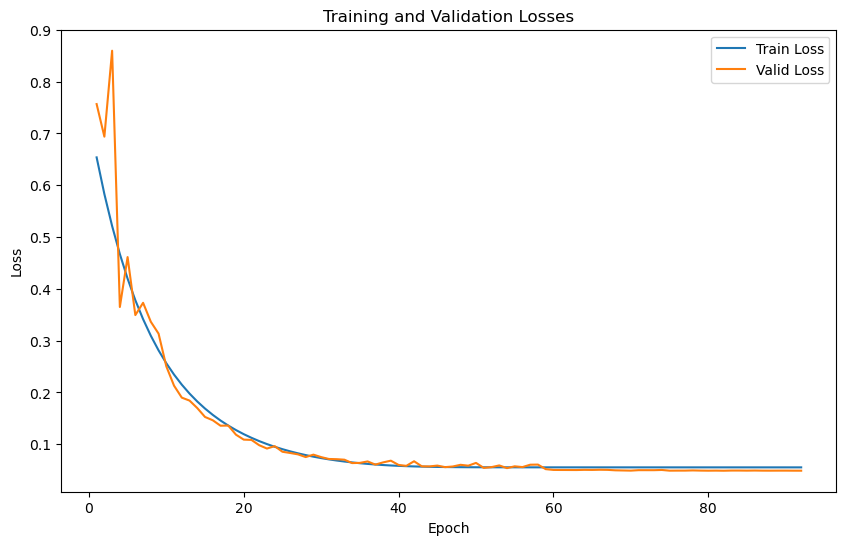

In [85]:
# Define the training loop
num_epochs = 100
train_losses = []
valid_losses = []

# Keep track of the best validation loss and the corresponding epoch
best_valid_loss = float('inf')
best_epoch = None
patience = 10  # Number of epochs to wait for improvement before early stopping

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    
    # Use tqdm to monitor progress for the training loop
    with tqdm(train_loader, unit="batch") as tepoch:
        for rainfall_batch, flood_batch, feature_batch, date_batch in tepoch:
            rainfall_batch = rainfall_batch.to(device)
            flood_batch = flood_batch.to(device)

            optimizer.zero_grad()

            current_batch_size, sequence_length, _, _ = rainfall_batch.size()
            rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
            current_batch_size, sequence_length, _, _ = flood_batch.size()
            flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)

            flood_input = flood_batch[:, :-1, :]
            flood_target = flood_batch[:, -1, :].unsqueeze(1)

            output = model(rainfall_batch, flood_input)

            current_batch_size, sequence_length, _, _ = output.size()
            output = output.view(current_batch_size, sequence_length, output_size)

            loss = criterion(output, flood_target)  # Use flood_batch as target
            loss.backward()

            optimizer.step()

            total_train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    # Calculate and store average training loss for this epoch
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop (assuming you have a validation set)
    model.eval()  # Set the model to evaluation mode
    total_valid_loss = 0

    # Use tqdm to monitor progress for the validation loop
    with tqdm(valid_loader, unit="batch") as tvalid:
        with torch.no_grad():
            for rainfall_batch, flood_batch, feature_batch, date_batch in tvalid:
                rainfall_batch = rainfall_batch.to(device)
                flood_batch = flood_batch.to(device)

                optimizer.zero_grad()

                current_batch_size, sequence_length, _, _ = rainfall_batch.size()
                rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
                current_batch_size, sequence_length, _, _ = flood_batch.size()
                flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)

                flood_input = flood_batch[:, :-1, :]
                flood_target = flood_batch[:, -1, :].unsqueeze(1)

                output = model(rainfall_batch, flood_input)

                current_batch_size, sequence_length, _, _ = output.size()
                output = output.view(current_batch_size, sequence_length, output_size)

                loss = criterion(output, flood_target)  # Use flood_batch as target
                total_valid_loss += loss.item()
                tvalid.set_postfix(loss=loss.item())

    # Calculate and store average validation loss for this epoch
    valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    # Print epoch-wise losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

    # Update the learning rate scheduler based on the validation loss
    scheduler.step(valid_loss)

    # Save the model state if the validation loss has improved
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch + 1
        epochs_without_improvement = 0  # Reset the counter for lack of improvement
        model_state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses,
        }
        save_path = os.path.join(save_dir, f"convrnn_best.pt")
        torch.save(model_state, save_path)
        print(f"Best model state saved at epoch {epoch + 1}")

    else:
        epochs_without_improvement += 1

    # Early stopping: If both lack of improvement and stagnation occur for the specified patience, stop training
    if epochs_without_improvement >= patience:
        print(f"Stopping early as validation loss has not improved or stagnated for {patience} consecutive epochs.")
        break

# Plot the losses over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.savefig("convlstm_losses.png")
plt.show()

In [86]:
if new_convrnn == 1:
    # Generate a file link for the best model
    best_convrnn_link = FileLink(save_path)
    print("Download the best model:", best_convrnn_link)

Download the best model: /kaggle/working/convrnn_models/convrnn_best.pt


In [87]:
# Load the saved model state (best model)
if new_convrnn == 1:
    model_path = "/kaggle/working/convrnn_models/convrnn_best.pt"  # Replace with the actual path to the saved best model state
else:
    model_path = "/kaggle/input/convrnn-model-1/convrnn_best.pt"  # Replace with the actual path to the saved model state

checkpoint = torch.load(model_path)

# Load the best model state
model_state_dict = checkpoint['state_dict']
model_dict = model.state_dict()

# Filter out the missing keys and load only the matching keys
model_state_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model_dict.update(model_state_dict)
model.load_state_dict(model_dict)
model.eval()

# Test the model on the test set and calculate the loss
input_images = []
real_images = []
predicted_images = []

with torch.no_grad(), tqdm(test_loader, unit="batch") as ttest:
    for rainfall_batch, flood_batch, feature_batch, date_batch in ttest:
        rainfall_batch = rainfall_batch.to(device)
        flood_batch = flood_batch.to(device)
        #feature_batch = feature_batch.to(device)
        #date_batch = date_batch.to(device)
        
        current_batch_size, sequence_length, _, _ = rainfall_batch.size()
        rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
        current_batch_size, sequence_length, _, _ = flood_batch.size()
        flood_batch = flood_batch.view(current_batch_size, sequence_length, output_size)

        flood_input = flood_batch[:, :-1, :]
        flood_target = flood_batch[:, -1, :].unsqueeze(1)

        #output = model(rainfall_batch, flood_input, date_batch)
        output = model(rainfall_batch, flood_input)

        # Reshape the output to match the downscaled_resolution
        current_batch_size, sequence_length, _, _ = output.size()
        output = output.view(current_batch_size, sequence_length, output_size)

        rainfall_final = rainfall_batch[:, sequence_length-1, :].unsqueeze(1)
        rainfall_final = rainfall_final.view(current_batch_size, sequence_length, output_size)
        
        output = torch.round(torch.sigmoid(output))
        #output = torch.clamp(output, 0, 1)
        
        # Append the input and predicted rainfall sequences to their respective lists
        input_images.extend(rainfall_final.cpu().numpy())
        real_images.extend(flood_target.cpu().numpy())
        predicted_images.extend(output.cpu().numpy())

# Convert the lists to numpy arrays
input_images = np.array(input_images)
real_images = np.array(real_images)
predicted_images = np.array(predicted_images)

#messy_predicted_images = predicted_images

# Round the predicted images
#predicted_images = np.round(1 / (1 + np.exp(-predicted_images)))
#predicted_images = np.clip(predicted_images, 0, 1)  # Clipping
#predicted_images = np.round(predicted_images)

100%|██████████| 46/46 [00:27<00:00,  1.70batch/s]


In [88]:
print(input_images.shape)
print(real_images.shape)
print(predicted_images.shape)

# Print the first values in the first image for each set
print("First values in the first image for each set:")
print("Input Images:")
print(input_images[0, 0])
print("Real Images:")
print(real_images[0, 0])
print("Predicted Images:")
print(predicted_images[0, 0])
#print("Unnormalized Predicted Images:")
#print(messy_predicted_images[0, 0])

(1455, 1, 1440)
(1455, 1, 1440)
(1455, 1, 1440)
First values in the first image for each set:
Input Images:
[0. 0. 0. ... 0. 0. 0.]
Real Images:
[0. 0. 0. ... 0. 0. 0.]
Predicted Images:
[0. 0. 0. ... 0. 0. 0.]


Best Prediction:


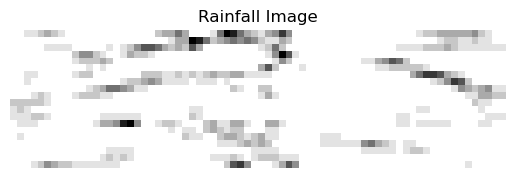

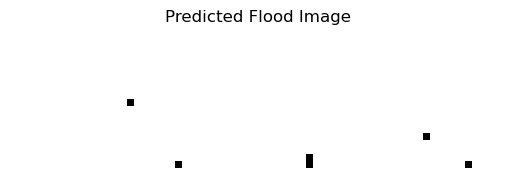

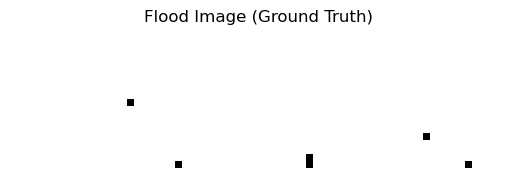

Best Image
F1-Score: 1.0000
Middle Prediction:


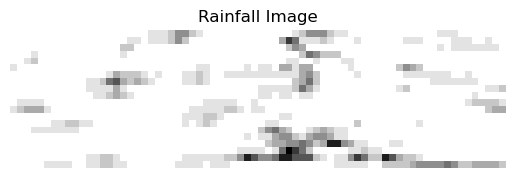

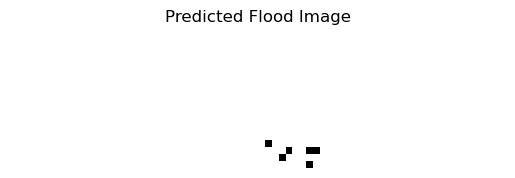

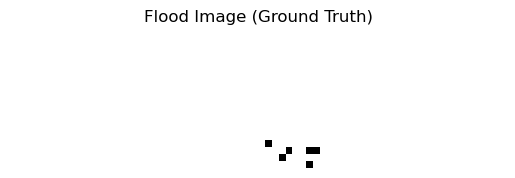

Middle Image
F1-Score: 1.0000
Worst Prediction:


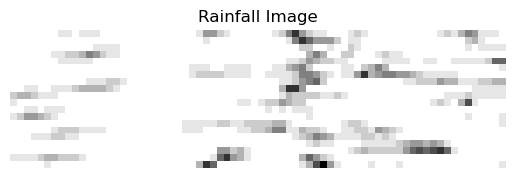

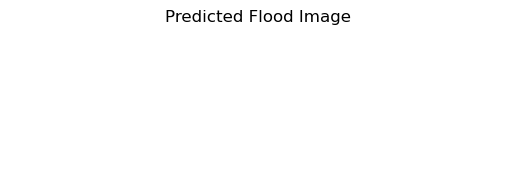

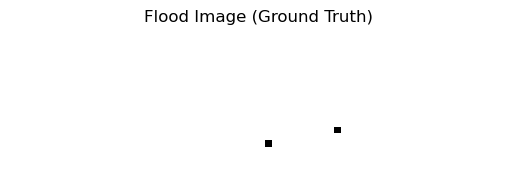

Worst Image
F1-Score: 0.0000
Average Precision: 0.9252, Average Recall: 0.8657, Average F1-Score: 0.8583


In [89]:
# Calculate metrics for all predicted flood images
metrics = [calculate_metrics(real_images[i, 0], predicted_images[i, 0]) for i in range(len(predicted_images))]

# Sort the images based on their F1-scores in descending order
sorted_indices = sorted(range(len(metrics)), key=lambda k: metrics[k][2], reverse=True)

# Display the best, middle, and worst predictions
best_n = 1
middle_n = 1
worst_n = 1

# Display the best prediction
print("Best Prediction:")
index = sorted_indices[0]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("best_rainfall_convrnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("best_predicted_convrnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("best_real_convrnn.png")
plt.show()

print(f"Best Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the middle prediction
print("Middle Prediction:")
index = sorted_indices[len(sorted_indices) // 2]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("middle_rainfall_convrnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("middle_predicted_convrnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("middle_real_convrnn.png")
plt.show()

print(f"Middle Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the worst prediction
print("Worst Prediction:")
index = sorted_indices[-1]
input_img = input_images[index, 0]
real_img = real_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape rainfall images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
real_img_np = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
real_img_pil = Image.fromarray((real_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display rainfall image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Rainfall Image')
plt.axis('off')
plt.savefig("worst_rainfall_convrnn.png")
plt.show()

# Display predicted flood image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Flood Image')
plt.axis('off')
plt.savefig("worst_predicted_convrnn.png")
plt.show()

# Display corresponding flood image
plt.imshow(real_img_pil, cmap='binary')
plt.title('Flood Image (Ground Truth)')
plt.axis('off')
plt.savefig("worst_real_convrnn.png")
plt.show()

print(f"Worst Image")
print(f"F1-Score: {metrics[index][2]:.4f}")
print("=" * 50)

# Calculate the average metrics for all predicted flood images
precision_scores = [m[0] for m in metrics]
recall_scores = [m[1] for m in metrics]
f1_scores = [m[2] for m in metrics]
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)
print(f"Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1-Score: {average_f1:.4f}")

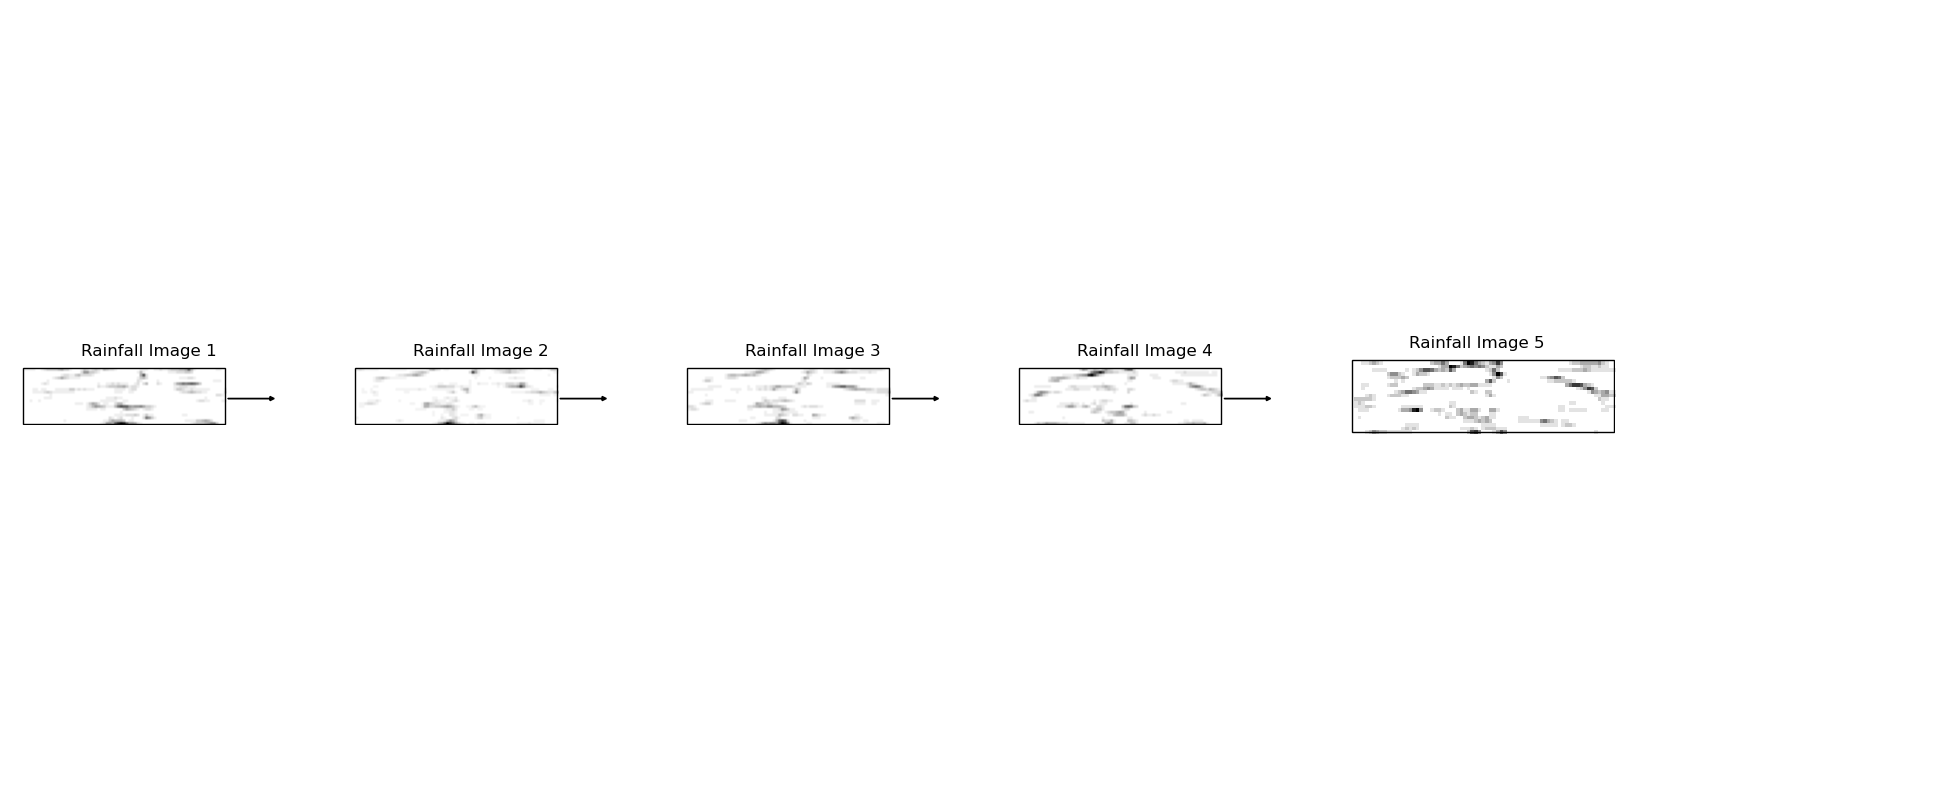

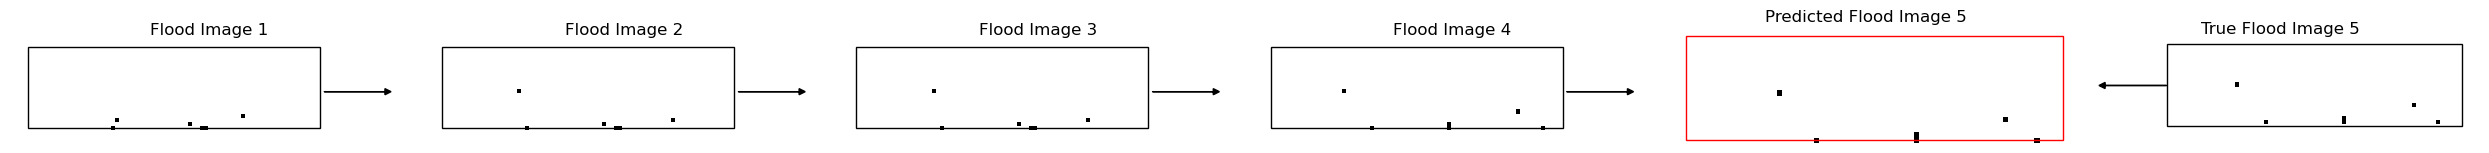

Example 2
F1-Score: 1.0000


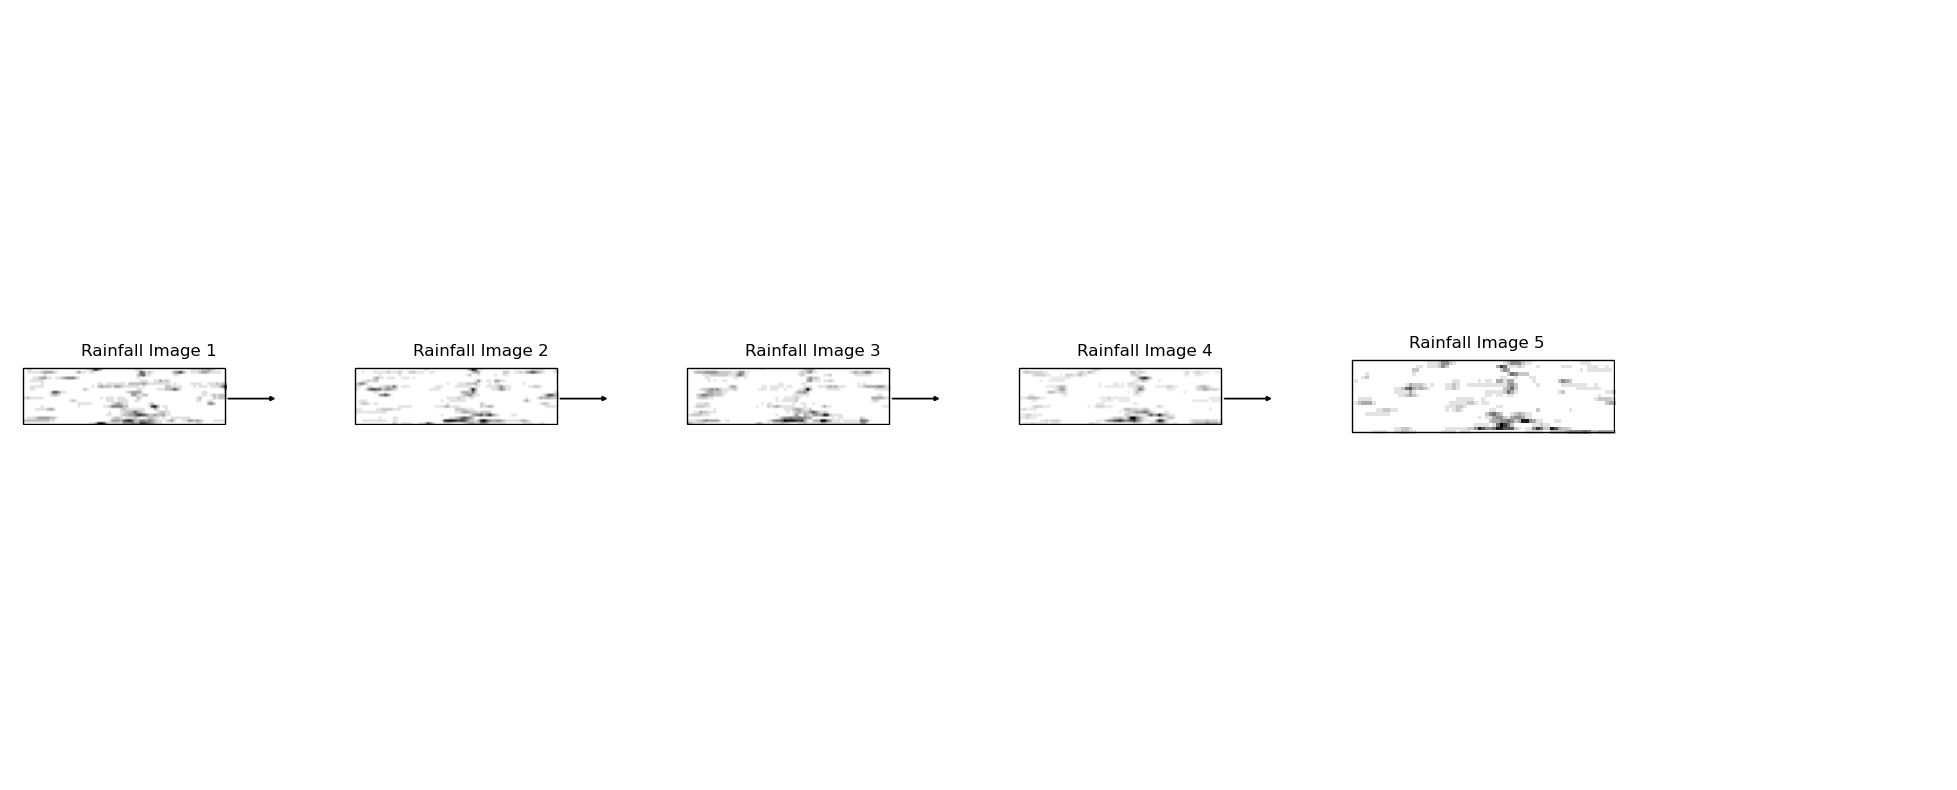

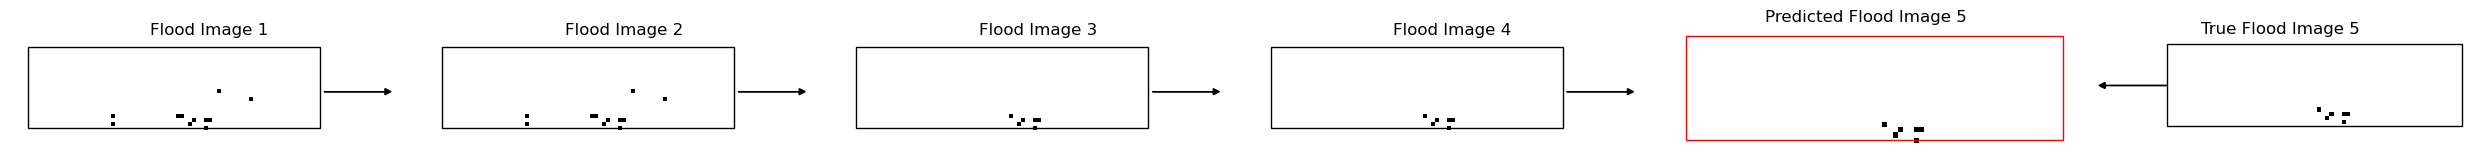

Example 1405
F1-Score: 1.0000


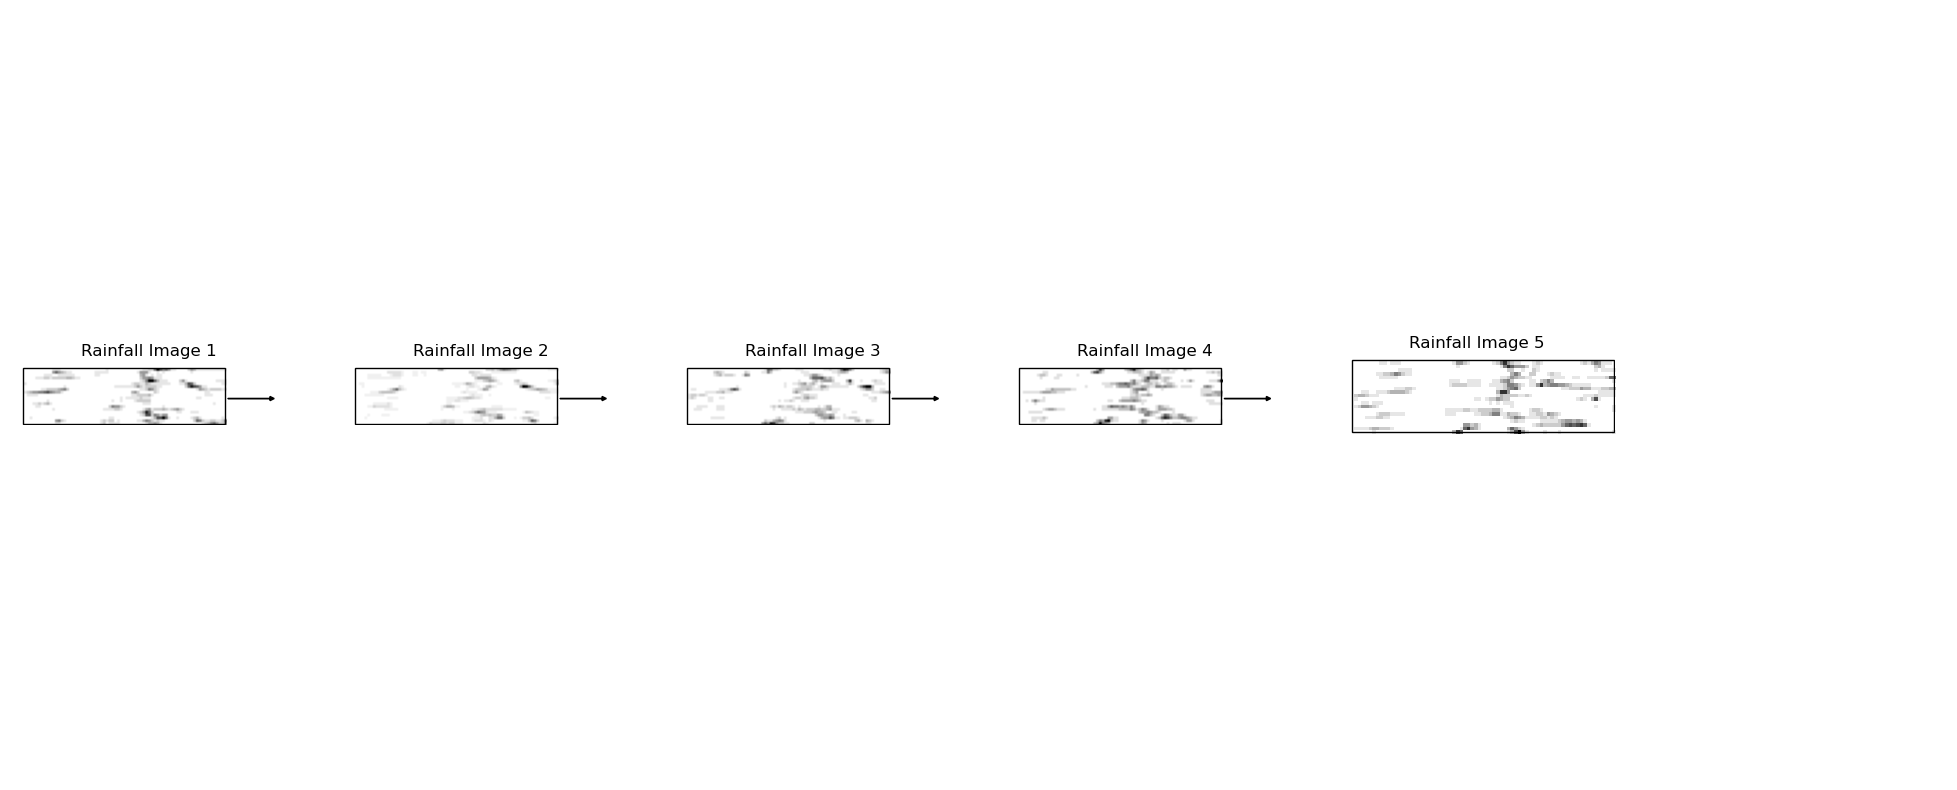

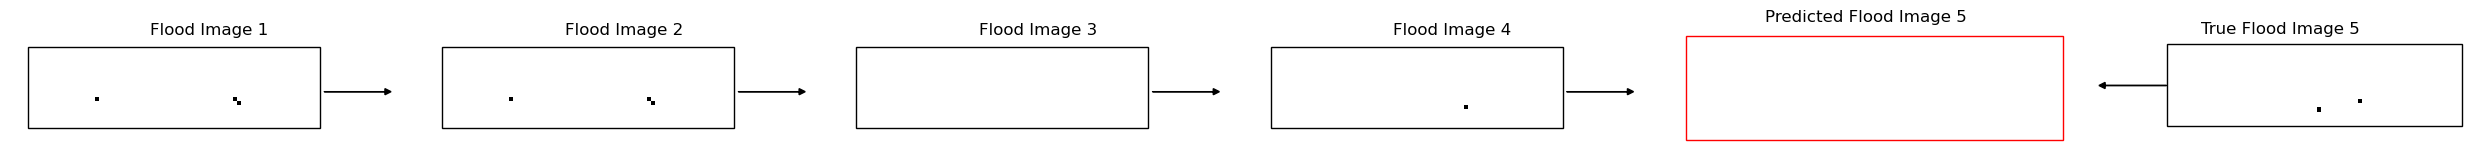

Example 1360
F1-Score: 0.0000


In [90]:
# Display examples of highest scoring, lowest scoring, and median scoring predictions
examples_indices = [sorted_indices[0], sorted_indices[len(sorted_indices) // 2], sorted_indices[-1]]
filenames = ["best", "middle", "worst"]
count = 0

for index in examples_indices:
    # Get the indices of the images for this example
    image_indices = [index - 4, index - 3, index - 2, index - 1, index, index]

    # Create two separate figures with a 1x6 layout
    fig1, axs1 = plt.subplots(1, 6, figsize=(25, 10))
    fig2, axs2 = plt.subplots(1, 6, figsize=(25, 10))
    
    plt.subplots_adjust(wspace=0.1)  # Adjust horizontal spacing

    for i, img_index in enumerate(image_indices):
        input_img = input_images[img_index, 0]
        real_img = real_images[img_index, 0]
        pred_img = predicted_images[img_index, 0]

        # Reshape and resize rainfall images to downscaled_resolution for display
        input_img_resized = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        real_img_resized = real_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        pred_img_resized = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

        # Convert NumPy arrays to images using PIL
        input_img_pil = Image.fromarray((input_img_resized * 255).astype(np.uint8), mode='L')
        real_img_pil = Image.fromarray((real_img_resized * 255).astype(np.uint8), mode='L')
        pred_img_pil = Image.fromarray((pred_img_resized * 255).astype(np.uint8), mode='L')

        if i <= 3:
            axs1[i].imshow(input_img_pil, cmap='binary')
            axs1[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs1[i].set_title('Rainfall Image '+str(i+1))
            axs1[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs1[i].axis('off')

            axs2[i].imshow(real_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs2[i].set_title('Flood Image '+str(i+1))
            axs2[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs2[i].axis('off')

        if i == 4:
            axs1[i].imshow(input_img_pil, cmap='binary')
            axs1[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs1[i].set_title('Rainfall Image '+str(i+1))
            axs1[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0.01, head_length=0, fc='white', ec='white')
            axs1[i].axis('off')

            axs2[i].imshow(pred_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='red'))
            axs2[i].set_title('Predicted Flood Image '+str(i+1))
            axs2[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0, head_length=0, fc='white', ec='white')
            axs2[i].axis('off')
            
        if i == 5:
            axs1[i].axis('off')

            axs2[i].imshow(real_img_pil, cmap='binary')
            axs2[i].add_patch(patches.Rectangle((0, 0), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs2[i].arrow(0, downscaled_resolution[1]/2, -15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs2[i].set_title('True Flood Image '+str(i))
            axs2[i].axis('off')

    plt.tight_layout()
    fig1.savefig(filenames[count]+"_convlstm_rainfall_sequence.png")
    fig2.savefig(filenames[count]+"_convlstm_flood_sequence.png")
    count+=1
    plt.show()

    print(f"Example {index + 1}")
    print(f"F1-Score: {metrics[index][2]:.4f}")
    print("=" * 50)

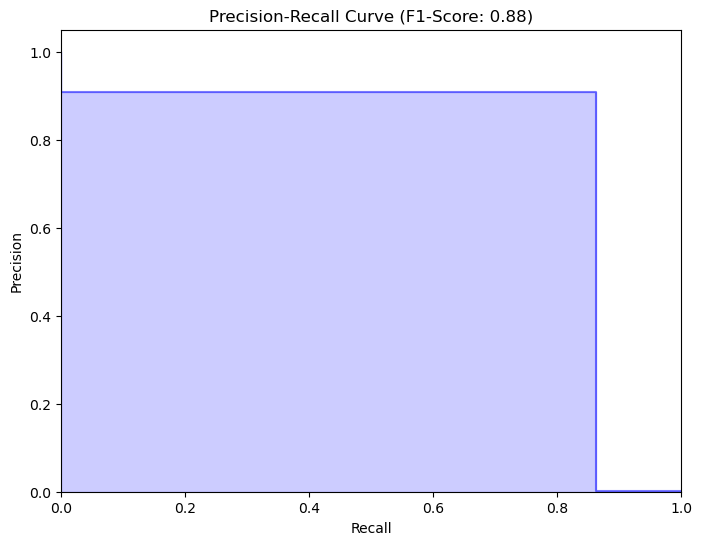

In [91]:
# Flatten the real and predicted images
real_labels = real_images.flatten()
predicted_scores = predicted_images.flatten()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(real_labels, predicted_scores)

# Calculate F1-score
f1 = f1_score(real_labels, np.round(predicted_scores))

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (F1-Score: {:.2f})'.format(f1))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.savefig("convrnn_curve.png")
plt.show()

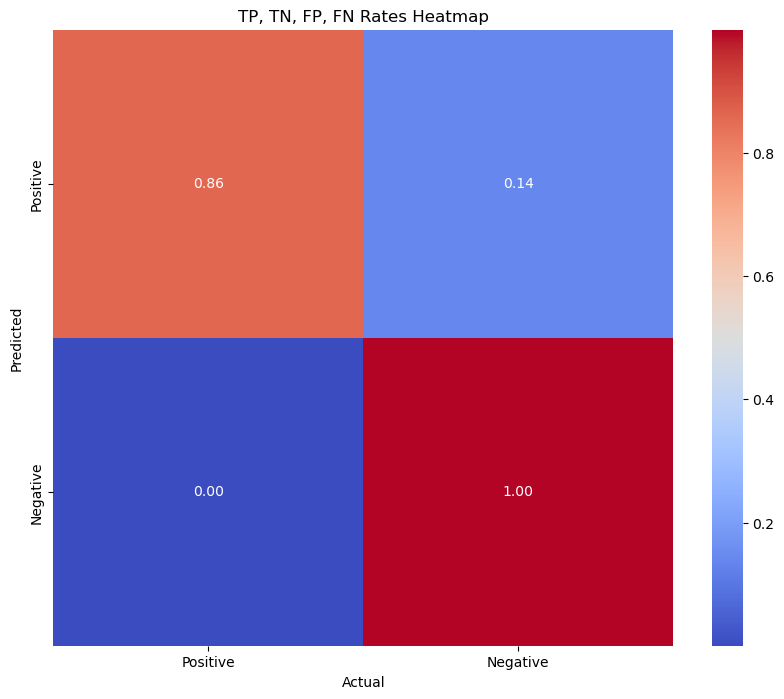

In [92]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(real_labels, np.round(predicted_scores))

# Calculate true positive (TP), true negative (TN), false positive (FP), false negative (FN) rates
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate rates
TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity/Recall)
TNR = TN / (TN + FP)  # True Negative Rate (Specificity)
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate

# Create heatmaps for TP, TN, FP, FN rates
rates = np.array([[TPR, FNR], [FPR, TNR]])

plt.figure(figsize=(10, 8))
sns.heatmap(rates, annot=True, fmt=".2f", cmap='coolwarm', center=0.5,
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('TP, TN, FP, FN Rates Heatmap')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig("convrnn_heatmap.png")
plt.show()

In [93]:
class RainfallConvLSTM(nn.Module):
    #def __init__(self, rainfall_input_size, feature_input_size, date_input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
    def __init__(self, rainfall_input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(RainfallConvLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = rainfall_input_size
        
        # ConvLSTM layer to process sequential data
        self.conv_lstm = ConvLSTM(input_dim=1, hidden_dim=[256] * num_layers, kernel_size=(3, 3),
                                  num_layers=num_layers, batch_first=True, bias=True, return_all_layers=False)
        
        self.mapping_layer = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)  # Linear mapping

        # Add Multihead Attention layer for rainfall ConvLSTM output
        self.convlstm_attention = nn.MultiheadAttention(embed_dim=downscaled_resolution[0]*downscaled_resolution[1], num_heads=4)

        # Batch normalization along the feature dimension
        self.convlstm_batch_norm = nn.BatchNorm1d(downscaled_resolution[0]*downscaled_resolution[1])

        # Output layer to generate predictions
        #self.fc = nn.Linear(hidden_size * 3, output_size)  # Concatenate ConvLSTM and LSTM outputs

    def forward(self, rainfall_batch):
        # rainfall_batch shape: (batch_size, sequence_length, downscaled_resolution[0], downscaled_resolution[1])

        current_batch_size, sequence_length, _ = rainfall_batch.size()
        
        # Reshape rainfall_batch to match the ConvLSTM input dimensions
        convlstm_input = rainfall_batch.view(current_batch_size, sequence_length, 1, downscaled_resolution[0], downscaled_resolution[1])

        # Process rainfall_batch with ConvLSTM
        convlstm_output, _ = self.conv_lstm(convlstm_input)

        # Reshape ConvLSTM output to match LSTM output dimensions
        convlstm_output = convlstm_output[0] # Extract the last hidden state
        convlstm_output = convlstm_output[:, -1, :, :, :].squeeze(1) 
        convlstm_output = self.mapping_layer(convlstm_output)  # Map the hidden state

        # Reshape ConvLSTM output to [batch_size, desired_dim, downscaled_resolution[0] * downscaled_resolution[1]]
        convlstm_output = convlstm_output.view(current_batch_size, 1, output_size)

        # Apply Multihead Attention to the ConvLSTM outputs
        with torch.no_grad():
            convlstm_attn_output, _ = self.convlstm_attention(
                convlstm_output,  # Transpose dimensions
                convlstm_output,  # Transpose dimensions
                convlstm_output   # Transpose dimensions
            )
        combined_convlstm_output = convlstm_output + convlstm_attn_output
        
        # Batch normalization along the sequence_length dimension
        combined_convlstm_output = combined_convlstm_output.permute(0, 2, 1)
        combined_convlstm_output = self.convlstm_batch_norm(combined_convlstm_output)
        combined_convlstm_output = combined_convlstm_output.permute(0, 2, 1)
        
        # Reshape the output to match the downscaled_resolution
        current_batch_size, sequence_length, _ = combined_convlstm_output.size()
        output = combined_convlstm_output.view(current_batch_size, 1, downscaled_resolution[1], downscaled_resolution[0])

        return output

In [94]:
# Define the input size based on the feature vector size
input_size = downscaled_resolution[0] * downscaled_resolution[1]

# Assuming you have already defined train_loader, valid_loader, and other variables
rainfall_input_size = input_size  # Adjust this based on the size of the feature maps
feature_input_size = 1000
date_input_size = 65  # Adjust this based on the size of the date tensors
output_size = input_size

hidden_size = 128
num_layers = 2
output_size = input_size
dropout_prob = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = RainfallConvLSTM(rainfall_input_size, feature_input_size, date_input_size, hidden_size, num_layers, output_size, dropout_prob)  # Use ConvLSTM class
model = RainfallConvLSTM(rainfall_input_size, hidden_size, num_layers, output_size, dropout_prob)  # Use ConvLSTM class
model.to(device)

# Define the loss function and optimizer with L2 regularization (weight decay)
learning_rate = 0.001
weight_decay = 1e-5  # You can adjust the weight decay strength
# Gradient clipping
max_grad_norm = 1.0  # Adjust as needed
criterion = nn.MSELoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0))
#criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)
#criterion = FocalLoss(alpha=1, gamma=1, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Set the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Set the directory where you want to save the model state
save_dir = "/kaggle/working/sequence_models"
os.makedirs(save_dir, exist_ok=True)

In [95]:
new_sequence = 1

In [ ]:
# Training loop
num_epochs = 100
train_losses = []
valid_losses = []

# Keep track of the best validation loss and the corresponding epoch
best_valid_loss = float('inf')
best_epoch = None
patience = 10  # Number of epochs to wait for improvement before early stopping

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Use tqdm to monitor progress for the training loop
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, (rainfall_batch, _, feature_batch, date_batch) in enumerate(tepoch):
            rainfall_batch = rainfall_batch.to(device)
            
            optimizer.zero_grad()

            current_batch_size, sequence_length, _, _ = rainfall_batch.size()
            rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)
            
            # Feed the first four images to the model
            input_sequence = rainfall_batch[:, :sequence_length-1, :]
            output = model(input_sequence)
            
            # Reshape the output to match the downscaled_resolution
            current_batch_size, sequence_length, _, _ = output.size()
            output = output.view(current_batch_size, sequence_length, output_size)

            # Compare the predicted fifth image with the actual fifth image
            target = rainfall_batch[:, sequence_length-1, :].unsqueeze(1)  # Assuming the target is the fifth image

            loss = criterion(output, target)
            loss.backward()

            optimizer.step()

            total_train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    # Calculate and store average training loss for this epoch
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop (assuming you have a validation set)
    model.eval()
    total_valid_loss = 0

    # Use tqdm to monitor progress for the validation loop
    with tqdm(valid_loader, unit="batch") as tvalid:
        with torch.no_grad():
            for rainfall_batch, _, feature_batch, date_batch in tvalid:
                rainfall_batch = rainfall_batch.to(device)
                
                optimizer.zero_grad()

                current_batch_size, sequence_length, _, _ = rainfall_batch.size()
                rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)

                # Feed the first four images to the model
                input_sequence = rainfall_batch[:, :sequence_length-1, :]
                output = model(input_sequence)

                # Reshape the output to match the downscaled_resolution
                current_batch_size, sequence_length, _, _ = output.size()
                output = output.view(current_batch_size, sequence_length, output_size)

                # Compare the predicted fifth image with the actual fifth image
                target = rainfall_batch[:, sequence_length-1, :].unsqueeze(1)  # Assuming the target is the fifth image

                loss = criterion(output, target)
                total_valid_loss += loss.item()
                tvalid.set_postfix(loss=loss.item())

    # Calculate and store average validation loss for this epoch
    valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    # Print epoch-wise losses
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

    # Update the learning rate scheduler based on the validation loss
    scheduler.step(valid_loss)

    # Save the model state if the validation loss has improved
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch + 1
        epochs_without_improvement = 0  # Reset the counter for lack of improvement
        model_state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses,
        }
        save_path = os.path.join(save_dir, f"sequence_best.pt")
        torch.save(model_state, save_path)
        print(f"Best model state saved at epoch {epoch + 1}")

    else:
        epochs_without_improvement += 1

    # Early stopping: If both lack of improvement and stagnation occur for the specified patience, stop training
    if epochs_without_improvement >= patience:
        print(f"Stopping early as validation loss has not improved or stagnated for {patience} consecutive epochs.")
        break

# Plot the losses over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.savefig("rainfall_convlstm_losses.png")
plt.show()

100%|██████████| 46/46 [00:12<00:00,  3.54batch/s, loss=1.77]


Epoch [1/100], Train Loss: 0.0094, Valid Loss: 1.7671
Best model state saved at epoch 1


100%|██████████| 46/46 [00:12<00:00,  3.58batch/s, loss=0.00749]


Epoch [2/100], Train Loss: 0.0020, Valid Loss: 0.0071
Best model state saved at epoch 2


100%|██████████| 46/46 [00:12<00:00,  3.59batch/s, loss=0.849]


Epoch [3/100], Train Loss: 0.0020, Valid Loss: 0.8485


100%|██████████| 46/46 [00:12<00:00,  3.59batch/s, loss=0.18] 


Epoch [4/100], Train Loss: 0.0020, Valid Loss: 0.1796


100%|██████████| 46/46 [00:12<00:00,  3.60batch/s, loss=0.0185]


Epoch [5/100], Train Loss: 0.0020, Valid Loss: 0.0183


100%|██████████| 46/46 [00:12<00:00,  3.56batch/s, loss=0.525]


Epoch [6/100], Train Loss: 0.0020, Valid Loss: 0.5257
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 46/46 [00:12<00:00,  3.60batch/s, loss=0.372]


Epoch [7/100], Train Loss: 0.0020, Valid Loss: 0.3724


100%|██████████| 46/46 [00:12<00:00,  3.60batch/s, loss=0.088] 


Epoch [8/100], Train Loss: 0.0020, Valid Loss: 0.0879


100%|██████████| 46/46 [00:12<00:00,  3.58batch/s, loss=0.0905]


Epoch [9/100], Train Loss: 0.0020, Valid Loss: 0.0904


100%|██████████| 46/46 [00:12<00:00,  3.60batch/s, loss=0.058] 


Epoch [10/100], Train Loss: 0.0020, Valid Loss: 0.0579
Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 46/46 [00:12<00:00,  3.60batch/s, loss=0.038] 


Epoch [11/100], Train Loss: 0.0020, Valid Loss: 0.0381


 43%|████▎     | 69/160 [00:54<01:11,  1.28batch/s, loss=0.00204]

In [ ]:
if new_sequence == 1:
    # Generate a file link for the best model
    best_sequence_link = FileLink(save_path)
    print("Download the best model:", best_sequence_link)

In [98]:
# Load the saved model state (best model)
if new_sequence == 1:
    model_path = "/kaggle/working/sequence_models/sequence_best.pt"  # Replace with the actual path to the saved best model state
else:
    model_path = "/kaggle/input/sequence-model-1/sequence_best.pt"  # Replace with the actual path to the saved model state

checkpoint = torch.load(model_path)

# Load the best model state
model_state_dict = checkpoint['state_dict']
model_dict = model.state_dict()

# Filter out the missing keys and load only the matching keys
model_state_dict = {k: v for k, v in model_state_dict.items() if k in model_dict}
model_dict.update(model_state_dict)
model.load_state_dict(model_dict)
model.eval()

# Test the model on the test set and calculate the loss
input_images = []
predicted_images = []

with torch.no_grad(), tqdm(test_loader, unit="batch") as ttest:
    for rainfall_batch, _, feature_batch, date_batch in ttest:
        rainfall_batch = rainfall_batch.to(device)

        current_batch_size, sequence_length, _, _ = rainfall_batch.size()
        rainfall_batch = rainfall_batch.view(current_batch_size, sequence_length, output_size)

        # Feed the first four images to the model
        input_sequence = rainfall_batch[:, :sequence_length-1, :]
        output = model(input_sequence)

        # Reshape the output to match the downscaled_resolution
        current_batch_size, sequence_length, _, _ = output.size()
        output = output.view(current_batch_size, sequence_length, output_size)
        
        target = rainfall_batch[:, sequence_length-1, :].unsqueeze(1)
        target = target.view(current_batch_size, sequence_length, output_size)
        
        output = torch.clamp(output, 0, 1)
        
        # Append the input and predicted rainfall sequences to their respective lists
        input_images.extend(target.cpu().numpy())
        predicted_images.extend(output.cpu().numpy())

# Convert the lists to numpy arrays

input_images = np.array(input_images)
predicted_images = np.array(predicted_images)

#messy_predicted_images = predicted_images

# Clip the unclipped predicted images to ensure they are within the valid range [0, 1]
#predicted_images = np.clip(predicted_images, 0, 1)  # Clipping

100%|██████████| 46/46 [00:12<00:00,  3.62batch/s]


In [99]:
print(input_images.shape)
print(predicted_images.shape)

# Print the first values in the first image for each set
print("First values in the first image for each set:")
print("Input Images:")
print(input_images[0, 0])
#print("Messy Predicted Images:")
#print(messy_predicted_images[0, 0])
print("Predicted Images:")
print(predicted_images[0, 0])

(1455, 1, 1440)
(1455, 1, 1440)
First values in the first image for each set:
Input Images:
[0. 0. 0. ... 0. 0. 0.]
Predicted Images:
[0.03420214 0.17123653 0.23003434 ... 0.         0.         0.        ]


In [100]:
def calculate_rainfall_metrics(real_img, pred_img):
    rmse = np.sqrt(mean_squared_error(real_img, pred_img))
    mae = mean_absolute_error(real_img, pred_img)
    ssim_score = ssim(real_img, pred_img, data_range=1.0)
    
    return rmse, mae, ssim_score

Best Prediction:


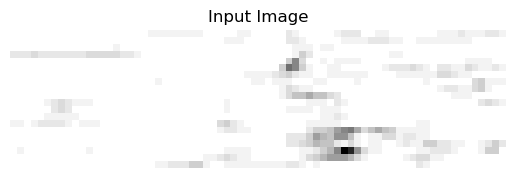

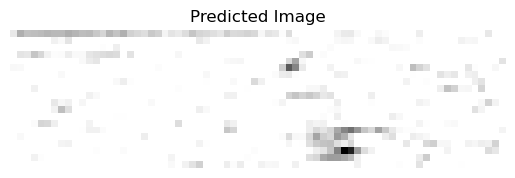

Best Image
RMSE: 0.0694, MAE: 0.0214 SSIM: 0.5993
Middle Prediction:


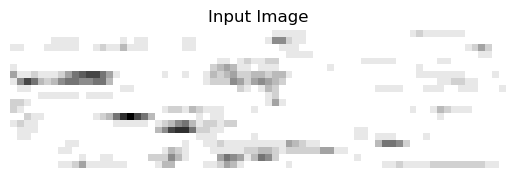

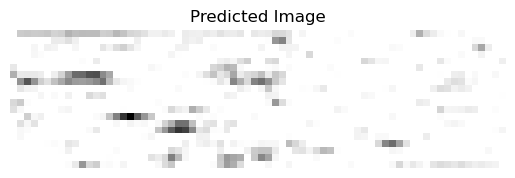

Middle Image
RMSE: 0.1236, MAE: 0.0426 SSIM: 0.4903
Worst Prediction:


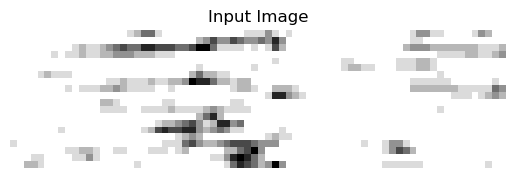

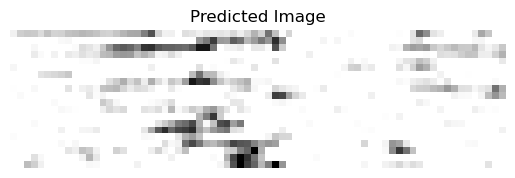

Worst Image
RMSE: 0.2005, MAE: 0.0814, SSIM: 0.4201
Average metrics on the test set:
Average RMSE: 0.1243
Average MAE: 0.0461
Average SSIM: 0.4756


In [101]:
# Calculate metrics for all predictions
metrics = [calculate_rainfall_metrics(real_img, pred_img) for real_img, pred_img in zip(real_images[:, 0], predicted_images[:, 0])]

# Get the indices that would sort the RMSE scores list in ascending order
sorted_indices = np.argsort([rmse for rmse, _, _ in metrics])

# Define the index of the best, middle, and worst predictions
best_index = sorted_indices[0]
middle_index = sorted_indices[len(sorted_indices) // 2]
worst_index = sorted_indices[-1]

# Display the best prediction
print("Best Prediction:")
index = best_index
input_img = input_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display input image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Input Image')
plt.axis('off')
plt.savefig('best_rainfall_input.png')
plt.show()

# Display predicted image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Image')
plt.axis('off')
plt.savefig('best_rainfall_output.png')
plt.show()

print(f"Best Image")
print(f"RMSE: {metrics[index][0]:.4f}, MAE: {metrics[index][1]:.4f} SSIM: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the middle prediction
print("Middle Prediction:")
index = middle_index
input_img = input_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display input image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Input Image')
plt.axis('off')
plt.savefig('middle_rainfall_input.png')
plt.show()

# Display predicted image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Image')
plt.axis('off')
plt.savefig('middle_rainfall_output.png')
plt.show()

print(f"Middle Image")
print(f"RMSE: {metrics[index][0]:.4f}, MAE: {metrics[index][1]:.4f} SSIM: {metrics[index][2]:.4f}")
print("=" * 50)

# Display the worst prediction
print("Worst Prediction:")
index = worst_index
input_img = input_images[index, 0]
pred_img = predicted_images[index, 0]

# Reshape images to downscaled_resolution for display
input_img_np = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
pred_img_np = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

# Convert NumPy arrays to images using PIL
input_img_pil = Image.fromarray((input_img_np * 255).astype(np.uint8), mode='L')
pred_img_pil = Image.fromarray((pred_img_np * 255).astype(np.uint8), mode='L')

# Display input image
plt.imshow(input_img_pil, cmap='binary')
plt.title('Input Image')
plt.axis('off')
plt.savefig('worst_rainfall_input.png')
plt.show()

# Display predicted image
plt.imshow(pred_img_pil, cmap='binary')
plt.title('Predicted Image')
plt.axis('off')
plt.savefig('worst_rainfall_output.png')
plt.show()

print(f"Worst Image")
print(f"RMSE: {metrics[index][0]:.4f}, MAE: {metrics[index][1]:.4f}, SSIM: {metrics[index][2]:.4f}")
print("=" * 50)

# Calculate and print the average metrics for all predicted images
average_metrics = np.mean(metrics, axis=0)
print("Average metrics on the test set:")
print(f"Average RMSE: {average_metrics[0]:.4f}")
print(f"Average MAE: {average_metrics[1]:.4f}")
print(f"Average SSIM: {average_metrics[2]:.4f}")

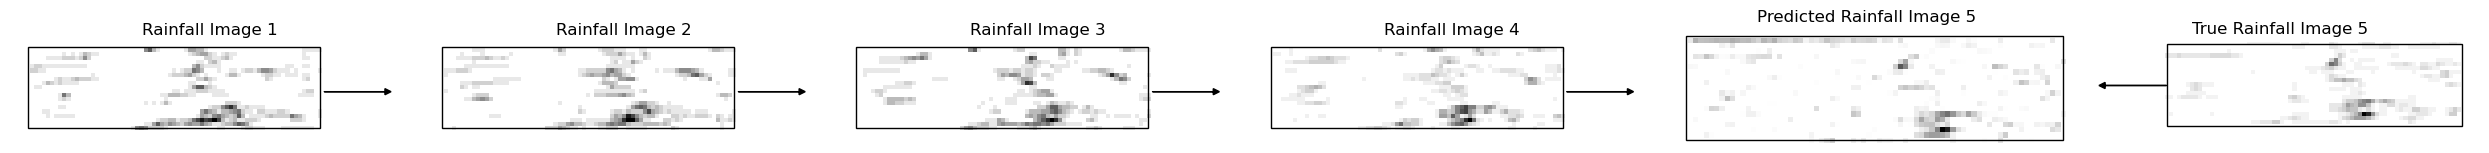

Example 1314
RMSE: 0.0694


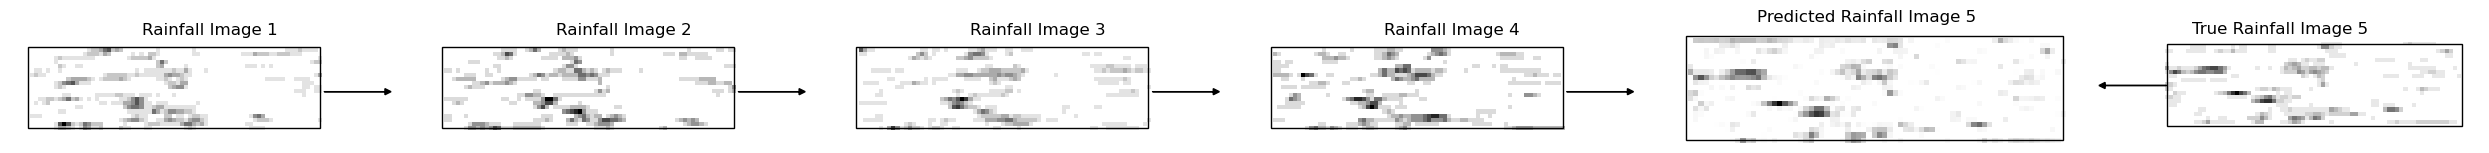

Example 434
RMSE: 0.1236


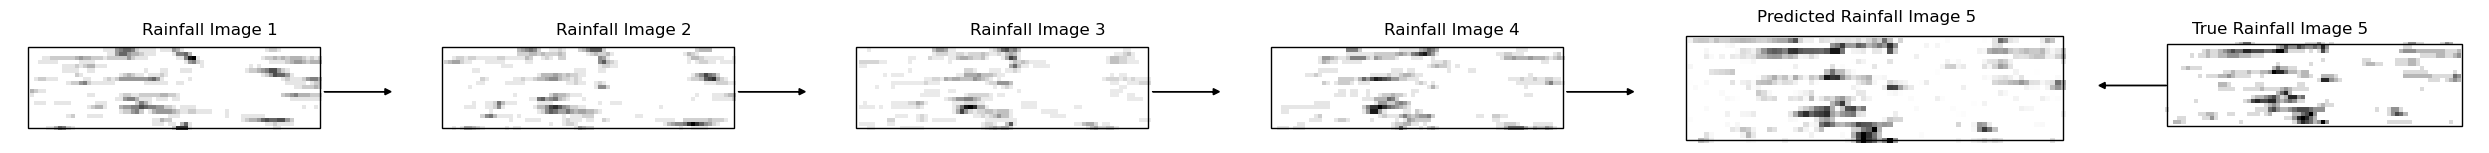

Example 21
RMSE: 0.2005


In [102]:
# Display examples of highest scoring, lowest scoring, and median scoring predictions
examples_indices = [sorted_indices[0], sorted_indices[len(sorted_indices) // 2], sorted_indices[-1]]
filenames = ["best", "middle", "worst"]
count = 0

for index in examples_indices:
    # Get the indices of the images for this example
    image_indices = [index - 4, index - 3, index - 2, index - 1, index, index]

    # Create two separate figures with a 1x6 layout
    fig, axs = plt.subplots(1, 6, figsize=(25, 10))
    
    plt.subplots_adjust(wspace=0.1)  # Adjust horizontal spacing

    for i, img_index in enumerate(image_indices):
        input_img = input_images[img_index, 0]
        pred_img = predicted_images[img_index, 0]

        # Reshape and resize rainfall images to downscaled_resolution for display
        input_img_resized = input_img.reshape(downscaled_resolution[1], downscaled_resolution[0])
        pred_img_resized = pred_img.reshape(downscaled_resolution[1], downscaled_resolution[0])

        # Convert NumPy arrays to images using PIL
        input_img_pil = Image.fromarray((input_img_resized * 255).astype(np.uint8), mode='L')
        pred_img_pil = Image.fromarray((pred_img_resized * 255).astype(np.uint8), mode='L')

        if i <= 3:
            axs[i].imshow(input_img_pil, cmap='binary')
            axs[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs[i].set_title('Rainfall Image '+str(i+1))
            axs[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs[i].axis('off')

        if i == 4:
            axs[i].imshow(pred_img_pil, cmap='binary')
            axs[i].add_patch(patches.Rectangle((-1, -1), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs[i].set_title('Predicted Rainfall Image '+str(i+1))
            axs[i].arrow(downscaled_resolution[0], downscaled_resolution[1]/2, 0, 0, head_width=0.01, head_length=0, fc='white', ec='white')
            axs[i].axis('off')
            
        if i == 5:
            axs[i].imshow(input_img_pil, cmap='binary')
            axs[i].add_patch(patches.Rectangle((0, 0), downscaled_resolution[0], downscaled_resolution[1], fill=False, color='black'))
            axs[i].arrow(0, downscaled_resolution[1]/2, -15, 0, head_width=1.5, head_length=1.5, fc='black', ec='black')
            axs[i].set_title('True Rainfall Image '+str(i))
            axs[i].axis('off')

    plt.tight_layout()
    fig.savefig(filenames[count]+"_convlstm_no_flood_rainfall_sequence.png")
    count+=1
    plt.show()

    print(f"Example {index + 1}")
    print(f"RMSE: {metrics[index][0]:.4f}")
    print("=" * 50)

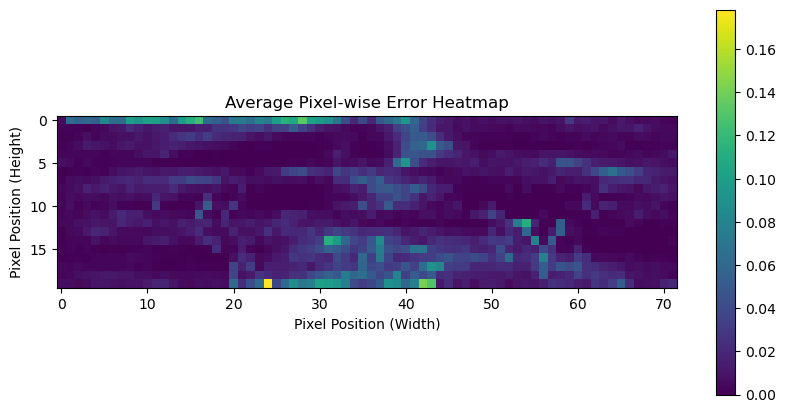

In [103]:
# Reshape real_images and predicted_images
real_images = real_images.reshape(real_images.shape[0], downscaled_resolution[1], downscaled_resolution[0])
predicted_images = predicted_images.reshape(predicted_images.shape[0], downscaled_resolution[1], downscaled_resolution[0])

# Calculate pixel-wise errors
errors = np.abs(predicted_images - real_images)**2

# Calculate average error
average_error = np.mean(errors, axis=0)

# Create a heatmap for the average error
plt.figure(figsize=(10, 5))
plt.imshow(average_error, cmap='viridis')  # You can use other colormaps as well
plt.colorbar()
plt.title('Average Pixel-wise Error Heatmap')
plt.xlabel('Pixel Position (Width)')
plt.ylabel('Pixel Position (Height)')
plt.savefig("convrnn_rainfall_heatmap.png")
plt.show()